# IMPORT LIBRARY

In [ ]:
!pip install datasets sentencepiece

In [ ]:
!pip install langdetect

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.5/981.5 kB 22.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for langdetect: filename=langdetect-1.0.9-py3-none-any.whl size=993223 sha256=a37ee1844376da290bb99f2a0a9cff7dd2ee6097ca9881260176af9dcf4cc917
  Stored in directory: /root/.cache/pip/wheels/0a/f2/b2/e5ca405801e05eb7c8ed5b3b4bcf1fcabcd6272c167640072e
Successfully built langdetect


In [ ]:
from google.colab import drive
import requests
from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import json
import csv
import re
import html
import os
import torch

from langdetect import detect
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity

from transformers import BertConfig
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
from transformers import XLMRobertaTokenizer, XLMRobertaForSequenceClassification, Trainer, TrainingArguments
from torch.utils.data import Dataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from transformers import BartTokenizer, BartForConditionalGeneration, Seq2SeqTrainer, Seq2SeqTrainingArguments, DataCollatorForSeq2Seq
from datasets import Dataset

import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, GlobalAveragePooling1D, Input, Dense, Dropout
from tensorflow.keras.models import Model

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


# DATA SCRAPING

In [ ]:
def scrape_resep(url):
    try:
        response = requests.get(url)

        if response.status_code != 200:
            return None

        soup = BeautifulSoup(response.text, 'html.parser')
        nama_makanan = soup.find('h1').text.strip()

        bahan_bahan_section = soup.find('div', class_='ingredient-list')
        bahan_elements = bahan_bahan_section.find_all('li') if bahan_bahan_section else []

        bahan = []
        for bahan_item in bahan_elements:
            jumlah = bahan_item.find('bdi').text.strip() if bahan_item.find('bdi') else "N/A"
            nama_bahan = bahan_item.find('span').text.strip() if bahan_item.find('span') else "N/A"
            bahan.append(f"{jumlah} {nama_bahan}")

        langkah_section = soup.find('ol', class_='list-none')
        langkah_elements = langkah_section.find_all('li') if langkah_section else []

        langkah = []
        for langkah_item in langkah_elements:
            langkah_text = langkah_item.text.strip()
            langkah.append(langkah_text)

        resep_data = {
            'url': url,
            'nama_makanan': nama_makanan,
            'bahan': bahan,
            'langkah': langkah
        }

        return resep_data

    except Exception:
        return None

def looping_resep(n, base_url):
    hasil = []
    for i in range(n, n - 500, -1):
        url = f"{base_url}{i}"
        resep = scrape_resep(url)
        if resep:
            hasil.append(resep)
            print(f"\nScraping URL: {url}")
        else:
            print(f"Resepnya ngga ada {url}")
    return hasil

def proses_list_resep(list_resep, filename='/content/drive/Shareddrives/DBS/raw/resep_data.json'):
    base_url = 'https://cookpad.com/id/resep/'

    if os.path.exists(filename):
        with open(filename, 'r', encoding='utf-8') as f:
            resep_all = json.load(f)
        for i, item in enumerate(resep_all):
            if 'url' not in item:
                item['url'] = f"{base_url}unknown-{i}"
        url_sudah_ada = {r['url'] for r in resep_all}
    else:
        resep_all = []
        url_sudah_ada = set()

    for i in list_resep:
        data_baru = looping_resep(i, base_url)
        for item in data_baru:
            if item['url'] not in url_sudah_ada:
                resep_all.append(item)
                url_sudah_ada.add(item['url'])

    with open(filename, 'w', encoding='utf-8') as json_file:
        json.dump(resep_all, json_file, ensure_ascii=False, indent=4)

In [ ]:
list_resep = [24773729, 24765805, 24774089, 24739806, 24780488,
              24795165, 24699009, 24767126, 24784742, 24693059,
              24782987, 24757904, 24735371, 24727285, 24724573,
              24753357, 24559042, 24733444, 24609990, 16083782,
              24722953, 24716201, 24693643, 24693363, 24788871,
              24646316, 24560426, 24768523, 24769948, 24770694,
              24771024, 24685613, 24744598, 24683806, 24587690,
              24779437, 24770855, 24779534, 24428445, 24148526,
              24567206, 24544522, 24563683, 24563700, 24555147,
              24558051, 24519286, 24396120, 24517783, 24149665,
              24677266, 24668648, 24653630, 24640494, 24617909,
              24776100, 24766712, 24770235, 24387674, 24622085,
              24781529, 24780128, 24778195, 24770288, 24765458,
              24527730, 24524396, 24511035, 24508416, 24462999]
proses_list_resep(list_resep)

In [ ]:
list_resep = [24773729, 24765805, 24774089, 24739806, 24780488]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24773729

Scraping URL: https://cookpad.com/id/resep/24773728

Scraping URL: https://cookpad.com/id/resep/24773727
Resepnya ngga ada https://cookpad.com/id/resep/24773726
Resepnya ngga ada https://cookpad.com/id/resep/24773725
Resepnya ngga ada https://cookpad.com/id/resep/24773724

Scraping URL: https://cookpad.com/id/resep/24773723
Resepnya ngga ada https://cookpad.com/id/resep/24773722
Resepnya ngga ada https://cookpad.com/id/resep/24773721
Resepnya ngga ada https://cookpad.com/id/resep/24773720
Resepnya ngga ada https://cookpad.com/id/resep/24773719

Scraping URL: https://cookpad.com/id/resep/24773718
Resepnya ngga ada https://cookpad.com/id/resep/24773717

Scraping URL: https://cookpad.com/id/resep/24773716

Scraping URL: https://cookpad.com/id/resep/24773715
Resepnya ngga ada https://cookpad.com/id/resep/24773714
Resepnya ngga ada https://cookpad.com/id/resep/24773713
Resepnya ngga ada https://cookpad.com/id/resep/24773712

Scraping URL

In [ ]:
list_resep = [24795165, 24699009, 24767126, 24784742, 24693059]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24795165

Scraping URL: https://cookpad.com/id/resep/24795164

Scraping URL: https://cookpad.com/id/resep/24795163

Scraping URL: https://cookpad.com/id/resep/24795162
Resepnya ngga ada https://cookpad.com/id/resep/24795161
Resepnya ngga ada https://cookpad.com/id/resep/24795160
Resepnya ngga ada https://cookpad.com/id/resep/24795159
Resepnya ngga ada https://cookpad.com/id/resep/24795158
Resepnya ngga ada https://cookpad.com/id/resep/24795157
Resepnya ngga ada https://cookpad.com/id/resep/24795156
Resepnya ngga ada https://cookpad.com/id/resep/24795155
Resepnya ngga ada https://cookpad.com/id/resep/24795154
Resepnya ngga ada https://cookpad.com/id/resep/24795153
Resepnya ngga ada https://cookpad.com/id/resep/24795152

Scraping URL: https://cookpad.com/id/resep/24795151

Scraping URL: https://cookpad.com/id/resep/24795150
Resepnya ngga ada https://cookpad.com/id/resep/24795149
Resepnya ngga ada https://cookpad.com/id/resep/24795148
Resepnya n

In [ ]:
list_resep = [24782987, 24757904, 24735371, 24727285, 24724573]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24782987
Resepnya ngga ada https://cookpad.com/id/resep/24782986

Scraping URL: https://cookpad.com/id/resep/24782985
Resepnya ngga ada https://cookpad.com/id/resep/24782984

Scraping URL: https://cookpad.com/id/resep/24782983

Scraping URL: https://cookpad.com/id/resep/24782982
Resepnya ngga ada https://cookpad.com/id/resep/24782981

Scraping URL: https://cookpad.com/id/resep/24782980

Scraping URL: https://cookpad.com/id/resep/24782979
Resepnya ngga ada https://cookpad.com/id/resep/24782978

Scraping URL: https://cookpad.com/id/resep/24782977

Scraping URL: https://cookpad.com/id/resep/24782976

Scraping URL: https://cookpad.com/id/resep/24782975
Resepnya ngga ada https://cookpad.com/id/resep/24782974

Scraping URL: https://cookpad.com/id/resep/24782973
Resepnya ngga ada https://cookpad.com/id/resep/24782972
Resepnya ngga ada https://cookpad.com/id/resep/24782971
Resepnya ngga ada https://cookpad.com/id/resep/24782970
Resepnya ngga ada http

In [ ]:
list_resep = [24722953, 24716201, 24693643, 24693363, 24788871]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24722953

Scraping URL: https://cookpad.com/id/resep/24722952
Resepnya ngga ada https://cookpad.com/id/resep/24722951
Resepnya ngga ada https://cookpad.com/id/resep/24722950
Resepnya ngga ada https://cookpad.com/id/resep/24722949
Resepnya ngga ada https://cookpad.com/id/resep/24722948
Resepnya ngga ada https://cookpad.com/id/resep/24722947

Scraping URL: https://cookpad.com/id/resep/24722946
Resepnya ngga ada https://cookpad.com/id/resep/24722945
Resepnya ngga ada https://cookpad.com/id/resep/24722944

Scraping URL: https://cookpad.com/id/resep/24722943
Resepnya ngga ada https://cookpad.com/id/resep/24722942

Scraping URL: https://cookpad.com/id/resep/24722941
Resepnya ngga ada https://cookpad.com/id/resep/24722940
Resepnya ngga ada https://cookpad.com/id/resep/24722939
Resepnya ngga ada https://cookpad.com/id/resep/24722938

Scraping URL: https://cookpad.com/id/resep/24722937

Scraping URL: https://cookpad.com/id/resep/24722936

Scraping URL

In [ ]:
list_resep = [24753357, 24559042, 24733444, 24609990, 16083782]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24753357
Resepnya ngga ada https://cookpad.com/id/resep/24753356
Resepnya ngga ada https://cookpad.com/id/resep/24753355
Resepnya ngga ada https://cookpad.com/id/resep/24753354
Resepnya ngga ada https://cookpad.com/id/resep/24753353
Resepnya ngga ada https://cookpad.com/id/resep/24753352
Resepnya ngga ada https://cookpad.com/id/resep/24753351
Resepnya ngga ada https://cookpad.com/id/resep/24753350
Resepnya ngga ada https://cookpad.com/id/resep/24753349
Resepnya ngga ada https://cookpad.com/id/resep/24753348
Resepnya ngga ada https://cookpad.com/id/resep/24753347
Resepnya ngga ada https://cookpad.com/id/resep/24753346
Resepnya ngga ada https://cookpad.com/id/resep/24753345

Scraping URL: https://cookpad.com/id/resep/24753344

Scraping URL: https://cookpad.com/id/resep/24753343
Resepnya ngga ada https://cookpad.com/id/resep/24753342

Scraping URL: https://cookpad.com/id/resep/24753341
Resepnya ngga ada https://cookpad.com/id/resep/24753340
Rese

In [ ]:
list_resep = [24567206, 24544522, 24563683, 24563700, 24555147]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24567206
Resepnya ngga ada https://cookpad.com/id/resep/24567205

Scraping URL: https://cookpad.com/id/resep/24567204

Scraping URL: https://cookpad.com/id/resep/24567203
Resepnya ngga ada https://cookpad.com/id/resep/24567202

Scraping URL: https://cookpad.com/id/resep/24567201
Resepnya ngga ada https://cookpad.com/id/resep/24567200
Resepnya ngga ada https://cookpad.com/id/resep/24567199
Resepnya ngga ada https://cookpad.com/id/resep/24567198
Resepnya ngga ada https://cookpad.com/id/resep/24567197
Resepnya ngga ada https://cookpad.com/id/resep/24567196

Scraping URL: https://cookpad.com/id/resep/24567195
Resepnya ngga ada https://cookpad.com/id/resep/24567194
Resepnya ngga ada https://cookpad.com/id/resep/24567193
Resepnya ngga ada https://cookpad.com/id/resep/24567192

Scraping URL: https://cookpad.com/id/resep/24567191
Resepnya ngga ada https://cookpad.com/id/resep/24567190
Resepnya ngga ada https://cookpad.com/id/resep/24567189

Scraping 

In [ ]:
list_resep = [24779437, 24770855, 24779534, 24428445, 24148526]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24779437
Resepnya ngga ada https://cookpad.com/id/resep/24779436
Resepnya ngga ada https://cookpad.com/id/resep/24779435

Scraping URL: https://cookpad.com/id/resep/24779434
Resepnya ngga ada https://cookpad.com/id/resep/24779433

Scraping URL: https://cookpad.com/id/resep/24779432

Scraping URL: https://cookpad.com/id/resep/24779431
Resepnya ngga ada https://cookpad.com/id/resep/24779430
Resepnya ngga ada https://cookpad.com/id/resep/24779429

Scraping URL: https://cookpad.com/id/resep/24779428

Scraping URL: https://cookpad.com/id/resep/24779427
Resepnya ngga ada https://cookpad.com/id/resep/24779426
Resepnya ngga ada https://cookpad.com/id/resep/24779425
Resepnya ngga ada https://cookpad.com/id/resep/24779424

Scraping URL: https://cookpad.com/id/resep/24779423

Scraping URL: https://cookpad.com/id/resep/24779422
Resepnya ngga ada https://cookpad.com/id/resep/24779421
Resepnya ngga ada https://cookpad.com/id/resep/24779420
Resepnya ngga ad

In [ ]:
list_resep = [24771024, 24685613, 24744598, 24683806, 24587690]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24771024
Resepnya ngga ada https://cookpad.com/id/resep/24771023
Resepnya ngga ada https://cookpad.com/id/resep/24771022
Resepnya ngga ada https://cookpad.com/id/resep/24771021

Scraping URL: https://cookpad.com/id/resep/24771020
Resepnya ngga ada https://cookpad.com/id/resep/24771019
Resepnya ngga ada https://cookpad.com/id/resep/24771018
Resepnya ngga ada https://cookpad.com/id/resep/24771017
Resepnya ngga ada https://cookpad.com/id/resep/24771016
Resepnya ngga ada https://cookpad.com/id/resep/24771015

Scraping URL: https://cookpad.com/id/resep/24771014

Scraping URL: https://cookpad.com/id/resep/24771013

Scraping URL: https://cookpad.com/id/resep/24771012
Resepnya ngga ada https://cookpad.com/id/resep/24771011
Resepnya ngga ada https://cookpad.com/id/resep/24771010
Resepnya ngga ada https://cookpad.com/id/resep/24771009

Scraping URL: https://cookpad.com/id/resep/24771008

Scraping URL: https://cookpad.com/id/resep/24771007

Scraping URL

In [ ]:
list_resep = [24646316, 24560426, 24768523, 24769948, 24770694]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24646316
Resepnya ngga ada https://cookpad.com/id/resep/24646315
Resepnya ngga ada https://cookpad.com/id/resep/24646314

Scraping URL: https://cookpad.com/id/resep/24646313
Resepnya ngga ada https://cookpad.com/id/resep/24646312
Resepnya ngga ada https://cookpad.com/id/resep/24646311
Resepnya ngga ada https://cookpad.com/id/resep/24646310
Resepnya ngga ada https://cookpad.com/id/resep/24646309
Resepnya ngga ada https://cookpad.com/id/resep/24646308

Scraping URL: https://cookpad.com/id/resep/24646307

Scraping URL: https://cookpad.com/id/resep/24646306
Resepnya ngga ada https://cookpad.com/id/resep/24646305
Resepnya ngga ada https://cookpad.com/id/resep/24646304

Scraping URL: https://cookpad.com/id/resep/24646303
Resepnya ngga ada https://cookpad.com/id/resep/24646302

Scraping URL: https://cookpad.com/id/resep/24646301
Resepnya ngga ada https://cookpad.com/id/resep/24646300
Resepnya ngga ada https://cookpad.com/id/resep/24646299
Resepnya n

In [ ]:
list_resep = [24527730, 24524396, 24511035, 24508416, 24462999]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24527730
Resepnya ngga ada https://cookpad.com/id/resep/24527729
Resepnya ngga ada https://cookpad.com/id/resep/24527728
Resepnya ngga ada https://cookpad.com/id/resep/24527727
Resepnya ngga ada https://cookpad.com/id/resep/24527726
Resepnya ngga ada https://cookpad.com/id/resep/24527725
Resepnya ngga ada https://cookpad.com/id/resep/24527724

Scraping URL: https://cookpad.com/id/resep/24527723
Resepnya ngga ada https://cookpad.com/id/resep/24527722

Scraping URL: https://cookpad.com/id/resep/24527721
Resepnya ngga ada https://cookpad.com/id/resep/24527720

Scraping URL: https://cookpad.com/id/resep/24527719

Scraping URL: https://cookpad.com/id/resep/24527718
Resepnya ngga ada https://cookpad.com/id/resep/24527717

Scraping URL: https://cookpad.com/id/resep/24527716
Resepnya ngga ada https://cookpad.com/id/resep/24527715
Resepnya ngga ada https://cookpad.com/id/resep/24527714
Resepnya ngga ada https://cookpad.com/id/resep/24527713
Resepnya n

In [ ]:
list_resep = [24781529, 24780128, 24778195, 24770288, 24765458]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24781529
Resepnya ngga ada https://cookpad.com/id/resep/24781528
Resepnya ngga ada https://cookpad.com/id/resep/24781527

Scraping URL: https://cookpad.com/id/resep/24781526
Resepnya ngga ada https://cookpad.com/id/resep/24781525
Resepnya ngga ada https://cookpad.com/id/resep/24781524
Resepnya ngga ada https://cookpad.com/id/resep/24781523
Resepnya ngga ada https://cookpad.com/id/resep/24781522
Resepnya ngga ada https://cookpad.com/id/resep/24781521
Resepnya ngga ada https://cookpad.com/id/resep/24781520
Resepnya ngga ada https://cookpad.com/id/resep/24781519
Resepnya ngga ada https://cookpad.com/id/resep/24781518

Scraping URL: https://cookpad.com/id/resep/24781517
Resepnya ngga ada https://cookpad.com/id/resep/24781516

Scraping URL: https://cookpad.com/id/resep/24781515
Resepnya ngga ada https://cookpad.com/id/resep/24781514
Resepnya ngga ada https://cookpad.com/id/resep/24781513
Resepnya ngga ada https://cookpad.com/id/resep/24781512
Rese

In [ ]:
list_resep = [24776100, 24766712, 24770235, 24387674, 24622085]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24776100
Resepnya ngga ada https://cookpad.com/id/resep/24776099

Scraping URL: https://cookpad.com/id/resep/24776098
Resepnya ngga ada https://cookpad.com/id/resep/24776097

Scraping URL: https://cookpad.com/id/resep/24776096
Resepnya ngga ada https://cookpad.com/id/resep/24776095

Scraping URL: https://cookpad.com/id/resep/24776094
Resepnya ngga ada https://cookpad.com/id/resep/24776093

Scraping URL: https://cookpad.com/id/resep/24776092
Resepnya ngga ada https://cookpad.com/id/resep/24776091
Resepnya ngga ada https://cookpad.com/id/resep/24776090

Scraping URL: https://cookpad.com/id/resep/24776089
Resepnya ngga ada https://cookpad.com/id/resep/24776088
Resepnya ngga ada https://cookpad.com/id/resep/24776087
Resepnya ngga ada https://cookpad.com/id/resep/24776086
Resepnya ngga ada https://cookpad.com/id/resep/24776085
Resepnya ngga ada https://cookpad.com/id/resep/24776084
Resepnya ngga ada https://cookpad.com/id/resep/24776083
Resepnya n

In [ ]:
list_resep = [24677266, 24668648, 24653630, 24640494, 24617909]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24677266
Resepnya ngga ada https://cookpad.com/id/resep/24677265
Resepnya ngga ada https://cookpad.com/id/resep/24677264
Resepnya ngga ada https://cookpad.com/id/resep/24677263
Resepnya ngga ada https://cookpad.com/id/resep/24677262
Resepnya ngga ada https://cookpad.com/id/resep/24677261

Scraping URL: https://cookpad.com/id/resep/24677260
Resepnya ngga ada https://cookpad.com/id/resep/24677259

Scraping URL: https://cookpad.com/id/resep/24677258
Resepnya ngga ada https://cookpad.com/id/resep/24677257

Scraping URL: https://cookpad.com/id/resep/24677256

Scraping URL: https://cookpad.com/id/resep/24677255
Resepnya ngga ada https://cookpad.com/id/resep/24677254
Resepnya ngga ada https://cookpad.com/id/resep/24677253
Resepnya ngga ada https://cookpad.com/id/resep/24677252
Resepnya ngga ada https://cookpad.com/id/resep/24677251

Scraping URL: https://cookpad.com/id/resep/24677250
Resepnya ngga ada https://cookpad.com/id/resep/24677249
Resepnya n

In [ ]:
list_resep = [24558051, 24519286, 24396120, 24517783, 24149665]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24558051
Resepnya ngga ada https://cookpad.com/id/resep/24558050
Resepnya ngga ada https://cookpad.com/id/resep/24558049
Resepnya ngga ada https://cookpad.com/id/resep/24558048
Resepnya ngga ada https://cookpad.com/id/resep/24558047

Scraping URL: https://cookpad.com/id/resep/24558046

Scraping URL: https://cookpad.com/id/resep/24558045

Scraping URL: https://cookpad.com/id/resep/24558044
Resepnya ngga ada https://cookpad.com/id/resep/24558043

Scraping URL: https://cookpad.com/id/resep/24558042
Resepnya ngga ada https://cookpad.com/id/resep/24558041

Scraping URL: https://cookpad.com/id/resep/24558040

Scraping URL: https://cookpad.com/id/resep/24558039

Scraping URL: https://cookpad.com/id/resep/24558038
Resepnya ngga ada https://cookpad.com/id/resep/24558037

Scraping URL: https://cookpad.com/id/resep/24558036
Resepnya ngga ada https://cookpad.com/id/resep/24558035

Scraping URL: https://cookpad.com/id/resep/24558034
Resepnya ngga ada http

In [ ]:
list_resep = [24677266, 24592999, 24668648, 24772688, 24723434]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24677266
Resepnya ngga ada https://cookpad.com/id/resep/24677265
Resepnya ngga ada https://cookpad.com/id/resep/24677264
Resepnya ngga ada https://cookpad.com/id/resep/24677263
Resepnya ngga ada https://cookpad.com/id/resep/24677262
Resepnya ngga ada https://cookpad.com/id/resep/24677261

Scraping URL: https://cookpad.com/id/resep/24677260
Resepnya ngga ada https://cookpad.com/id/resep/24677259

Scraping URL: https://cookpad.com/id/resep/24677258
Resepnya ngga ada https://cookpad.com/id/resep/24677257

Scraping URL: https://cookpad.com/id/resep/24677256

Scraping URL: https://cookpad.com/id/resep/24677255
Resepnya ngga ada https://cookpad.com/id/resep/24677254
Resepnya ngga ada https://cookpad.com/id/resep/24677253
Resepnya ngga ada https://cookpad.com/id/resep/24677252
Resepnya ngga ada https://cookpad.com/id/resep/24677251

Scraping URL: https://cookpad.com/id/resep/24677250
Resepnya ngga ada https://cookpad.com/id/resep/24677249
Resepnya n

In [ ]:
list_resep = [24767787, 24781252, 24767748, 24776100, 24773729]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24767787

Scraping URL: https://cookpad.com/id/resep/24767786
Resepnya ngga ada https://cookpad.com/id/resep/24767785
Resepnya ngga ada https://cookpad.com/id/resep/24767784

Scraping URL: https://cookpad.com/id/resep/24767783
Resepnya ngga ada https://cookpad.com/id/resep/24767782

Scraping URL: https://cookpad.com/id/resep/24767781

Scraping URL: https://cookpad.com/id/resep/24767780
Resepnya ngga ada https://cookpad.com/id/resep/24767779
Resepnya ngga ada https://cookpad.com/id/resep/24767778
Resepnya ngga ada https://cookpad.com/id/resep/24767777

Scraping URL: https://cookpad.com/id/resep/24767776
Resepnya ngga ada https://cookpad.com/id/resep/24767775
Resepnya ngga ada https://cookpad.com/id/resep/24767774
Resepnya ngga ada https://cookpad.com/id/resep/24767773

Scraping URL: https://cookpad.com/id/resep/24767772
Resepnya ngga ada https://cookpad.com/id/resep/24767771

Scraping URL: https://cookpad.com/id/resep/24767770
Resepnya ngga ad

In [ ]:
list_resep = [24781307, 24772939, 24779001, 24531141, 24537408]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24781307
Resepnya ngga ada https://cookpad.com/id/resep/24781306
Resepnya ngga ada https://cookpad.com/id/resep/24781305
Resepnya ngga ada https://cookpad.com/id/resep/24781304
Resepnya ngga ada https://cookpad.com/id/resep/24781303
Resepnya ngga ada https://cookpad.com/id/resep/24781302
Resepnya ngga ada https://cookpad.com/id/resep/24781301
Resepnya ngga ada https://cookpad.com/id/resep/24781300
Resepnya ngga ada https://cookpad.com/id/resep/24781299
Resepnya ngga ada https://cookpad.com/id/resep/24781298
Resepnya ngga ada https://cookpad.com/id/resep/24781297

Scraping URL: https://cookpad.com/id/resep/24781296
Resepnya ngga ada https://cookpad.com/id/resep/24781295

Scraping URL: https://cookpad.com/id/resep/24781294

Scraping URL: https://cookpad.com/id/resep/24781293

Scraping URL: https://cookpad.com/id/resep/24781292
Resepnya ngga ada https://cookpad.com/id/resep/24781291
Resepnya ngga ada https://cookpad.com/id/resep/24781290
Resepny

In [ ]:
list_resep = [24778819, 24624660, 24773513, 24772584, 24770410]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24778819
Resepnya ngga ada https://cookpad.com/id/resep/24778818
Resepnya ngga ada https://cookpad.com/id/resep/24778817

Scraping URL: https://cookpad.com/id/resep/24778816

Scraping URL: https://cookpad.com/id/resep/24778815
Resepnya ngga ada https://cookpad.com/id/resep/24778814
Resepnya ngga ada https://cookpad.com/id/resep/24778813
Resepnya ngga ada https://cookpad.com/id/resep/24778812

Scraping URL: https://cookpad.com/id/resep/24778811

Scraping URL: https://cookpad.com/id/resep/24778810
Resepnya ngga ada https://cookpad.com/id/resep/24778809
Resepnya ngga ada https://cookpad.com/id/resep/24778808
Resepnya ngga ada https://cookpad.com/id/resep/24778807
Resepnya ngga ada https://cookpad.com/id/resep/24778806
Resepnya ngga ada https://cookpad.com/id/resep/24778805

Scraping URL: https://cookpad.com/id/resep/24778804
Resepnya ngga ada https://cookpad.com/id/resep/24778803
Resepnya ngga ada https://cookpad.com/id/resep/24778802
Resepnya n

In [ ]:
list_resep = [24777896, 24743402, 24603627, 24455031, 24444408]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24777896
Resepnya ngga ada https://cookpad.com/id/resep/24777895

Scraping URL: https://cookpad.com/id/resep/24777894
Resepnya ngga ada https://cookpad.com/id/resep/24777893
Resepnya ngga ada https://cookpad.com/id/resep/24777892

Scraping URL: https://cookpad.com/id/resep/24777891
Resepnya ngga ada https://cookpad.com/id/resep/24777890
Resepnya ngga ada https://cookpad.com/id/resep/24777889
Resepnya ngga ada https://cookpad.com/id/resep/24777888
Resepnya ngga ada https://cookpad.com/id/resep/24777887

Scraping URL: https://cookpad.com/id/resep/24777886
Resepnya ngga ada https://cookpad.com/id/resep/24777885
Resepnya ngga ada https://cookpad.com/id/resep/24777884
Resepnya ngga ada https://cookpad.com/id/resep/24777883
Resepnya ngga ada https://cookpad.com/id/resep/24777882
Resepnya ngga ada https://cookpad.com/id/resep/24777881
Resepnya ngga ada https://cookpad.com/id/resep/24777880
Resepnya ngga ada https://cookpad.com/id/resep/24777879

Scr

In [ ]:
list_resep = [24056404, 24756695, 24718557, 24736438, 24747492]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24056404

Scraping URL: https://cookpad.com/id/resep/24056403

Scraping URL: https://cookpad.com/id/resep/24056402

Scraping URL: https://cookpad.com/id/resep/24056401

Scraping URL: https://cookpad.com/id/resep/24056400
Resepnya ngga ada https://cookpad.com/id/resep/24056399
Resepnya ngga ada https://cookpad.com/id/resep/24056398
Resepnya ngga ada https://cookpad.com/id/resep/24056397

Scraping URL: https://cookpad.com/id/resep/24056396

Scraping URL: https://cookpad.com/id/resep/24056395
Resepnya ngga ada https://cookpad.com/id/resep/24056394

Scraping URL: https://cookpad.com/id/resep/24056393

Scraping URL: https://cookpad.com/id/resep/24056392

Scraping URL: https://cookpad.com/id/resep/24056391

Scraping URL: https://cookpad.com/id/resep/24056390

Scraping URL: https://cookpad.com/id/resep/24056389
Resepnya ngga ada https://cookpad.com/id/resep/24056388

Scraping URL: https://cookpad.com/id/resep/24056387

Scraping URL: https://cookpad.

In [ ]:
list_resep = [24750257, 24736710, 24715126, 24713385, 24618301]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24750257
Resepnya ngga ada https://cookpad.com/id/resep/24750256
Resepnya ngga ada https://cookpad.com/id/resep/24750255
Resepnya ngga ada https://cookpad.com/id/resep/24750254
Resepnya ngga ada https://cookpad.com/id/resep/24750253
Resepnya ngga ada https://cookpad.com/id/resep/24750252
Resepnya ngga ada https://cookpad.com/id/resep/24750251
Resepnya ngga ada https://cookpad.com/id/resep/24750250
Resepnya ngga ada https://cookpad.com/id/resep/24750249
Resepnya ngga ada https://cookpad.com/id/resep/24750248

Scraping URL: https://cookpad.com/id/resep/24750247

Scraping URL: https://cookpad.com/id/resep/24750246
Resepnya ngga ada https://cookpad.com/id/resep/24750245

Scraping URL: https://cookpad.com/id/resep/24750244
Resepnya ngga ada https://cookpad.com/id/resep/24750243

Scraping URL: https://cookpad.com/id/resep/24750242
Resepnya ngga ada https://cookpad.com/id/resep/24750241

Scraping URL: https://cookpad.com/id/resep/24750240

Scraping 

In [ ]:
list_resep = [24202346, 24755843, 23920694, 24434340, 24749957]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24202346
Resepnya ngga ada https://cookpad.com/id/resep/24202345

Scraping URL: https://cookpad.com/id/resep/24202344

Scraping URL: https://cookpad.com/id/resep/24202343
Resepnya ngga ada https://cookpad.com/id/resep/24202342

Scraping URL: https://cookpad.com/id/resep/24202341
Resepnya ngga ada https://cookpad.com/id/resep/24202340

Scraping URL: https://cookpad.com/id/resep/24202339
Resepnya ngga ada https://cookpad.com/id/resep/24202338

Scraping URL: https://cookpad.com/id/resep/24202337

Scraping URL: https://cookpad.com/id/resep/24202336
Resepnya ngga ada https://cookpad.com/id/resep/24202335

Scraping URL: https://cookpad.com/id/resep/24202334
Resepnya ngga ada https://cookpad.com/id/resep/24202333

Scraping URL: https://cookpad.com/id/resep/24202332

Scraping URL: https://cookpad.com/id/resep/24202331

Scraping URL: https://cookpad.com/id/resep/24202330

Scraping URL: https://cookpad.com/id/resep/24202329
Resepnya ngga ada https://co

In [ ]:
list_resep = [24770206, 24775095, 24772711, 24770475, 24767439]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24770206
Resepnya ngga ada https://cookpad.com/id/resep/24770205
Resepnya ngga ada https://cookpad.com/id/resep/24770204

Scraping URL: https://cookpad.com/id/resep/24770203
Resepnya ngga ada https://cookpad.com/id/resep/24770202
Resepnya ngga ada https://cookpad.com/id/resep/24770201

Scraping URL: https://cookpad.com/id/resep/24770200
Resepnya ngga ada https://cookpad.com/id/resep/24770199
Resepnya ngga ada https://cookpad.com/id/resep/24770198
Resepnya ngga ada https://cookpad.com/id/resep/24770197
Resepnya ngga ada https://cookpad.com/id/resep/24770196
Resepnya ngga ada https://cookpad.com/id/resep/24770195
Resepnya ngga ada https://cookpad.com/id/resep/24770194
Resepnya ngga ada https://cookpad.com/id/resep/24770193

Scraping URL: https://cookpad.com/id/resep/24770192
Resepnya ngga ada https://cookpad.com/id/resep/24770191
Resepnya ngga ada https://cookpad.com/id/resep/24770190
Resepnya ngga ada https://cookpad.com/id/resep/24770189
Rese

In [ ]:
list_resep = [24770862, 15891924, 24729891, 24775492, 24773284]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24770862
Resepnya ngga ada https://cookpad.com/id/resep/24770861

Scraping URL: https://cookpad.com/id/resep/24770860

Scraping URL: https://cookpad.com/id/resep/24770859
Resepnya ngga ada https://cookpad.com/id/resep/24770858
Resepnya ngga ada https://cookpad.com/id/resep/24770857
Resepnya ngga ada https://cookpad.com/id/resep/24770856

Scraping URL: https://cookpad.com/id/resep/24770855

Scraping URL: https://cookpad.com/id/resep/24770854

Scraping URL: https://cookpad.com/id/resep/24770853
Resepnya ngga ada https://cookpad.com/id/resep/24770852
Resepnya ngga ada https://cookpad.com/id/resep/24770851
Resepnya ngga ada https://cookpad.com/id/resep/24770850
Resepnya ngga ada https://cookpad.com/id/resep/24770849
Resepnya ngga ada https://cookpad.com/id/resep/24770848
Resepnya ngga ada https://cookpad.com/id/resep/24770847

Scraping URL: https://cookpad.com/id/resep/24770846

Scraping URL: https://cookpad.com/id/resep/24770845
Resepnya ngga ad

In [ ]:
list_resep = [24751441, 24776873, 24739496, 24758706, 24753420]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24751441
Resepnya ngga ada https://cookpad.com/id/resep/24751440
Resepnya ngga ada https://cookpad.com/id/resep/24751439
Resepnya ngga ada https://cookpad.com/id/resep/24751438

Scraping URL: https://cookpad.com/id/resep/24751437
Resepnya ngga ada https://cookpad.com/id/resep/24751436

Scraping URL: https://cookpad.com/id/resep/24751435
Resepnya ngga ada https://cookpad.com/id/resep/24751434
Resepnya ngga ada https://cookpad.com/id/resep/24751433

Scraping URL: https://cookpad.com/id/resep/24751432
Resepnya ngga ada https://cookpad.com/id/resep/24751431

Scraping URL: https://cookpad.com/id/resep/24751430
Resepnya ngga ada https://cookpad.com/id/resep/24751429
Resepnya ngga ada https://cookpad.com/id/resep/24751428

Scraping URL: https://cookpad.com/id/resep/24751427
Resepnya ngga ada https://cookpad.com/id/resep/24751426

Scraping URL: https://cookpad.com/id/resep/24751425
Resepnya ngga ada https://cookpad.com/id/resep/24751424

Scraping URL

In [ ]:
list_resep = [24769881, 24760234, 24753357, 24742266, 24750498]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24769881
Resepnya ngga ada https://cookpad.com/id/resep/24769880

Scraping URL: https://cookpad.com/id/resep/24769879
Resepnya ngga ada https://cookpad.com/id/resep/24769878
Resepnya ngga ada https://cookpad.com/id/resep/24769877
Resepnya ngga ada https://cookpad.com/id/resep/24769876
Resepnya ngga ada https://cookpad.com/id/resep/24769875
Resepnya ngga ada https://cookpad.com/id/resep/24769874
Resepnya ngga ada https://cookpad.com/id/resep/24769873
Resepnya ngga ada https://cookpad.com/id/resep/24769872

Scraping URL: https://cookpad.com/id/resep/24769871

Scraping URL: https://cookpad.com/id/resep/24769870

Scraping URL: https://cookpad.com/id/resep/24769869
Resepnya ngga ada https://cookpad.com/id/resep/24769868
Resepnya ngga ada https://cookpad.com/id/resep/24769867
Resepnya ngga ada https://cookpad.com/id/resep/24769866
Resepnya ngga ada https://cookpad.com/id/resep/24769865
Resepnya ngga ada https://cookpad.com/id/resep/24769864
Resepny

In [ ]:
list_resep = [24742023, 24721470, 24733444, 24724280, 24771090]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24742023
Resepnya ngga ada https://cookpad.com/id/resep/24742022
Resepnya ngga ada https://cookpad.com/id/resep/24742021
Resepnya ngga ada https://cookpad.com/id/resep/24742020

Scraping URL: https://cookpad.com/id/resep/24742019

Scraping URL: https://cookpad.com/id/resep/24742018
Resepnya ngga ada https://cookpad.com/id/resep/24742017

Scraping URL: https://cookpad.com/id/resep/24742016
Resepnya ngga ada https://cookpad.com/id/resep/24742015

Scraping URL: https://cookpad.com/id/resep/24742014
Resepnya ngga ada https://cookpad.com/id/resep/24742013
Resepnya ngga ada https://cookpad.com/id/resep/24742012
Resepnya ngga ada https://cookpad.com/id/resep/24742011

Scraping URL: https://cookpad.com/id/resep/24742010
Resepnya ngga ada https://cookpad.com/id/resep/24742009
Resepnya ngga ada https://cookpad.com/id/resep/24742008

Scraping URL: https://cookpad.com/id/resep/24742007
Resepnya ngga ada https://cookpad.com/id/resep/24742006

Scraping URL

In [ ]:
list_resep = [24779888, 24777847, 24703006, 24772512, 24772312]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24779888
Resepnya ngga ada https://cookpad.com/id/resep/24779887
Resepnya ngga ada https://cookpad.com/id/resep/24779886

Scraping URL: https://cookpad.com/id/resep/24779885

Scraping URL: https://cookpad.com/id/resep/24779884
Resepnya ngga ada https://cookpad.com/id/resep/24779883
Resepnya ngga ada https://cookpad.com/id/resep/24779882
Resepnya ngga ada https://cookpad.com/id/resep/24779881

Scraping URL: https://cookpad.com/id/resep/24779880
Resepnya ngga ada https://cookpad.com/id/resep/24779879

Scraping URL: https://cookpad.com/id/resep/24779878
Resepnya ngga ada https://cookpad.com/id/resep/24779877
Resepnya ngga ada https://cookpad.com/id/resep/24779876

Scraping URL: https://cookpad.com/id/resep/24779875
Resepnya ngga ada https://cookpad.com/id/resep/24779874

Scraping URL: https://cookpad.com/id/resep/24779873
Resepnya ngga ada https://cookpad.com/id/resep/24779872
Resepnya ngga ada https://cookpad.com/id/resep/24779871
Resepnya ngga

In [ ]:
list_resep = [24770051, 24764486, 24746791, 24765433, 24764610]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24770051
Resepnya ngga ada https://cookpad.com/id/resep/24770050
Resepnya ngga ada https://cookpad.com/id/resep/24770049
Resepnya ngga ada https://cookpad.com/id/resep/24770048

Scraping URL: https://cookpad.com/id/resep/24770047
Resepnya ngga ada https://cookpad.com/id/resep/24770046
Resepnya ngga ada https://cookpad.com/id/resep/24770045
Resepnya ngga ada https://cookpad.com/id/resep/24770044

Scraping URL: https://cookpad.com/id/resep/24770043
Resepnya ngga ada https://cookpad.com/id/resep/24770042

Scraping URL: https://cookpad.com/id/resep/24770041
Resepnya ngga ada https://cookpad.com/id/resep/24770040
Resepnya ngga ada https://cookpad.com/id/resep/24770039
Resepnya ngga ada https://cookpad.com/id/resep/24770038
Resepnya ngga ada https://cookpad.com/id/resep/24770037
Resepnya ngga ada https://cookpad.com/id/resep/24770036
Resepnya ngga ada https://cookpad.com/id/resep/24770035
Resepnya ngga ada https://cookpad.com/id/resep/24770034
Rese

In [ ]:
list_resep = [24762980, 24759561, 24770953, 24764126, 24759479]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24762980

Scraping URL: https://cookpad.com/id/resep/24762979
Resepnya ngga ada https://cookpad.com/id/resep/24762978
Resepnya ngga ada https://cookpad.com/id/resep/24762977

Scraping URL: https://cookpad.com/id/resep/24762976
Resepnya ngga ada https://cookpad.com/id/resep/24762975

Scraping URL: https://cookpad.com/id/resep/24762974
Resepnya ngga ada https://cookpad.com/id/resep/24762973

Scraping URL: https://cookpad.com/id/resep/24762972
Resepnya ngga ada https://cookpad.com/id/resep/24762971

Scraping URL: https://cookpad.com/id/resep/24762970

Scraping URL: https://cookpad.com/id/resep/24762969
Resepnya ngga ada https://cookpad.com/id/resep/24762968
Resepnya ngga ada https://cookpad.com/id/resep/24762967

Scraping URL: https://cookpad.com/id/resep/24762966
Resepnya ngga ada https://cookpad.com/id/resep/24762965
Resepnya ngga ada https://cookpad.com/id/resep/24762964
Resepnya ngga ada https://cookpad.com/id/resep/24762963
Resepnya ngga ad

In [ ]:
list_resep = [24759069, 24704633, 24695825, 24704331, 24702141]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24759069
Resepnya ngga ada https://cookpad.com/id/resep/24759068
Resepnya ngga ada https://cookpad.com/id/resep/24759067
Resepnya ngga ada https://cookpad.com/id/resep/24759066
Resepnya ngga ada https://cookpad.com/id/resep/24759065
Resepnya ngga ada https://cookpad.com/id/resep/24759064
Resepnya ngga ada https://cookpad.com/id/resep/24759063

Scraping URL: https://cookpad.com/id/resep/24759062
Resepnya ngga ada https://cookpad.com/id/resep/24759061
Resepnya ngga ada https://cookpad.com/id/resep/24759060
Resepnya ngga ada https://cookpad.com/id/resep/24759059
Resepnya ngga ada https://cookpad.com/id/resep/24759058
Resepnya ngga ada https://cookpad.com/id/resep/24759057
Resepnya ngga ada https://cookpad.com/id/resep/24759056
Resepnya ngga ada https://cookpad.com/id/resep/24759055
Resepnya ngga ada https://cookpad.com/id/resep/24759054
Resepnya ngga ada https://cookpad.com/id/resep/24759053
Resepnya ngga ada https://cookpad.com/id/resep/2475905

In [ ]:
list_resep = [24776162, 24775397, 24773466, 24774101, 24772312]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24776162
Resepnya ngga ada https://cookpad.com/id/resep/24776161
Resepnya ngga ada https://cookpad.com/id/resep/24776160

Scraping URL: https://cookpad.com/id/resep/24776159
Resepnya ngga ada https://cookpad.com/id/resep/24776158
Resepnya ngga ada https://cookpad.com/id/resep/24776157
Resepnya ngga ada https://cookpad.com/id/resep/24776156
Resepnya ngga ada https://cookpad.com/id/resep/24776155

Scraping URL: https://cookpad.com/id/resep/24776154
Resepnya ngga ada https://cookpad.com/id/resep/24776153
Resepnya ngga ada https://cookpad.com/id/resep/24776152
Resepnya ngga ada https://cookpad.com/id/resep/24776151
Resepnya ngga ada https://cookpad.com/id/resep/24776150
Resepnya ngga ada https://cookpad.com/id/resep/24776149
Resepnya ngga ada https://cookpad.com/id/resep/24776148
Resepnya ngga ada https://cookpad.com/id/resep/24776147
Resepnya ngga ada https://cookpad.com/id/resep/24776146
Resepnya ngga ada https://cookpad.com/id/resep/24776145
R

In [ ]:
list_resep = [24770029, 24766167, 24733021, 24774101, 24760133]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24770029
Resepnya ngga ada https://cookpad.com/id/resep/24770028
Resepnya ngga ada https://cookpad.com/id/resep/24770027

Scraping URL: https://cookpad.com/id/resep/24770026
Resepnya ngga ada https://cookpad.com/id/resep/24770025
Resepnya ngga ada https://cookpad.com/id/resep/24770024
Resepnya ngga ada https://cookpad.com/id/resep/24770023
Resepnya ngga ada https://cookpad.com/id/resep/24770022
Resepnya ngga ada https://cookpad.com/id/resep/24770021

Scraping URL: https://cookpad.com/id/resep/24770020

Scraping URL: https://cookpad.com/id/resep/24770019
Resepnya ngga ada https://cookpad.com/id/resep/24770018
Resepnya ngga ada https://cookpad.com/id/resep/24770017
Resepnya ngga ada https://cookpad.com/id/resep/24770016
Resepnya ngga ada https://cookpad.com/id/resep/24770015

Scraping URL: https://cookpad.com/id/resep/24770014
Resepnya ngga ada https://cookpad.com/id/resep/24770013
Resepnya ngga ada https://cookpad.com/id/resep/24770012
Resepny

In [ ]:
list_resep = [24757949, 24755686, 24753064, 24743225, 24740774]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24757949
Resepnya ngga ada https://cookpad.com/id/resep/24757948
Resepnya ngga ada https://cookpad.com/id/resep/24757947

Scraping URL: https://cookpad.com/id/resep/24757946

Scraping URL: https://cookpad.com/id/resep/24757945
Resepnya ngga ada https://cookpad.com/id/resep/24757944

Scraping URL: https://cookpad.com/id/resep/24757943

Scraping URL: https://cookpad.com/id/resep/24757942
Resepnya ngga ada https://cookpad.com/id/resep/24757941
Resepnya ngga ada https://cookpad.com/id/resep/24757940
Resepnya ngga ada https://cookpad.com/id/resep/24757939
Resepnya ngga ada https://cookpad.com/id/resep/24757938
Resepnya ngga ada https://cookpad.com/id/resep/24757937
Resepnya ngga ada https://cookpad.com/id/resep/24757936
Resepnya ngga ada https://cookpad.com/id/resep/24757935
Resepnya ngga ada https://cookpad.com/id/resep/24757934

Scraping URL: https://cookpad.com/id/resep/24757933
Resepnya ngga ada https://cookpad.com/id/resep/24757932
Resepnya n

In [ ]:
list_resep = [24734794, 24727636, 24725040, 24719473, 24723241]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24734794
Resepnya ngga ada https://cookpad.com/id/resep/24734793

Scraping URL: https://cookpad.com/id/resep/24734792
Resepnya ngga ada https://cookpad.com/id/resep/24734791
Resepnya ngga ada https://cookpad.com/id/resep/24734790
Resepnya ngga ada https://cookpad.com/id/resep/24734789
Resepnya ngga ada https://cookpad.com/id/resep/24734788
Resepnya ngga ada https://cookpad.com/id/resep/24734787
Resepnya ngga ada https://cookpad.com/id/resep/24734786
Resepnya ngga ada https://cookpad.com/id/resep/24734785

Scraping URL: https://cookpad.com/id/resep/24734784

Scraping URL: https://cookpad.com/id/resep/24734783

Scraping URL: https://cookpad.com/id/resep/24734782

Scraping URL: https://cookpad.com/id/resep/24734781

Scraping URL: https://cookpad.com/id/resep/24734780

Scraping URL: https://cookpad.com/id/resep/24734779
Resepnya ngga ada https://cookpad.com/id/resep/24734778
Resepnya ngga ada https://cookpad.com/id/resep/24734777
Resepnya ngga ad

In [ ]:
list_resep = [24753420, 24756870, 24770003, 24748566, 24759942]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24753420
Resepnya ngga ada https://cookpad.com/id/resep/24753419
Resepnya ngga ada https://cookpad.com/id/resep/24753418
Resepnya ngga ada https://cookpad.com/id/resep/24753417
Resepnya ngga ada https://cookpad.com/id/resep/24753416

Scraping URL: https://cookpad.com/id/resep/24753415
Resepnya ngga ada https://cookpad.com/id/resep/24753414
Resepnya ngga ada https://cookpad.com/id/resep/24753413
Resepnya ngga ada https://cookpad.com/id/resep/24753412
Resepnya ngga ada https://cookpad.com/id/resep/24753411
Resepnya ngga ada https://cookpad.com/id/resep/24753410

Scraping URL: https://cookpad.com/id/resep/24753409

Scraping URL: https://cookpad.com/id/resep/24753408

Scraping URL: https://cookpad.com/id/resep/24753407
Resepnya ngga ada https://cookpad.com/id/resep/24753406
Resepnya ngga ada https://cookpad.com/id/resep/24753405

Scraping URL: https://cookpad.com/id/resep/24753404
Resepnya ngga ada https://cookpad.com/id/resep/24753403
Resepnya n

In [ ]:
list_resep = [24738652, 24781030, 24781001, 24780918, 24780108]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24738652
Resepnya ngga ada https://cookpad.com/id/resep/24738651
Resepnya ngga ada https://cookpad.com/id/resep/24738650

Scraping URL: https://cookpad.com/id/resep/24738649
Resepnya ngga ada https://cookpad.com/id/resep/24738648
Resepnya ngga ada https://cookpad.com/id/resep/24738647

Scraping URL: https://cookpad.com/id/resep/24738646

Scraping URL: https://cookpad.com/id/resep/24738645
Resepnya ngga ada https://cookpad.com/id/resep/24738644

Scraping URL: https://cookpad.com/id/resep/24738643
Resepnya ngga ada https://cookpad.com/id/resep/24738642

Scraping URL: https://cookpad.com/id/resep/24738641
Resepnya ngga ada https://cookpad.com/id/resep/24738640
Resepnya ngga ada https://cookpad.com/id/resep/24738639
Resepnya ngga ada https://cookpad.com/id/resep/24738638
Resepnya ngga ada https://cookpad.com/id/resep/24738637

Scraping URL: https://cookpad.com/id/resep/24738636
Resepnya ngga ada https://cookpad.com/id/resep/24738635

Scraping URL

In [ ]:
list_resep = [24779705, 23888860, 24779043, 24778152, 24767881]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24779705

Scraping URL: https://cookpad.com/id/resep/24779704
Resepnya ngga ada https://cookpad.com/id/resep/24779703
Resepnya ngga ada https://cookpad.com/id/resep/24779702
Resepnya ngga ada https://cookpad.com/id/resep/24779701

Scraping URL: https://cookpad.com/id/resep/24779700
Resepnya ngga ada https://cookpad.com/id/resep/24779699

Scraping URL: https://cookpad.com/id/resep/24779698

Scraping URL: https://cookpad.com/id/resep/24779697
Resepnya ngga ada https://cookpad.com/id/resep/24779696
Resepnya ngga ada https://cookpad.com/id/resep/24779695

Scraping URL: https://cookpad.com/id/resep/24779694
Resepnya ngga ada https://cookpad.com/id/resep/24779693
Resepnya ngga ada https://cookpad.com/id/resep/24779692
Resepnya ngga ada https://cookpad.com/id/resep/24779691

Scraping URL: https://cookpad.com/id/resep/24779690
Resepnya ngga ada https://cookpad.com/id/resep/24779689
Resepnya ngga ada https://cookpad.com/id/resep/24779688

Scraping URL

In [ ]:
list_resep = [24778293, 24777979, 24777606, 24777867, 24777520]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24778293

Scraping URL: https://cookpad.com/id/resep/24778292
Resepnya ngga ada https://cookpad.com/id/resep/24778291
Resepnya ngga ada https://cookpad.com/id/resep/24778290
Resepnya ngga ada https://cookpad.com/id/resep/24778289
Resepnya ngga ada https://cookpad.com/id/resep/24778288

Scraping URL: https://cookpad.com/id/resep/24778287
Resepnya ngga ada https://cookpad.com/id/resep/24778286
Resepnya ngga ada https://cookpad.com/id/resep/24778285

Scraping URL: https://cookpad.com/id/resep/24778284

Scraping URL: https://cookpad.com/id/resep/24778283
Resepnya ngga ada https://cookpad.com/id/resep/24778282
Resepnya ngga ada https://cookpad.com/id/resep/24778281

Scraping URL: https://cookpad.com/id/resep/24778280
Resepnya ngga ada https://cookpad.com/id/resep/24778279

Scraping URL: https://cookpad.com/id/resep/24778278

Scraping URL: https://cookpad.com/id/resep/24778277

Scraping URL: https://cookpad.com/id/resep/24778276

Scraping URL: http

In [ ]:
list_resep = [24764220, 24744742, 24756011, 24736069, 24749256]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24764220
Resepnya ngga ada https://cookpad.com/id/resep/24764219

Scraping URL: https://cookpad.com/id/resep/24764218
Resepnya ngga ada https://cookpad.com/id/resep/24764217
Resepnya ngga ada https://cookpad.com/id/resep/24764216
Resepnya ngga ada https://cookpad.com/id/resep/24764215
Resepnya ngga ada https://cookpad.com/id/resep/24764214
Resepnya ngga ada https://cookpad.com/id/resep/24764213
Resepnya ngga ada https://cookpad.com/id/resep/24764212
Resepnya ngga ada https://cookpad.com/id/resep/24764211
Resepnya ngga ada https://cookpad.com/id/resep/24764210
Resepnya ngga ada https://cookpad.com/id/resep/24764209
Resepnya ngga ada https://cookpad.com/id/resep/24764208
Resepnya ngga ada https://cookpad.com/id/resep/24764207
Resepnya ngga ada https://cookpad.com/id/resep/24764206
Resepnya ngga ada https://cookpad.com/id/resep/24764205

Scraping URL: https://cookpad.com/id/resep/24764204
Resepnya ngga ada https://cookpad.com/id/resep/24764203
R

In [ ]:
list_resep = [24735618, 24755611, 24744781, 24781030, 24780832]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24735618

Scraping URL: https://cookpad.com/id/resep/24735617
Resepnya ngga ada https://cookpad.com/id/resep/24735616
Resepnya ngga ada https://cookpad.com/id/resep/24735615
Resepnya ngga ada https://cookpad.com/id/resep/24735614

Scraping URL: https://cookpad.com/id/resep/24735613

Scraping URL: https://cookpad.com/id/resep/24735612

Scraping URL: https://cookpad.com/id/resep/24735611

Scraping URL: https://cookpad.com/id/resep/24735610

Scraping URL: https://cookpad.com/id/resep/24735609
Resepnya ngga ada https://cookpad.com/id/resep/24735608
Resepnya ngga ada https://cookpad.com/id/resep/24735607

Scraping URL: https://cookpad.com/id/resep/24735606
Resepnya ngga ada https://cookpad.com/id/resep/24735605

Scraping URL: https://cookpad.com/id/resep/24735604
Resepnya ngga ada https://cookpad.com/id/resep/24735603

Scraping URL: https://cookpad.com/id/resep/24735602

Scraping URL: https://cookpad.com/id/resep/24735601

Scraping URL: https://co

In [ ]:
list_resep = [24780763, 24775266, 24776000, 24774849, 24775122]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24780763
Resepnya ngga ada https://cookpad.com/id/resep/24780762
Resepnya ngga ada https://cookpad.com/id/resep/24780761

Scraping URL: https://cookpad.com/id/resep/24780760
Resepnya ngga ada https://cookpad.com/id/resep/24780759

Scraping URL: https://cookpad.com/id/resep/24780758

Scraping URL: https://cookpad.com/id/resep/24780757

Scraping URL: https://cookpad.com/id/resep/24780756
Resepnya ngga ada https://cookpad.com/id/resep/24780755
Resepnya ngga ada https://cookpad.com/id/resep/24780754

Scraping URL: https://cookpad.com/id/resep/24780753
Resepnya ngga ada https://cookpad.com/id/resep/24780752
Resepnya ngga ada https://cookpad.com/id/resep/24780751
Resepnya ngga ada https://cookpad.com/id/resep/24780750
Resepnya ngga ada https://cookpad.com/id/resep/24780749
Resepnya ngga ada https://cookpad.com/id/resep/24780748
Resepnya ngga ada https://cookpad.com/id/resep/24780747
Resepnya ngga ada https://cookpad.com/id/resep/24780746

Scraping 

In [ ]:
list_resep = [24773695, 24770984, 24772899, 24772317, 24770286]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24773695
Resepnya ngga ada https://cookpad.com/id/resep/24773694
Resepnya ngga ada https://cookpad.com/id/resep/24773693
Resepnya ngga ada https://cookpad.com/id/resep/24773692
Resepnya ngga ada https://cookpad.com/id/resep/24773691
Resepnya ngga ada https://cookpad.com/id/resep/24773690
Resepnya ngga ada https://cookpad.com/id/resep/24773689

Scraping URL: https://cookpad.com/id/resep/24773688

Scraping URL: https://cookpad.com/id/resep/24773687
Resepnya ngga ada https://cookpad.com/id/resep/24773686
Resepnya ngga ada https://cookpad.com/id/resep/24773685
Resepnya ngga ada https://cookpad.com/id/resep/24773684
Resepnya ngga ada https://cookpad.com/id/resep/24773683
Resepnya ngga ada https://cookpad.com/id/resep/24773682
Resepnya ngga ada https://cookpad.com/id/resep/24773681
Resepnya ngga ada https://cookpad.com/id/resep/24773680
Resepnya ngga ada https://cookpad.com/id/resep/24773679
Resepnya ngga ada https://cookpad.com/id/resep/24773678



In [ ]:
list_resep = [24764431, 24764005, 24756938, 24760830, 24761192]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24764431

Scraping URL: https://cookpad.com/id/resep/24764430

Scraping URL: https://cookpad.com/id/resep/24764429
Resepnya ngga ada https://cookpad.com/id/resep/24764428

Scraping URL: https://cookpad.com/id/resep/24764427
Resepnya ngga ada https://cookpad.com/id/resep/24764426

Scraping URL: https://cookpad.com/id/resep/24764425
Resepnya ngga ada https://cookpad.com/id/resep/24764424

Scraping URL: https://cookpad.com/id/resep/24764423
Resepnya ngga ada https://cookpad.com/id/resep/24764422
Resepnya ngga ada https://cookpad.com/id/resep/24764421
Resepnya ngga ada https://cookpad.com/id/resep/24764420
Resepnya ngga ada https://cookpad.com/id/resep/24764419
Resepnya ngga ada https://cookpad.com/id/resep/24764418
Resepnya ngga ada https://cookpad.com/id/resep/24764417
Resepnya ngga ada https://cookpad.com/id/resep/24764416
Resepnya ngga ada https://cookpad.com/id/resep/24764415
Resepnya ngga ada https://cookpad.com/id/resep/24764414
Resepnya n

In [ ]:
list_resep = [24752922, 24752444, 24758612, 24742211, 24756032]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24752922
Resepnya ngga ada https://cookpad.com/id/resep/24752921
Resepnya ngga ada https://cookpad.com/id/resep/24752920

Scraping URL: https://cookpad.com/id/resep/24752919
Resepnya ngga ada https://cookpad.com/id/resep/24752918
Resepnya ngga ada https://cookpad.com/id/resep/24752917

Scraping URL: https://cookpad.com/id/resep/24752916

Scraping URL: https://cookpad.com/id/resep/24752915
Resepnya ngga ada https://cookpad.com/id/resep/24752914
Resepnya ngga ada https://cookpad.com/id/resep/24752913
Resepnya ngga ada https://cookpad.com/id/resep/24752912

Scraping URL: https://cookpad.com/id/resep/24752911

Scraping URL: https://cookpad.com/id/resep/24752910
Resepnya ngga ada https://cookpad.com/id/resep/24752909
Resepnya ngga ada https://cookpad.com/id/resep/24752908
Resepnya ngga ada https://cookpad.com/id/resep/24752907
Resepnya ngga ada https://cookpad.com/id/resep/24752906
Resepnya ngga ada https://cookpad.com/id/resep/24752905
Resepnya n

In [ ]:
list_resep = [24749389, 24740810, 24767100, 24782007, 24781085]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24749389

Scraping URL: https://cookpad.com/id/resep/24749388
Resepnya ngga ada https://cookpad.com/id/resep/24749387

Scraping URL: https://cookpad.com/id/resep/24749386

Scraping URL: https://cookpad.com/id/resep/24749385
Resepnya ngga ada https://cookpad.com/id/resep/24749384

Scraping URL: https://cookpad.com/id/resep/24749383

Scraping URL: https://cookpad.com/id/resep/24749382
Resepnya ngga ada https://cookpad.com/id/resep/24749381
Resepnya ngga ada https://cookpad.com/id/resep/24749380
Resepnya ngga ada https://cookpad.com/id/resep/24749379
Resepnya ngga ada https://cookpad.com/id/resep/24749378

Scraping URL: https://cookpad.com/id/resep/24749377
Resepnya ngga ada https://cookpad.com/id/resep/24749376
Resepnya ngga ada https://cookpad.com/id/resep/24749375
Resepnya ngga ada https://cookpad.com/id/resep/24749374
Resepnya ngga ada https://cookpad.com/id/resep/24749373
Resepnya ngga ada https://cookpad.com/id/resep/24749372
Resepnya ngga

In [ ]:
list_resep = [24781341, 24780942, 24781030, 24780967, 24780814]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24781341
Resepnya ngga ada https://cookpad.com/id/resep/24781340
Resepnya ngga ada https://cookpad.com/id/resep/24781339
Resepnya ngga ada https://cookpad.com/id/resep/24781338
Resepnya ngga ada https://cookpad.com/id/resep/24781337

Scraping URL: https://cookpad.com/id/resep/24781336
Resepnya ngga ada https://cookpad.com/id/resep/24781335
Resepnya ngga ada https://cookpad.com/id/resep/24781334
Resepnya ngga ada https://cookpad.com/id/resep/24781333
Resepnya ngga ada https://cookpad.com/id/resep/24781332
Resepnya ngga ada https://cookpad.com/id/resep/24781331

Scraping URL: https://cookpad.com/id/resep/24781330
Resepnya ngga ada https://cookpad.com/id/resep/24781329
Resepnya ngga ada https://cookpad.com/id/resep/24781328
Resepnya ngga ada https://cookpad.com/id/resep/24781327

Scraping URL: https://cookpad.com/id/resep/24781326
Resepnya ngga ada https://cookpad.com/id/resep/24781325
Resepnya ngga ada https://cookpad.com/id/resep/24781324
Rese

In [ ]:
list_resep = [24780756, 24771090, 24779687, 24779922, 24779847]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24780756
Resepnya ngga ada https://cookpad.com/id/resep/24780755
Resepnya ngga ada https://cookpad.com/id/resep/24780754

Scraping URL: https://cookpad.com/id/resep/24780753
Resepnya ngga ada https://cookpad.com/id/resep/24780752
Resepnya ngga ada https://cookpad.com/id/resep/24780751
Resepnya ngga ada https://cookpad.com/id/resep/24780750
Resepnya ngga ada https://cookpad.com/id/resep/24780749
Resepnya ngga ada https://cookpad.com/id/resep/24780748
Resepnya ngga ada https://cookpad.com/id/resep/24780747
Resepnya ngga ada https://cookpad.com/id/resep/24780746

Scraping URL: https://cookpad.com/id/resep/24780745
Resepnya ngga ada https://cookpad.com/id/resep/24780744
Resepnya ngga ada https://cookpad.com/id/resep/24780743
Resepnya ngga ada https://cookpad.com/id/resep/24780742
Resepnya ngga ada https://cookpad.com/id/resep/24780741

Scraping URL: https://cookpad.com/id/resep/24780740

Scraping URL: https://cookpad.com/id/resep/24780739
Resepny

In [ ]:
list_resep = [17090721, 24778950, 24775975, 24778740, 24778152]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17090721

Scraping URL: https://cookpad.com/id/resep/17090720

Scraping URL: https://cookpad.com/id/resep/17090719

Scraping URL: https://cookpad.com/id/resep/17090718

Scraping URL: https://cookpad.com/id/resep/17090717

Scraping URL: https://cookpad.com/id/resep/17090716

Scraping URL: https://cookpad.com/id/resep/17090715
Resepnya ngga ada https://cookpad.com/id/resep/17090714

Scraping URL: https://cookpad.com/id/resep/17090713
Resepnya ngga ada https://cookpad.com/id/resep/17090712

Scraping URL: https://cookpad.com/id/resep/17090711

Scraping URL: https://cookpad.com/id/resep/17090710

Scraping URL: https://cookpad.com/id/resep/17090709
Resepnya ngga ada https://cookpad.com/id/resep/17090708

Scraping URL: https://cookpad.com/id/resep/17090707

Scraping URL: https://cookpad.com/id/resep/17090706

Scraping URL: https://cookpad.com/id/resep/17090705

Scraping URL: https://cookpad.com/id/resep/17090704

Scraping URL: https://cookpad.com/id

In [ ]:
list_resep = [24080783, 24782183, 24772688, 24753842, 24747974]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24080783

Scraping URL: https://cookpad.com/id/resep/24080782
Resepnya ngga ada https://cookpad.com/id/resep/24080781
Resepnya ngga ada https://cookpad.com/id/resep/24080780
Resepnya ngga ada https://cookpad.com/id/resep/24080779
Resepnya ngga ada https://cookpad.com/id/resep/24080778

Scraping URL: https://cookpad.com/id/resep/24080777

Scraping URL: https://cookpad.com/id/resep/24080776
Resepnya ngga ada https://cookpad.com/id/resep/24080775

Scraping URL: https://cookpad.com/id/resep/24080774
Resepnya ngga ada https://cookpad.com/id/resep/24080773
Resepnya ngga ada https://cookpad.com/id/resep/24080772
Resepnya ngga ada https://cookpad.com/id/resep/24080771

Scraping URL: https://cookpad.com/id/resep/24080770

Scraping URL: https://cookpad.com/id/resep/24080769
Resepnya ngga ada https://cookpad.com/id/resep/24080768

Scraping URL: https://cookpad.com/id/resep/24080767
Resepnya ngga ada https://cookpad.com/id/resep/24080766
Resepnya ngga ad

In [ ]:
list_resep = [24759574, 24745459, 24720091, 24733348, 24015249]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24759574
Resepnya ngga ada https://cookpad.com/id/resep/24759573
Resepnya ngga ada https://cookpad.com/id/resep/24759572
Resepnya ngga ada https://cookpad.com/id/resep/24759571
Resepnya ngga ada https://cookpad.com/id/resep/24759570

Scraping URL: https://cookpad.com/id/resep/24759569
Resepnya ngga ada https://cookpad.com/id/resep/24759568
Resepnya ngga ada https://cookpad.com/id/resep/24759567

Scraping URL: https://cookpad.com/id/resep/24759566

Scraping URL: https://cookpad.com/id/resep/24759565

Scraping URL: https://cookpad.com/id/resep/24759564

Scraping URL: https://cookpad.com/id/resep/24759563
Resepnya ngga ada https://cookpad.com/id/resep/24759562

Scraping URL: https://cookpad.com/id/resep/24759561
Resepnya ngga ada https://cookpad.com/id/resep/24759560
Resepnya ngga ada https://cookpad.com/id/resep/24759559

Scraping URL: https://cookpad.com/id/resep/24759558
Resepnya ngga ada https://cookpad.com/id/resep/24759557
Resepnya ngga ad

In [ ]:
list_resep = [24398104, 24262546, 24265391, 24245284, 24168290]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24398104
Resepnya ngga ada https://cookpad.com/id/resep/24398103
Resepnya ngga ada https://cookpad.com/id/resep/24398102
Resepnya ngga ada https://cookpad.com/id/resep/24398101

Scraping URL: https://cookpad.com/id/resep/24398100
Resepnya ngga ada https://cookpad.com/id/resep/24398099
Resepnya ngga ada https://cookpad.com/id/resep/24398098
Resepnya ngga ada https://cookpad.com/id/resep/24398097
Resepnya ngga ada https://cookpad.com/id/resep/24398096
Resepnya ngga ada https://cookpad.com/id/resep/24398095
Resepnya ngga ada https://cookpad.com/id/resep/24398094

Scraping URL: https://cookpad.com/id/resep/24398093

Scraping URL: https://cookpad.com/id/resep/24398092
Resepnya ngga ada https://cookpad.com/id/resep/24398091
Resepnya ngga ada https://cookpad.com/id/resep/24398090
Resepnya ngga ada https://cookpad.com/id/resep/24398089
Resepnya ngga ada https://cookpad.com/id/resep/24398088
Resepnya ngga ada https://cookpad.com/id/resep/24398087
Rese

In [ ]:
list_resep = [24586028, 24546944, 24531100, 24530335, 24528650]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24586028
Resepnya ngga ada https://cookpad.com/id/resep/24586027
Resepnya ngga ada https://cookpad.com/id/resep/24586026

Scraping URL: https://cookpad.com/id/resep/24586025

Scraping URL: https://cookpad.com/id/resep/24586024
Resepnya ngga ada https://cookpad.com/id/resep/24586023
Resepnya ngga ada https://cookpad.com/id/resep/24586022
Resepnya ngga ada https://cookpad.com/id/resep/24586021
Resepnya ngga ada https://cookpad.com/id/resep/24586020
Resepnya ngga ada https://cookpad.com/id/resep/24586019
Resepnya ngga ada https://cookpad.com/id/resep/24586018

Scraping URL: https://cookpad.com/id/resep/24586017

Scraping URL: https://cookpad.com/id/resep/24586016
Resepnya ngga ada https://cookpad.com/id/resep/24586015
Resepnya ngga ada https://cookpad.com/id/resep/24586014
Resepnya ngga ada https://cookpad.com/id/resep/24586013

Scraping URL: https://cookpad.com/id/resep/24586012
Resepnya ngga ada https://cookpad.com/id/resep/24586011

Scraping 

In [ ]:
list_resep = [24778536, 24778490, 24778404, 24778258, 24771051]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24778536

Scraping URL: https://cookpad.com/id/resep/24778535
Resepnya ngga ada https://cookpad.com/id/resep/24778534

Scraping URL: https://cookpad.com/id/resep/24778533
Resepnya ngga ada https://cookpad.com/id/resep/24778532

Scraping URL: https://cookpad.com/id/resep/24778531

Scraping URL: https://cookpad.com/id/resep/24778530
Resepnya ngga ada https://cookpad.com/id/resep/24778529
Resepnya ngga ada https://cookpad.com/id/resep/24778528
Resepnya ngga ada https://cookpad.com/id/resep/24778527
Resepnya ngga ada https://cookpad.com/id/resep/24778526
Resepnya ngga ada https://cookpad.com/id/resep/24778525
Resepnya ngga ada https://cookpad.com/id/resep/24778524

Scraping URL: https://cookpad.com/id/resep/24778523
Resepnya ngga ada https://cookpad.com/id/resep/24778522

Scraping URL: https://cookpad.com/id/resep/24778521
Resepnya ngga ada https://cookpad.com/id/resep/24778520
Resepnya ngga ada https://cookpad.com/id/resep/24778519
Resepnya ngga

In [ ]:
list_resep = [24777526, 24775266, 24777422, 24776899, 24776622]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24777526
Resepnya ngga ada https://cookpad.com/id/resep/24777525

Scraping URL: https://cookpad.com/id/resep/24777524
Resepnya ngga ada https://cookpad.com/id/resep/24777523

Scraping URL: https://cookpad.com/id/resep/24777522

Scraping URL: https://cookpad.com/id/resep/24777521

Scraping URL: https://cookpad.com/id/resep/24777520
Resepnya ngga ada https://cookpad.com/id/resep/24777519

Scraping URL: https://cookpad.com/id/resep/24777518

Scraping URL: https://cookpad.com/id/resep/24777517
Resepnya ngga ada https://cookpad.com/id/resep/24777516
Resepnya ngga ada https://cookpad.com/id/resep/24777515

Scraping URL: https://cookpad.com/id/resep/24777514
Resepnya ngga ada https://cookpad.com/id/resep/24777513
Resepnya ngga ada https://cookpad.com/id/resep/24777512
Resepnya ngga ada https://cookpad.com/id/resep/24777511

Scraping URL: https://cookpad.com/id/resep/24777510

Scraping URL: https://cookpad.com/id/resep/24777509
Resepnya ngga ada http

In [ ]:
list_resep = [24723434, 24721847, 23899022, 24693345, 23990281]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24723434

Scraping URL: https://cookpad.com/id/resep/24723433

Scraping URL: https://cookpad.com/id/resep/24723432

Scraping URL: https://cookpad.com/id/resep/24723431

Scraping URL: https://cookpad.com/id/resep/24723430

Scraping URL: https://cookpad.com/id/resep/24723429

Scraping URL: https://cookpad.com/id/resep/24723428
Resepnya ngga ada https://cookpad.com/id/resep/24723427

Scraping URL: https://cookpad.com/id/resep/24723426
Resepnya ngga ada https://cookpad.com/id/resep/24723425
Resepnya ngga ada https://cookpad.com/id/resep/24723424

Scraping URL: https://cookpad.com/id/resep/24723423

Scraping URL: https://cookpad.com/id/resep/24723422
Resepnya ngga ada https://cookpad.com/id/resep/24723421
Resepnya ngga ada https://cookpad.com/id/resep/24723420
Resepnya ngga ada https://cookpad.com/id/resep/24723419
Resepnya ngga ada https://cookpad.com/id/resep/24723418

Scraping URL: https://cookpad.com/id/resep/24723417

Scraping URL: https://co

In [ ]:
list_resep = [24541452, 24550267, 24679777, 24686459, 24297391]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24541452
Resepnya ngga ada https://cookpad.com/id/resep/24541451

Scraping URL: https://cookpad.com/id/resep/24541450
Resepnya ngga ada https://cookpad.com/id/resep/24541449
Resepnya ngga ada https://cookpad.com/id/resep/24541448
Resepnya ngga ada https://cookpad.com/id/resep/24541447
Resepnya ngga ada https://cookpad.com/id/resep/24541446
Resepnya ngga ada https://cookpad.com/id/resep/24541445

Scraping URL: https://cookpad.com/id/resep/24541444
Resepnya ngga ada https://cookpad.com/id/resep/24541443

Scraping URL: https://cookpad.com/id/resep/24541442
Resepnya ngga ada https://cookpad.com/id/resep/24541441

Scraping URL: https://cookpad.com/id/resep/24541440
Resepnya ngga ada https://cookpad.com/id/resep/24541439
Resepnya ngga ada https://cookpad.com/id/resep/24541438
Resepnya ngga ada https://cookpad.com/id/resep/24541437
Resepnya ngga ada https://cookpad.com/id/resep/24541436
Resepnya ngga ada https://cookpad.com/id/resep/24541435
Resepny

In [ ]:
list_resep = [24675335, 24608483, 24680449, 24666819, 24679251]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24675335
Resepnya ngga ada https://cookpad.com/id/resep/24675334
Resepnya ngga ada https://cookpad.com/id/resep/24675333
Resepnya ngga ada https://cookpad.com/id/resep/24675332
Resepnya ngga ada https://cookpad.com/id/resep/24675331
Resepnya ngga ada https://cookpad.com/id/resep/24675330
Resepnya ngga ada https://cookpad.com/id/resep/24675329
Resepnya ngga ada https://cookpad.com/id/resep/24675328
Resepnya ngga ada https://cookpad.com/id/resep/24675327
Resepnya ngga ada https://cookpad.com/id/resep/24675326
Resepnya ngga ada https://cookpad.com/id/resep/24675325
Resepnya ngga ada https://cookpad.com/id/resep/24675324
Resepnya ngga ada https://cookpad.com/id/resep/24675323
Resepnya ngga ada https://cookpad.com/id/resep/24675322

Scraping URL: https://cookpad.com/id/resep/24675321
Resepnya ngga ada https://cookpad.com/id/resep/24675320
Resepnya ngga ada https://cookpad.com/id/resep/24675319
Resepnya ngga ada https://cookpad.com/id/resep/2467531

In [ ]:
list_resep = [24678676, 24656166, 23992095, 22657737, 24654937]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24678676
Resepnya ngga ada https://cookpad.com/id/resep/24678675

Scraping URL: https://cookpad.com/id/resep/24678674
Resepnya ngga ada https://cookpad.com/id/resep/24678673

Scraping URL: https://cookpad.com/id/resep/24678672

Scraping URL: https://cookpad.com/id/resep/24678671

Scraping URL: https://cookpad.com/id/resep/24678670
Resepnya ngga ada https://cookpad.com/id/resep/24678669

Scraping URL: https://cookpad.com/id/resep/24678668
Resepnya ngga ada https://cookpad.com/id/resep/24678667

Scraping URL: https://cookpad.com/id/resep/24678666
Resepnya ngga ada https://cookpad.com/id/resep/24678665

Scraping URL: https://cookpad.com/id/resep/24678664
Resepnya ngga ada https://cookpad.com/id/resep/24678663
Resepnya ngga ada https://cookpad.com/id/resep/24678662
Resepnya ngga ada https://cookpad.com/id/resep/24678661
Resepnya ngga ada https://cookpad.com/id/resep/24678660

Scraping URL: https://cookpad.com/id/resep/24678659
Resepnya ngga ada h

In [ ]:
list_resep = [24424099, 17284720, 23999450, 24578701, 24540569]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24424099

Scraping URL: https://cookpad.com/id/resep/24424098
Resepnya ngga ada https://cookpad.com/id/resep/24424097
Resepnya ngga ada https://cookpad.com/id/resep/24424096

Scraping URL: https://cookpad.com/id/resep/24424095
Resepnya ngga ada https://cookpad.com/id/resep/24424094

Scraping URL: https://cookpad.com/id/resep/24424093
Resepnya ngga ada https://cookpad.com/id/resep/24424092

Scraping URL: https://cookpad.com/id/resep/24424091
Resepnya ngga ada https://cookpad.com/id/resep/24424090

Scraping URL: https://cookpad.com/id/resep/24424089

Scraping URL: https://cookpad.com/id/resep/24424088
Resepnya ngga ada https://cookpad.com/id/resep/24424087

Scraping URL: https://cookpad.com/id/resep/24424086

Scraping URL: https://cookpad.com/id/resep/24424085

Scraping URL: https://cookpad.com/id/resep/24424084
Resepnya ngga ada https://cookpad.com/id/resep/24424083
Resepnya ngga ada https://cookpad.com/id/resep/24424082

Scraping URL: https:/

In [ ]:
list_resep = [24538179, 24690474, 24640149, 24620767, 24614077]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24538179
Resepnya ngga ada https://cookpad.com/id/resep/24538178
Resepnya ngga ada https://cookpad.com/id/resep/24538177
Resepnya ngga ada https://cookpad.com/id/resep/24538176
Resepnya ngga ada https://cookpad.com/id/resep/24538175
Resepnya ngga ada https://cookpad.com/id/resep/24538174

Scraping URL: https://cookpad.com/id/resep/24538173
Resepnya ngga ada https://cookpad.com/id/resep/24538172

Scraping URL: https://cookpad.com/id/resep/24538171
Resepnya ngga ada https://cookpad.com/id/resep/24538170
Resepnya ngga ada https://cookpad.com/id/resep/24538169
Resepnya ngga ada https://cookpad.com/id/resep/24538168

Scraping URL: https://cookpad.com/id/resep/24538167
Resepnya ngga ada https://cookpad.com/id/resep/24538166
Resepnya ngga ada https://cookpad.com/id/resep/24538165

Scraping URL: https://cookpad.com/id/resep/24538164
Resepnya ngga ada https://cookpad.com/id/resep/24538163
Resepnya ngga ada https://cookpad.com/id/resep/24538162
Resepny

In [ ]:
list_resep = [24786774, 24649825, 24771024, 24769758, 24767420]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24786774
Resepnya ngga ada https://cookpad.com/id/resep/24786773
Resepnya ngga ada https://cookpad.com/id/resep/24786772
Resepnya ngga ada https://cookpad.com/id/resep/24786771
Resepnya ngga ada https://cookpad.com/id/resep/24786770
Resepnya ngga ada https://cookpad.com/id/resep/24786769
Resepnya ngga ada https://cookpad.com/id/resep/24786768
Resepnya ngga ada https://cookpad.com/id/resep/24786767
Resepnya ngga ada https://cookpad.com/id/resep/24786766
Resepnya ngga ada https://cookpad.com/id/resep/24786765
Resepnya ngga ada https://cookpad.com/id/resep/24786764
Resepnya ngga ada https://cookpad.com/id/resep/24786763
Resepnya ngga ada https://cookpad.com/id/resep/24786762
Resepnya ngga ada https://cookpad.com/id/resep/24786761

Scraping URL: https://cookpad.com/id/resep/24786760

Scraping URL: https://cookpad.com/id/resep/24786759
Resepnya ngga ada https://cookpad.com/id/resep/24786758
Resepnya ngga ada https://cookpad.com/id/resep/24786757
R

In [ ]:
list_resep = [24762991, 24760377, 24759517, 24758242, 24753122]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24762991
Resepnya ngga ada https://cookpad.com/id/resep/24762990
Resepnya ngga ada https://cookpad.com/id/resep/24762989

Scraping URL: https://cookpad.com/id/resep/24762988

Scraping URL: https://cookpad.com/id/resep/24762987
Resepnya ngga ada https://cookpad.com/id/resep/24762986

Scraping URL: https://cookpad.com/id/resep/24762985
Resepnya ngga ada https://cookpad.com/id/resep/24762984

Scraping URL: https://cookpad.com/id/resep/24762983

Scraping URL: https://cookpad.com/id/resep/24762982

Scraping URL: https://cookpad.com/id/resep/24762981

Scraping URL: https://cookpad.com/id/resep/24762980

Scraping URL: https://cookpad.com/id/resep/24762979
Resepnya ngga ada https://cookpad.com/id/resep/24762978
Resepnya ngga ada https://cookpad.com/id/resep/24762977

Scraping URL: https://cookpad.com/id/resep/24762976
Resepnya ngga ada https://cookpad.com/id/resep/24762975

Scraping URL: https://cookpad.com/id/resep/24762974
Resepnya ngga ada https:/

In [ ]:
list_resep = [17228869, 24751840, 24750270, 24748955, 24745030]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17228869

Scraping URL: https://cookpad.com/id/resep/17228868

Scraping URL: https://cookpad.com/id/resep/17228867

Scraping URL: https://cookpad.com/id/resep/17228866
Resepnya ngga ada https://cookpad.com/id/resep/17228865

Scraping URL: https://cookpad.com/id/resep/17228864
Resepnya ngga ada https://cookpad.com/id/resep/17228863
Resepnya ngga ada https://cookpad.com/id/resep/17228862

Scraping URL: https://cookpad.com/id/resep/17228861
Resepnya ngga ada https://cookpad.com/id/resep/17228860
Resepnya ngga ada https://cookpad.com/id/resep/17228859

Scraping URL: https://cookpad.com/id/resep/17228858

Scraping URL: https://cookpad.com/id/resep/17228857

Scraping URL: https://cookpad.com/id/resep/17228856
Resepnya ngga ada https://cookpad.com/id/resep/17228855

Scraping URL: https://cookpad.com/id/resep/17228854

Scraping URL: https://cookpad.com/id/resep/17228853

Scraping URL: https://cookpad.com/id/resep/17228852
Resepnya ngga ada https://co

In [ ]:
list_resep = [24741802, 24738024, 24016899, 24729791, 24717553]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24741802
Resepnya ngga ada https://cookpad.com/id/resep/24741801
Resepnya ngga ada https://cookpad.com/id/resep/24741800
Resepnya ngga ada https://cookpad.com/id/resep/24741799

Scraping URL: https://cookpad.com/id/resep/24741798
Resepnya ngga ada https://cookpad.com/id/resep/24741797

Scraping URL: https://cookpad.com/id/resep/24741796

Scraping URL: https://cookpad.com/id/resep/24741795
Resepnya ngga ada https://cookpad.com/id/resep/24741794
Resepnya ngga ada https://cookpad.com/id/resep/24741793
Resepnya ngga ada https://cookpad.com/id/resep/24741792
Resepnya ngga ada https://cookpad.com/id/resep/24741791
Resepnya ngga ada https://cookpad.com/id/resep/24741790
Resepnya ngga ada https://cookpad.com/id/resep/24741789
Resepnya ngga ada https://cookpad.com/id/resep/24741788
Resepnya ngga ada https://cookpad.com/id/resep/24741787
Resepnya ngga ada https://cookpad.com/id/resep/24741786

Scraping URL: https://cookpad.com/id/resep/24741785

Scrapi

In [ ]:
list_resep = [24716063, 24690392, 24701591, 24694952, 24691142]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/24716063
Resepnya ngga ada https://cookpad.com/id/resep/24716062
Resepnya ngga ada https://cookpad.com/id/resep/24716061

Scraping URL: https://cookpad.com/id/resep/24716060

Scraping URL: https://cookpad.com/id/resep/24716059
Resepnya ngga ada https://cookpad.com/id/resep/24716058
Resepnya ngga ada https://cookpad.com/id/resep/24716057
Resepnya ngga ada https://cookpad.com/id/resep/24716056

Scraping URL: https://cookpad.com/id/resep/24716055
Resepnya ngga ada https://cookpad.com/id/resep/24716054

Scraping URL: https://cookpad.com/id/resep/24716053

Scraping URL: https://cookpad.com/id/resep/24716052
Resepnya ngga ada https://cookpad.com/id/resep/24716051
Resepnya ngga ada https://cookpad.com/id/resep/24716050
Resepnya ngga ada https://cookpad.com/id/resep/24716049
Resepnya ngga ada https://cookpad.com/id/resep/24716048
Resepnya ngga ada https://cookpad.com/id/resep/24716047
Resepnya ngga ada https://cookpad.com/id/resep/24716046
Resepnya n

In [ ]:
list_resep = [17228969, 17229869, 17228809, 17228769, 17218869]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17228969
Resepnya ngga ada https://cookpad.com/id/resep/17228968

Scraping URL: https://cookpad.com/id/resep/17228967

Scraping URL: https://cookpad.com/id/resep/17228966
Resepnya ngga ada https://cookpad.com/id/resep/17228965
Resepnya ngga ada https://cookpad.com/id/resep/17228964
Resepnya ngga ada https://cookpad.com/id/resep/17228963
Resepnya ngga ada https://cookpad.com/id/resep/17228962

Scraping URL: https://cookpad.com/id/resep/17228961

Scraping URL: https://cookpad.com/id/resep/17228960

Scraping URL: https://cookpad.com/id/resep/17228959

Scraping URL: https://cookpad.com/id/resep/17228958
Resepnya ngga ada https://cookpad.com/id/resep/17228957

Scraping URL: https://cookpad.com/id/resep/17228956

Scraping URL: https://cookpad.com/id/resep/17228955

Scraping URL: https://cookpad.com/id/resep/17228954
Resepnya ngga ada https://cookpad.com/id/resep/17228953

Scraping URL: https://cookpad.com/id/resep/17228952
Resepnya ngga ada https:/

In [ ]:
list_resep = [17228469, 17229569, 17225809, 17225769, 17215869]
proses_list_resep(list_resep)

Resepnya ngga ada https://cookpad.com/id/resep/17228469

Scraping URL: https://cookpad.com/id/resep/17228468
Resepnya ngga ada https://cookpad.com/id/resep/17228467

Scraping URL: https://cookpad.com/id/resep/17228466
Resepnya ngga ada https://cookpad.com/id/resep/17228465
Resepnya ngga ada https://cookpad.com/id/resep/17228464

Scraping URL: https://cookpad.com/id/resep/17228463

Scraping URL: https://cookpad.com/id/resep/17228462

Scraping URL: https://cookpad.com/id/resep/17228461

Scraping URL: https://cookpad.com/id/resep/17228460

Scraping URL: https://cookpad.com/id/resep/17228459

Scraping URL: https://cookpad.com/id/resep/17228458

Scraping URL: https://cookpad.com/id/resep/17228457

Scraping URL: https://cookpad.com/id/resep/17228456

Scraping URL: https://cookpad.com/id/resep/17228455

Scraping URL: https://cookpad.com/id/resep/17228454

Scraping URL: https://cookpad.com/id/resep/17228453

Scraping URL: https://cookpad.com/id/resep/17228452

Scraping URL: https://cookpad.com

In [ ]:
list_resep = [17228669, 17229469, 17225409, 17225969, 17215669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17228669

Scraping URL: https://cookpad.com/id/resep/17228668

Scraping URL: https://cookpad.com/id/resep/17228667

Scraping URL: https://cookpad.com/id/resep/17228666

Scraping URL: https://cookpad.com/id/resep/17228665

Scraping URL: https://cookpad.com/id/resep/17228664

Scraping URL: https://cookpad.com/id/resep/17228663

Scraping URL: https://cookpad.com/id/resep/17228662

Scraping URL: https://cookpad.com/id/resep/17228661

Scraping URL: https://cookpad.com/id/resep/17228660

Scraping URL: https://cookpad.com/id/resep/17228659

Scraping URL: https://cookpad.com/id/resep/17228658

Scraping URL: https://cookpad.com/id/resep/17228657

Scraping URL: https://cookpad.com/id/resep/17228656

Scraping URL: https://cookpad.com/id/resep/17228655

Scraping URL: https://cookpad.com/id/resep/17228654

Scraping URL: https://cookpad.com/id/resep/17228653

Scraping URL: https://cookpad.com/id/resep/17228652

Scraping URL: https://cookpad.com/id/resep/17

In [ ]:
list_resep = [17229669, 17229769, 17229409, 17229969, 17219669]
proses_list_resep(list_resep)

Resepnya ngga ada https://cookpad.com/id/resep/17229669

Scraping URL: https://cookpad.com/id/resep/17229668

Scraping URL: https://cookpad.com/id/resep/17229667

Scraping URL: https://cookpad.com/id/resep/17229666

Scraping URL: https://cookpad.com/id/resep/17229665

Scraping URL: https://cookpad.com/id/resep/17229664

Scraping URL: https://cookpad.com/id/resep/17229663

Scraping URL: https://cookpad.com/id/resep/17229662

Scraping URL: https://cookpad.com/id/resep/17229661
Resepnya ngga ada https://cookpad.com/id/resep/17229660

Scraping URL: https://cookpad.com/id/resep/17229659
Resepnya ngga ada https://cookpad.com/id/resep/17229658

Scraping URL: https://cookpad.com/id/resep/17229657
Resepnya ngga ada https://cookpad.com/id/resep/17229656

Scraping URL: https://cookpad.com/id/resep/17229655
Resepnya ngga ada https://cookpad.com/id/resep/17229654

Scraping URL: https://cookpad.com/id/resep/17229653

Scraping URL: https://cookpad.com/id/resep/17229652

Scraping URL: https://cookpad.

In [ ]:
list_resep = [17228669, 17228769, 17228409, 17228969, 17218669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17228669

Scraping URL: https://cookpad.com/id/resep/17228668

Scraping URL: https://cookpad.com/id/resep/17228667

Scraping URL: https://cookpad.com/id/resep/17228666

Scraping URL: https://cookpad.com/id/resep/17228665

Scraping URL: https://cookpad.com/id/resep/17228664

Scraping URL: https://cookpad.com/id/resep/17228663

Scraping URL: https://cookpad.com/id/resep/17228662

Scraping URL: https://cookpad.com/id/resep/17228661

Scraping URL: https://cookpad.com/id/resep/17228660

Scraping URL: https://cookpad.com/id/resep/17228659

Scraping URL: https://cookpad.com/id/resep/17228658

Scraping URL: https://cookpad.com/id/resep/17228657

Scraping URL: https://cookpad.com/id/resep/17228656

Scraping URL: https://cookpad.com/id/resep/17228655

Scraping URL: https://cookpad.com/id/resep/17228654

Scraping URL: https://cookpad.com/id/resep/17228653

Scraping URL: https://cookpad.com/id/resep/17228652

Scraping URL: https://cookpad.com/id/resep/17

In [ ]:
list_resep = [17227669, 17227769, 17227409, 17227969, 17217669]
proses_list_resep(list_resep)

Resepnya ngga ada https://cookpad.com/id/resep/17227669

Scraping URL: https://cookpad.com/id/resep/17227668

Scraping URL: https://cookpad.com/id/resep/17227667

Scraping URL: https://cookpad.com/id/resep/17227666

Scraping URL: https://cookpad.com/id/resep/17227665

Scraping URL: https://cookpad.com/id/resep/17227664

Scraping URL: https://cookpad.com/id/resep/17227663

Scraping URL: https://cookpad.com/id/resep/17227662
Resepnya ngga ada https://cookpad.com/id/resep/17227661
Resepnya ngga ada https://cookpad.com/id/resep/17227660

Scraping URL: https://cookpad.com/id/resep/17227659

Scraping URL: https://cookpad.com/id/resep/17227658

Scraping URL: https://cookpad.com/id/resep/17227657

Scraping URL: https://cookpad.com/id/resep/17227656
Resepnya ngga ada https://cookpad.com/id/resep/17227655

Scraping URL: https://cookpad.com/id/resep/17227654

Scraping URL: https://cookpad.com/id/resep/17227653

Scraping URL: https://cookpad.com/id/resep/17227652
Resepnya ngga ada https://cookpad.

In [ ]:
list_resep = [17226669, 17226769, 17226409, 17226969, 17216669]
proses_list_resep(list_resep)

Resepnya ngga ada https://cookpad.com/id/resep/17226669

Scraping URL: https://cookpad.com/id/resep/17226668
Resepnya ngga ada https://cookpad.com/id/resep/17226667

Scraping URL: https://cookpad.com/id/resep/17226666

Scraping URL: https://cookpad.com/id/resep/17226665

Scraping URL: https://cookpad.com/id/resep/17226664
Resepnya ngga ada https://cookpad.com/id/resep/17226663

Scraping URL: https://cookpad.com/id/resep/17226662
Resepnya ngga ada https://cookpad.com/id/resep/17226661

Scraping URL: https://cookpad.com/id/resep/17226660

Scraping URL: https://cookpad.com/id/resep/17226659

Scraping URL: https://cookpad.com/id/resep/17226658

Scraping URL: https://cookpad.com/id/resep/17226657

Scraping URL: https://cookpad.com/id/resep/17226656

Scraping URL: https://cookpad.com/id/resep/17226655

Scraping URL: https://cookpad.com/id/resep/17226654

Scraping URL: https://cookpad.com/id/resep/17226653
Resepnya ngga ada https://cookpad.com/id/resep/17226652

Scraping URL: https://cookpad.

In [ ]:
list_resep = [17225669, 17225769, 17225409, 17225969, 17215669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17225669

Scraping URL: https://cookpad.com/id/resep/17225668

Scraping URL: https://cookpad.com/id/resep/17225667

Scraping URL: https://cookpad.com/id/resep/17225666

Scraping URL: https://cookpad.com/id/resep/17225665

Scraping URL: https://cookpad.com/id/resep/17225664

Scraping URL: https://cookpad.com/id/resep/17225663

Scraping URL: https://cookpad.com/id/resep/17225662

Scraping URL: https://cookpad.com/id/resep/17225661
Resepnya ngga ada https://cookpad.com/id/resep/17225660

Scraping URL: https://cookpad.com/id/resep/17225659

Scraping URL: https://cookpad.com/id/resep/17225658

Scraping URL: https://cookpad.com/id/resep/17225657

Scraping URL: https://cookpad.com/id/resep/17225656
Resepnya ngga ada https://cookpad.com/id/resep/17225655

Scraping URL: https://cookpad.com/id/resep/17225654

Scraping URL: https://cookpad.com/id/resep/17225653

Scraping URL: https://cookpad.com/id/resep/17225652
Resepnya ngga ada https://cookpad.com/id

In [ ]:
list_resep = [17224669, 17224769, 17224409, 17224969, 17214669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17224669

Scraping URL: https://cookpad.com/id/resep/17224668
Resepnya ngga ada https://cookpad.com/id/resep/17224667

Scraping URL: https://cookpad.com/id/resep/17224666
Resepnya ngga ada https://cookpad.com/id/resep/17224665
Resepnya ngga ada https://cookpad.com/id/resep/17224664
Resepnya ngga ada https://cookpad.com/id/resep/17224663

Scraping URL: https://cookpad.com/id/resep/17224662

Scraping URL: https://cookpad.com/id/resep/17224661
Resepnya ngga ada https://cookpad.com/id/resep/17224660

Scraping URL: https://cookpad.com/id/resep/17224659

Scraping URL: https://cookpad.com/id/resep/17224658

Scraping URL: https://cookpad.com/id/resep/17224657

Scraping URL: https://cookpad.com/id/resep/17224656

Scraping URL: https://cookpad.com/id/resep/17224655

Scraping URL: https://cookpad.com/id/resep/17224654

Scraping URL: https://cookpad.com/id/resep/17224653

Scraping URL: https://cookpad.com/id/resep/17224652

Scraping URL: https://cookpad.

In [ ]:
list_resep = [17223669, 17223769, 17223409, 17223969, 17213669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17223474

Scraping URL: https://cookpad.com/id/resep/17223473

Scraping URL: https://cookpad.com/id/resep/17223472

Scraping URL: https://cookpad.com/id/resep/17223471

Scraping URL: https://cookpad.com/id/resep/17223470

Scraping URL: https://cookpad.com/id/resep/17223769

Scraping URL: https://cookpad.com/id/resep/17223768

Scraping URL: https://cookpad.com/id/resep/17223767

Scraping URL: https://cookpad.com/id/resep/17223766
Resepnya ngga ada https://cookpad.com/id/resep/17223765

Scraping URL: https://cookpad.com/id/resep/17223764
Resepnya ngga ada https://cookpad.com/id/resep/17223763

Scraping URL: https://cookpad.com/id/resep/17223762

Scraping URL: https://cookpad.com/id/resep/17223761

Scraping URL: https://cookpad.com/id/resep/17223760

Scraping URL: https://cookpad.com/id/resep/17223759

Scraping URL: https://cookpad.com/id/resep/17223758
Resepnya ngga ada https://cookpad.com/id/resep/17223757

Scraping URL: https://cookpad.com/id

In [ ]:
list_resep = [17222669, 17222769, 17222409, 17222969, 17212669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17222669

Scraping URL: https://cookpad.com/id/resep/17222668
Resepnya ngga ada https://cookpad.com/id/resep/17222667
Resepnya ngga ada https://cookpad.com/id/resep/17222666

Scraping URL: https://cookpad.com/id/resep/17222665

Scraping URL: https://cookpad.com/id/resep/17222664

Scraping URL: https://cookpad.com/id/resep/17222663

Scraping URL: https://cookpad.com/id/resep/17222662

Scraping URL: https://cookpad.com/id/resep/17222661

Scraping URL: https://cookpad.com/id/resep/17222660

Scraping URL: https://cookpad.com/id/resep/17222659

Scraping URL: https://cookpad.com/id/resep/17222658
Resepnya ngga ada https://cookpad.com/id/resep/17222657

Scraping URL: https://cookpad.com/id/resep/17222656

Scraping URL: https://cookpad.com/id/resep/17222655

Scraping URL: https://cookpad.com/id/resep/17222654

Scraping URL: https://cookpad.com/id/resep/17222653

Scraping URL: https://cookpad.com/id/resep/17222652

Scraping URL: https://cookpad.com/id

In [ ]:
list_resep = [17221669, 17221769, 17221409, 17221969, 17211669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17221669
Resepnya ngga ada https://cookpad.com/id/resep/17221668

Scraping URL: https://cookpad.com/id/resep/17221667

Scraping URL: https://cookpad.com/id/resep/17221666

Scraping URL: https://cookpad.com/id/resep/17221665

Scraping URL: https://cookpad.com/id/resep/17221664

Scraping URL: https://cookpad.com/id/resep/17221663

Scraping URL: https://cookpad.com/id/resep/17221662

Scraping URL: https://cookpad.com/id/resep/17221661

Scraping URL: https://cookpad.com/id/resep/17221660
Resepnya ngga ada https://cookpad.com/id/resep/17221659

Scraping URL: https://cookpad.com/id/resep/17221658

Scraping URL: https://cookpad.com/id/resep/17221657
Resepnya ngga ada https://cookpad.com/id/resep/17221656

Scraping URL: https://cookpad.com/id/resep/17221655

Scraping URL: https://cookpad.com/id/resep/17221654

Scraping URL: https://cookpad.com/id/resep/17221653

Scraping URL: https://cookpad.com/id/resep/17221652
Resepnya ngga ada https://cookpad.com

In [ ]:
list_resep = [17220669, 17220769, 17220409, 17220969, 17210669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17220669

Scraping URL: https://cookpad.com/id/resep/17220668

Scraping URL: https://cookpad.com/id/resep/17220667

Scraping URL: https://cookpad.com/id/resep/17220666

Scraping URL: https://cookpad.com/id/resep/17220665

Scraping URL: https://cookpad.com/id/resep/17220664
Resepnya ngga ada https://cookpad.com/id/resep/17220663

Scraping URL: https://cookpad.com/id/resep/17220662

Scraping URL: https://cookpad.com/id/resep/17220661
Resepnya ngga ada https://cookpad.com/id/resep/17220660
Resepnya ngga ada https://cookpad.com/id/resep/17220659

Scraping URL: https://cookpad.com/id/resep/17220658

Scraping URL: https://cookpad.com/id/resep/17220657
Resepnya ngga ada https://cookpad.com/id/resep/17220656

Scraping URL: https://cookpad.com/id/resep/17220655

Scraping URL: https://cookpad.com/id/resep/17220654

Scraping URL: https://cookpad.com/id/resep/17220653
Resepnya ngga ada https://cookpad.com/id/resep/17220652

Scraping URL: https://cookpad.

In [ ]:
list_resep = [17210669, 17210769, 17210409, 17210969, 17220669]
proses_list_resep(list_resep)

Resepnya ngga ada https://cookpad.com/id/resep/17210669

Scraping URL: https://cookpad.com/id/resep/17210668
Resepnya ngga ada https://cookpad.com/id/resep/17210667

Scraping URL: https://cookpad.com/id/resep/17210666

Scraping URL: https://cookpad.com/id/resep/17210665

Scraping URL: https://cookpad.com/id/resep/17210664

Scraping URL: https://cookpad.com/id/resep/17210663

Scraping URL: https://cookpad.com/id/resep/17210662

Scraping URL: https://cookpad.com/id/resep/17210661

Scraping URL: https://cookpad.com/id/resep/17210660

Scraping URL: https://cookpad.com/id/resep/17210659

Scraping URL: https://cookpad.com/id/resep/17210658

Scraping URL: https://cookpad.com/id/resep/17210657

Scraping URL: https://cookpad.com/id/resep/17210656
Resepnya ngga ada https://cookpad.com/id/resep/17210655

Scraping URL: https://cookpad.com/id/resep/17210654
Resepnya ngga ada https://cookpad.com/id/resep/17210653

Scraping URL: https://cookpad.com/id/resep/17210652
Resepnya ngga ada https://cookpad.

In [ ]:
list_resep = [17230669, 17230769, 17230409, 17230969, 17230669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17230669

Scraping URL: https://cookpad.com/id/resep/17230668

Scraping URL: https://cookpad.com/id/resep/17230667

Scraping URL: https://cookpad.com/id/resep/17230666

Scraping URL: https://cookpad.com/id/resep/17230665
Resepnya ngga ada https://cookpad.com/id/resep/17230664

Scraping URL: https://cookpad.com/id/resep/17230663

Scraping URL: https://cookpad.com/id/resep/17230662

Scraping URL: https://cookpad.com/id/resep/17230661

Scraping URL: https://cookpad.com/id/resep/17230660

Scraping URL: https://cookpad.com/id/resep/17230659

Scraping URL: https://cookpad.com/id/resep/17230658

Scraping URL: https://cookpad.com/id/resep/17230657
Resepnya ngga ada https://cookpad.com/id/resep/17230656

Scraping URL: https://cookpad.com/id/resep/17230655

Scraping URL: https://cookpad.com/id/resep/17230654

Scraping URL: https://cookpad.com/id/resep/17230653

Scraping URL: https://cookpad.com/id/resep/17230652

Scraping URL: https://cookpad.com/id/re

In [ ]:
list_resep = [17231669, 17231769, 17231409, 17231969, 17231669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17231669

Scraping URL: https://cookpad.com/id/resep/17231668

Scraping URL: https://cookpad.com/id/resep/17231667
Resepnya ngga ada https://cookpad.com/id/resep/17231666

Scraping URL: https://cookpad.com/id/resep/17231665

Scraping URL: https://cookpad.com/id/resep/17231664

Scraping URL: https://cookpad.com/id/resep/17231663

Scraping URL: https://cookpad.com/id/resep/17231662

Scraping URL: https://cookpad.com/id/resep/17231661
Resepnya ngga ada https://cookpad.com/id/resep/17231660

Scraping URL: https://cookpad.com/id/resep/17231659

Scraping URL: https://cookpad.com/id/resep/17231658

Scraping URL: https://cookpad.com/id/resep/17231657

Scraping URL: https://cookpad.com/id/resep/17231656

Scraping URL: https://cookpad.com/id/resep/17231655

Scraping URL: https://cookpad.com/id/resep/17231654
Resepnya ngga ada https://cookpad.com/id/resep/17231653

Scraping URL: https://cookpad.com/id/resep/17231652

Scraping URL: https://cookpad.com/id

In [ ]:
list_resep = [17232669, 17232769, 17232409, 17232969, 17232669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17232669

Scraping URL: https://cookpad.com/id/resep/17232668

Scraping URL: https://cookpad.com/id/resep/17232667

Scraping URL: https://cookpad.com/id/resep/17232666

Scraping URL: https://cookpad.com/id/resep/17232665

Scraping URL: https://cookpad.com/id/resep/17232664

Scraping URL: https://cookpad.com/id/resep/17232663

Scraping URL: https://cookpad.com/id/resep/17232662

Scraping URL: https://cookpad.com/id/resep/17232661

Scraping URL: https://cookpad.com/id/resep/17232660
Resepnya ngga ada https://cookpad.com/id/resep/17232659

Scraping URL: https://cookpad.com/id/resep/17232658
Resepnya ngga ada https://cookpad.com/id/resep/17232657

Scraping URL: https://cookpad.com/id/resep/17232656

Scraping URL: https://cookpad.com/id/resep/17232655
Resepnya ngga ada https://cookpad.com/id/resep/17232654

Scraping URL: https://cookpad.com/id/resep/17232653

Scraping URL: https://cookpad.com/id/resep/17232652
Resepnya ngga ada https://cookpad.com

In [ ]:
list_resep = [17233669, 17233769, 17233409, 17233969, 17233669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17233669

Scraping URL: https://cookpad.com/id/resep/17233668

Scraping URL: https://cookpad.com/id/resep/17233667

Scraping URL: https://cookpad.com/id/resep/17233666

Scraping URL: https://cookpad.com/id/resep/17233665
Resepnya ngga ada https://cookpad.com/id/resep/17233664
Resepnya ngga ada https://cookpad.com/id/resep/17233663
Resepnya ngga ada https://cookpad.com/id/resep/17233662

Scraping URL: https://cookpad.com/id/resep/17233661

Scraping URL: https://cookpad.com/id/resep/17233660

Scraping URL: https://cookpad.com/id/resep/17233659

Scraping URL: https://cookpad.com/id/resep/17233658

Scraping URL: https://cookpad.com/id/resep/17233657

Scraping URL: https://cookpad.com/id/resep/17233656
Resepnya ngga ada https://cookpad.com/id/resep/17233655
Resepnya ngga ada https://cookpad.com/id/resep/17233654
Resepnya ngga ada https://cookpad.com/id/resep/17233653
Resepnya ngga ada https://cookpad.com/id/resep/17233652
Resepnya ngga ada https:/

In [ ]:
list_resep = [17234669, 17234769, 17234409, 17234969, 17234669]
proses_list_resep(list_resep)

Resepnya ngga ada https://cookpad.com/id/resep/17234669
Resepnya ngga ada https://cookpad.com/id/resep/17234668
Resepnya ngga ada https://cookpad.com/id/resep/17234667

Scraping URL: https://cookpad.com/id/resep/17234666

Scraping URL: https://cookpad.com/id/resep/17234665
Resepnya ngga ada https://cookpad.com/id/resep/17234664

Scraping URL: https://cookpad.com/id/resep/17234663

Scraping URL: https://cookpad.com/id/resep/17234662

Scraping URL: https://cookpad.com/id/resep/17234661
Resepnya ngga ada https://cookpad.com/id/resep/17234660

Scraping URL: https://cookpad.com/id/resep/17234659
Resepnya ngga ada https://cookpad.com/id/resep/17234658

Scraping URL: https://cookpad.com/id/resep/17234657

Scraping URL: https://cookpad.com/id/resep/17234656

Scraping URL: https://cookpad.com/id/resep/17234655

Scraping URL: https://cookpad.com/id/resep/17234654

Scraping URL: https://cookpad.com/id/resep/17234653

Scraping URL: https://cookpad.com/id/resep/17234652
Resepnya ngga ada https://co

In [ ]:
list_resep = [17235669, 17235769, 17235409, 17235969, 17235669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17235669
Resepnya ngga ada https://cookpad.com/id/resep/17235668

Scraping URL: https://cookpad.com/id/resep/17235667
Resepnya ngga ada https://cookpad.com/id/resep/17235666

Scraping URL: https://cookpad.com/id/resep/17235665

Scraping URL: https://cookpad.com/id/resep/17235664
Resepnya ngga ada https://cookpad.com/id/resep/17235663

Scraping URL: https://cookpad.com/id/resep/17235662

Scraping URL: https://cookpad.com/id/resep/17235661

Scraping URL: https://cookpad.com/id/resep/17235660

Scraping URL: https://cookpad.com/id/resep/17235659

Scraping URL: https://cookpad.com/id/resep/17235658

Scraping URL: https://cookpad.com/id/resep/17235657

Scraping URL: https://cookpad.com/id/resep/17235656
Resepnya ngga ada https://cookpad.com/id/resep/17235655
Resepnya ngga ada https://cookpad.com/id/resep/17235654

Scraping URL: https://cookpad.com/id/resep/17235653
Resepnya ngga ada https://cookpad.com/id/resep/17235652

Scraping URL: https://cookp

In [ ]:
list_resep = [17236669, 17236769, 17236409, 17236969, 17236669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17236669

Scraping URL: https://cookpad.com/id/resep/17236668

Scraping URL: https://cookpad.com/id/resep/17236667

Scraping URL: https://cookpad.com/id/resep/17236666
Resepnya ngga ada https://cookpad.com/id/resep/17236665
Resepnya ngga ada https://cookpad.com/id/resep/17236664

Scraping URL: https://cookpad.com/id/resep/17236663
Resepnya ngga ada https://cookpad.com/id/resep/17236662

Scraping URL: https://cookpad.com/id/resep/17236661
Resepnya ngga ada https://cookpad.com/id/resep/17236660
Resepnya ngga ada https://cookpad.com/id/resep/17236659
Resepnya ngga ada https://cookpad.com/id/resep/17236658

Scraping URL: https://cookpad.com/id/resep/17236657

Scraping URL: https://cookpad.com/id/resep/17236656

Scraping URL: https://cookpad.com/id/resep/17236655
Resepnya ngga ada https://cookpad.com/id/resep/17236654

Scraping URL: https://cookpad.com/id/resep/17236653
Resepnya ngga ada https://cookpad.com/id/resep/17236652

Scraping URL: https:/

In [ ]:
list_resep = [17237669, 17237769, 17237409, 17237969, 17237669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17237669

Scraping URL: https://cookpad.com/id/resep/17237668

Scraping URL: https://cookpad.com/id/resep/17237667

Scraping URL: https://cookpad.com/id/resep/17237666

Scraping URL: https://cookpad.com/id/resep/17237665
Resepnya ngga ada https://cookpad.com/id/resep/17237664

Scraping URL: https://cookpad.com/id/resep/17237663

Scraping URL: https://cookpad.com/id/resep/17237662

Scraping URL: https://cookpad.com/id/resep/17237661

Scraping URL: https://cookpad.com/id/resep/17237660

Scraping URL: https://cookpad.com/id/resep/17237659
Resepnya ngga ada https://cookpad.com/id/resep/17237658
Resepnya ngga ada https://cookpad.com/id/resep/17237657

Scraping URL: https://cookpad.com/id/resep/17237656

Scraping URL: https://cookpad.com/id/resep/17237655

Scraping URL: https://cookpad.com/id/resep/17237654

Scraping URL: https://cookpad.com/id/resep/17237653

Scraping URL: https://cookpad.com/id/resep/17237652

Scraping URL: https://cookpad.com/id

In [ ]:
list_resep = [17238669, 17238769, 17238409, 17238969, 17238669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17238669

Scraping URL: https://cookpad.com/id/resep/17238668
Resepnya ngga ada https://cookpad.com/id/resep/17238667

Scraping URL: https://cookpad.com/id/resep/17238666

Scraping URL: https://cookpad.com/id/resep/17238665
Resepnya ngga ada https://cookpad.com/id/resep/17238664
Resepnya ngga ada https://cookpad.com/id/resep/17238663

Scraping URL: https://cookpad.com/id/resep/17238662
Resepnya ngga ada https://cookpad.com/id/resep/17238661

Scraping URL: https://cookpad.com/id/resep/17238660

Scraping URL: https://cookpad.com/id/resep/17238659

Scraping URL: https://cookpad.com/id/resep/17238658

Scraping URL: https://cookpad.com/id/resep/17238657
Resepnya ngga ada https://cookpad.com/id/resep/17238656

Scraping URL: https://cookpad.com/id/resep/17238655
Resepnya ngga ada https://cookpad.com/id/resep/17238654

Scraping URL: https://cookpad.com/id/resep/17238653

Scraping URL: https://cookpad.com/id/resep/17238652

Scraping URL: https://cookp

In [ ]:
list_resep = [17239669, 17239769, 17239409, 17239969, 17239669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17239669

Scraping URL: https://cookpad.com/id/resep/17239668

Scraping URL: https://cookpad.com/id/resep/17239667

Scraping URL: https://cookpad.com/id/resep/17239666

Scraping URL: https://cookpad.com/id/resep/17239665
Resepnya ngga ada https://cookpad.com/id/resep/17239664

Scraping URL: https://cookpad.com/id/resep/17239663

Scraping URL: https://cookpad.com/id/resep/17239662
Resepnya ngga ada https://cookpad.com/id/resep/17239661

Scraping URL: https://cookpad.com/id/resep/17239660
Resepnya ngga ada https://cookpad.com/id/resep/17239659
Resepnya ngga ada https://cookpad.com/id/resep/17239658

Scraping URL: https://cookpad.com/id/resep/17239657

Scraping URL: https://cookpad.com/id/resep/17239656
Resepnya ngga ada https://cookpad.com/id/resep/17239655

Scraping URL: https://cookpad.com/id/resep/17239654

Scraping URL: https://cookpad.com/id/resep/17239653

Scraping URL: https://cookpad.com/id/resep/17239652

Scraping URL: https://cookpad.

In [ ]:
list_resep = [17249669, 17249769, 17249409, 17249969, 17249669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17249669

Scraping URL: https://cookpad.com/id/resep/17249668
Resepnya ngga ada https://cookpad.com/id/resep/17249667
Resepnya ngga ada https://cookpad.com/id/resep/17249666

Scraping URL: https://cookpad.com/id/resep/17249665

Scraping URL: https://cookpad.com/id/resep/17249664

Scraping URL: https://cookpad.com/id/resep/17249663

Scraping URL: https://cookpad.com/id/resep/17249662

Scraping URL: https://cookpad.com/id/resep/17249661

Scraping URL: https://cookpad.com/id/resep/17249660

Scraping URL: https://cookpad.com/id/resep/17249659
Resepnya ngga ada https://cookpad.com/id/resep/17249658

Scraping URL: https://cookpad.com/id/resep/17249657

Scraping URL: https://cookpad.com/id/resep/17249656
Resepnya ngga ada https://cookpad.com/id/resep/17249655

Scraping URL: https://cookpad.com/id/resep/17249654

Scraping URL: https://cookpad.com/id/resep/17249653

Scraping URL: https://cookpad.com/id/resep/17249652

Scraping URL: https://cookpad.com

In [ ]:
list_resep = [17248669, 17248769, 17248409, 17248969, 17248669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17248669

Scraping URL: https://cookpad.com/id/resep/17248668

Scraping URL: https://cookpad.com/id/resep/17248667
Resepnya ngga ada https://cookpad.com/id/resep/17248666

Scraping URL: https://cookpad.com/id/resep/17248665

Scraping URL: https://cookpad.com/id/resep/17248664

Scraping URL: https://cookpad.com/id/resep/17248663
Resepnya ngga ada https://cookpad.com/id/resep/17248662

Scraping URL: https://cookpad.com/id/resep/17248661

Scraping URL: https://cookpad.com/id/resep/17248660

Scraping URL: https://cookpad.com/id/resep/17248659

Scraping URL: https://cookpad.com/id/resep/17248658

Scraping URL: https://cookpad.com/id/resep/17248657

Scraping URL: https://cookpad.com/id/resep/17248656

Scraping URL: https://cookpad.com/id/resep/17248655

Scraping URL: https://cookpad.com/id/resep/17248654

Scraping URL: https://cookpad.com/id/resep/17248653
Resepnya ngga ada https://cookpad.com/id/resep/17248652

Scraping URL: https://cookpad.com/id

In [ ]:
list_resep = [17247669, 17247769, 17247409, 17247969, 17247669]
proses_list_resep(list_resep)

Resepnya ngga ada https://cookpad.com/id/resep/17247669

Scraping URL: https://cookpad.com/id/resep/17247668

Scraping URL: https://cookpad.com/id/resep/17247667

Scraping URL: https://cookpad.com/id/resep/17247666

Scraping URL: https://cookpad.com/id/resep/17247665

Scraping URL: https://cookpad.com/id/resep/17247664

Scraping URL: https://cookpad.com/id/resep/17247663

Scraping URL: https://cookpad.com/id/resep/17247662

Scraping URL: https://cookpad.com/id/resep/17247661

Scraping URL: https://cookpad.com/id/resep/17247660

Scraping URL: https://cookpad.com/id/resep/17247659

Scraping URL: https://cookpad.com/id/resep/17247658

Scraping URL: https://cookpad.com/id/resep/17247657

Scraping URL: https://cookpad.com/id/resep/17247656
Resepnya ngga ada https://cookpad.com/id/resep/17247655

Scraping URL: https://cookpad.com/id/resep/17247654

Scraping URL: https://cookpad.com/id/resep/17247653
Resepnya ngga ada https://cookpad.com/id/resep/17247652
Resepnya ngga ada https://cookpad.com

In [ ]:
list_resep = [17246669, 17246769, 17246409, 17246969, 17246669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17246669
Resepnya ngga ada https://cookpad.com/id/resep/17246668

Scraping URL: https://cookpad.com/id/resep/17246667

Scraping URL: https://cookpad.com/id/resep/17246666

Scraping URL: https://cookpad.com/id/resep/17246665

Scraping URL: https://cookpad.com/id/resep/17246664
Resepnya ngga ada https://cookpad.com/id/resep/17246663

Scraping URL: https://cookpad.com/id/resep/17246662

Scraping URL: https://cookpad.com/id/resep/17246661

Scraping URL: https://cookpad.com/id/resep/17246660

Scraping URL: https://cookpad.com/id/resep/17246659
Resepnya ngga ada https://cookpad.com/id/resep/17246658

Scraping URL: https://cookpad.com/id/resep/17246657

Scraping URL: https://cookpad.com/id/resep/17246656

Scraping URL: https://cookpad.com/id/resep/17246655
Resepnya ngga ada https://cookpad.com/id/resep/17246654

Scraping URL: https://cookpad.com/id/resep/17246653

Scraping URL: https://cookpad.com/id/resep/17246652

Scraping URL: https://cookpad.com

In [ ]:
list_resep = [17245669, 17245769, 17245409, 17245969, 17245669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17245669
Resepnya ngga ada https://cookpad.com/id/resep/17245668
Resepnya ngga ada https://cookpad.com/id/resep/17245667

Scraping URL: https://cookpad.com/id/resep/17245666

Scraping URL: https://cookpad.com/id/resep/17245665

Scraping URL: https://cookpad.com/id/resep/17245664
Resepnya ngga ada https://cookpad.com/id/resep/17245663

Scraping URL: https://cookpad.com/id/resep/17245662

Scraping URL: https://cookpad.com/id/resep/17245661
Resepnya ngga ada https://cookpad.com/id/resep/17245660

Scraping URL: https://cookpad.com/id/resep/17245659

Scraping URL: https://cookpad.com/id/resep/17245658

Scraping URL: https://cookpad.com/id/resep/17245657

Scraping URL: https://cookpad.com/id/resep/17245656

Scraping URL: https://cookpad.com/id/resep/17245655

Scraping URL: https://cookpad.com/id/resep/17245654
Resepnya ngga ada https://cookpad.com/id/resep/17245653
Resepnya ngga ada https://cookpad.com/id/resep/17245652
Resepnya ngga ada https://co

In [ ]:
list_resep = [17244669, 17244769, 17244409, 17244969, 17244669]
proses_list_resep(list_resep)

Resepnya ngga ada https://cookpad.com/id/resep/17244669
Resepnya ngga ada https://cookpad.com/id/resep/17244668

Scraping URL: https://cookpad.com/id/resep/17244667

Scraping URL: https://cookpad.com/id/resep/17244666

Scraping URL: https://cookpad.com/id/resep/17244665

Scraping URL: https://cookpad.com/id/resep/17244664

Scraping URL: https://cookpad.com/id/resep/17244663

Scraping URL: https://cookpad.com/id/resep/17244662

Scraping URL: https://cookpad.com/id/resep/17244661

Scraping URL: https://cookpad.com/id/resep/17244660

Scraping URL: https://cookpad.com/id/resep/17244659
Resepnya ngga ada https://cookpad.com/id/resep/17244658

Scraping URL: https://cookpad.com/id/resep/17244657

Scraping URL: https://cookpad.com/id/resep/17244656
Resepnya ngga ada https://cookpad.com/id/resep/17244655
Resepnya ngga ada https://cookpad.com/id/resep/17244654

Scraping URL: https://cookpad.com/id/resep/17244653

Scraping URL: https://cookpad.com/id/resep/17244652

Scraping URL: https://cookpad.

In [ ]:
list_resep = [17115609, 17115769, 17115409, 17115969, 17115669]
proses_list_resep(list_resep)


Scraping URL: https://cookpad.com/id/resep/17115609

Scraping URL: https://cookpad.com/id/resep/17115608

Scraping URL: https://cookpad.com/id/resep/17115607

Scraping URL: https://cookpad.com/id/resep/17115606

Scraping URL: https://cookpad.com/id/resep/17115605

Scraping URL: https://cookpad.com/id/resep/17115604

Scraping URL: https://cookpad.com/id/resep/17115603

Scraping URL: https://cookpad.com/id/resep/17115602

Scraping URL: https://cookpad.com/id/resep/17115601

Scraping URL: https://cookpad.com/id/resep/17115600

Scraping URL: https://cookpad.com/id/resep/17115599
Resepnya ngga ada https://cookpad.com/id/resep/17115598

Scraping URL: https://cookpad.com/id/resep/17115597

Scraping URL: https://cookpad.com/id/resep/17115596

Scraping URL: https://cookpad.com/id/resep/17115595

Scraping URL: https://cookpad.com/id/resep/17115594

Scraping URL: https://cookpad.com/id/resep/17115593

Scraping URL: https://cookpad.com/id/resep/17115592

Scraping URL: https://cookpad.com/id/resep

In [ ]:
with open('/content/drive/Shareddrives/DBS/raw/resep_data.json', 'r', encoding='utf-8') as json_file:
    data = json.load(json_file)
jumlah_masakan = len(data)
jumlah_masakan

29798

# DATA LOADING

In [ ]:
with open("/content/drive/Shareddrives/DBS/raw/resep_data.json", "r", encoding="utf-8") as file:
    data = json.load(file)
df = pd.DataFrame(data)
df = df[['url', 'nama_makanan','bahan','langkah']]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df

url  \
0      https://cookpad.com/id/resep/24773729   
1      https://cookpad.com/id/resep/24773728   
2      https://cookpad.com/id/resep/24773727   
3      https://cookpad.com/id/resep/24773723   
4      https://cookpad.com/id/resep/24773718   
...                                      ...   
32460  https://cookpad.com/id/resep/17115774   
32461  https://cookpad.com/id/resep/17115773   
32462  https://cookpad.com/id/resep/17115772   
32463  https://cookpad.com/id/resep/17115771   
32464  https://cookpad.com/id/resep/17115770   

                                            nama_makanan  \
0                                 Ayam Rica-Rica Kemangi   
1                                         ☆鶏レバーフライで鉄分補給☆   
2                                             不器用ショートケーキ   
3                                      Sayur ayam betawi   
4                                   Bolu kukus sederhana   
...                                                  ...   
32460                                           آش ماسوا   
32461                                   اسلایس لیمو خشک🍋   
32462                                 Roti pisang coklat   
32463                                       Asinan Salak   
32464  Rujak Crobo/Rujak Serut/Rujak Tingkeban Kedondong   

                                                   bahan  \
0      [1 Ekor ayam (Potong 12 bagian), 1 Ikat kemang...   
1      [1パック 鶏レバー,  ↑7〜8切れ入です,  ☆下処理☆, 1/2カップ 牛乳, 小さじ...   
2      [ スポンジ, 70g 薄力粉, 2個分 卵白, 3個分 卵黄, 80g 上白糖, 30g ...   
3      [4 potong ayam, 1 bungkus tahu,  Bumbu, 6 siun...   
4      [4 butir telur ayam, 200 gram gula halus, 200 ...   
...                                                  ...   
32460  [1 لیوان نخود, 1 لیوان بلغور ترجیحا گتدم حلیم ...   
32461                    [نیم کیلو لیمو ترش,  نور افتاب]   
32462  [300 gr tepung cakra, 50 gr gula pasir (sy ble...   
32463  [7 buah salak(500 grm), 5 cabai merah keriting...   
32464  [4 buah kedondong, 1 buah mangga muda, 2 buah ...   

                                                 langkah  
0      [1\n    \n\n\n\nCuci bersih ayam, kasih perasa...  
1      [1\n    \n\n\n\nレバーは白い部分を切り、切れ目を入れ半分の厚みで広げる, ,...  
2      [1\n    \n\n\n\n【準備】\n時間を見計らってオーブンは180度余熱\n天板を...  
3      [1\n    \n\n\n\nHaluskan bumbu kecuali salam s...  
4      [1\n    \n\n\n\nKocok telur dan gula bersamaan...  
...                                                  ...  
32460  [1\n    \n\n\n\nابتدا نخود از شب قبل خیس کنید ...  
32461  [1\n    \n\n\n\nسلام ، لیمو ها را با چاقوی تیز...  
32462  [1\n    \n\n\n\nCampur semua bahan kecuali mar...  
32463  [1\n    \n\n\n\nSiapkan salak, 2\n    \n\n\n\n...  
32464  [1\n    \n\n\n\nMembuat kuah rujak serut. Laku...  

[32465 rows x 4 columns]

# DATA CLEANING

In [ ]:
def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r"[^\w\s]", "", text)
    text = text.lower().strip()
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\n\r]+', ' ', text)
    return text

df['clean_nama_makanan'] = df['nama_makanan'].apply(clean_text)
df['clean_bahan'] = df['bahan'].apply(lambda x: ' '.join([clean_text(b) for b in x]))
df['clean_langkah'] = df['langkah'].apply(lambda x: ' '.join([clean_text(l) for l in x]))


In [ ]:
df[['url', 'nama_makanan', 'clean_nama_makanan', 'clean_bahan', 'clean_langkah']]

url  \
0      https://cookpad.com/id/resep/24773729   
1      https://cookpad.com/id/resep/24773728   
2      https://cookpad.com/id/resep/24773727   
3      https://cookpad.com/id/resep/24773723   
4      https://cookpad.com/id/resep/24773718   
...                                      ...   
32460  https://cookpad.com/id/resep/17115774   
32461  https://cookpad.com/id/resep/17115773   
32462  https://cookpad.com/id/resep/17115772   
32463  https://cookpad.com/id/resep/17115771   
32464  https://cookpad.com/id/resep/17115770   

                                            nama_makanan  \
0                                 Ayam Rica-Rica Kemangi   
1                                         ☆鶏レバーフライで鉄分補給☆   
2                                             不器用ショートケーキ   
3                                      Sayur ayam betawi   
4                                   Bolu kukus sederhana   
...                                                  ...   
32460                                           آش ماسوا   
32461                                   اسلایس لیمو خشک🍋   
32462                                 Roti pisang coklat   
32463                                       Asinan Salak   
32464  Rujak Crobo/Rujak Serut/Rujak Tingkeban Kedondong   

                                    clean_nama_makanan  \
0                                ayam ricarica kemangi   
1                                         鶏レバーフライで鉄分補給   
2                                           不器用ショートケーキ   
3                                    sayur ayam betawi   
4                                 bolu kukus sederhana   
...                                                ...   
32460                                         آش ماسوا   
32461                                  اسلایس لیمو خشک   
32462                               roti pisang coklat   
32463                                     asinan salak   
32464  rujak croborujak serutrujak tingkeban kedondong   

                                             clean_bahan  \
0      1 ekor ayam potong 12 bagian 1 ikat kemangi si...   
1      1パック 鶏レバー 78切れ入です 下処理 12カップ 牛乳 小さじ1 塩 2cmほど ニン...   
2      スポンジ 70g 薄力粉 2個分 卵白 3個分 卵黄 80g 上白糖 30g 生クリーム ラ...   
3      4 potong ayam 1 bungkus tahu bumbu 6 siung baw...   
4      4 butir telur ayam 200 gram gula halus 200 gra...   
...                                                  ...   
32460  1 لیوان نخود 1 لیوان بلغور ترجیحا گتدم حلیم یا...   
32461                        نیم کیلو لیمو ترش نور افتاب   
32462  300 gr tepung cakra 50 gr gula pasir sy blende...   
32463  7 buah salak500 grm 5 cabai merah keriting3 ca...   
32464  4 buah kedondong 1 buah mangga muda 2 buah ben...   

                                           clean_langkah  
0      1      cuci bersih ayam kasih perasan jeruk ni...  
1      1      レバーは白い部分を切り切れ目を入れ半分の厚みで広げる   2      水で洗...  
2      1      準備 時間を見計らってオーブンは180度余熱 天板を用意 型にはオーブンシート...  
3      1      haluskan bumbu kecuali salam sereh tumi...  
4      1      kocok telur dan gula bersamaan hingga b...  
...                                                  ...  
32460  1      ابتدا نخود از شب قبل خیس کنید و بعد با ...  
32461  1      سلام  لیمو ها را با چاقوی تیز باریک برش...  
32462  1      campur semua bahan kecuali margarin dan...  
32463  1      siapkan salak 2      kupas dan potong s...  
32464  1      membuat kuah rujak serut lakukan pertam...  

[32465 rows x 5 columns]

In [ ]:
config = BertConfig.from_pretrained('indolem/indobertweet-base-uncased')
print(config)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

BertConfig {
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "classifier_dropout": null,
  "eos_token_ids": 0,
  "gradient_checkpointing": false,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "output_past": true,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transformers_version": "4.52.4",
  "type_vocab_size": 2,
  "use_cache": true,
  "vocab_size": 31923
}



# MODELLING

## PECOBAAN 1

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

device = "cuda" if torch.cuda.is_available() else "cpu"

df['input_text'] = df['clean_bahan']
df['target_text'] = df['clean_nama_makanan'] + ' ' + df['clean_langkah']

dataset = Dataset.from_pandas(df[['input_text', 'target_text']])

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

def tokenize_function(example):
    model_inputs = tokenizer(
        example["input_text"],
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["target_text"],
            max_length=64,
            truncation=True,
            padding="max_length"
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(tokenize_function, batched=True)

split = tokenized_dataset.train_test_split(test_size=0.1)

training_args = Seq2SeqTrainingArguments(
    output_dir="./bart-resep",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=torch.cuda.is_available()
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=split["train"],
    eval_dataset=split["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


Map:   0%|          | 0/32465 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-11-1564ee38cff4>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=21915, training_loss=1.9076357695927446, metrics={'train_runtime': 4621.7095, 'train_samples_per_second': 18.966, 'train_steps_per_second': 4.742, 'total_flos': 2.672291975528448e+16, 'train_loss': 1.9076357695927446, 'epoch': 3.0})

In [ ]:
def predict(input_text):
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=512,
        num_beams=4,
        early_stopping=True,
        no_repeat_ngram_size=2
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [ ]:
test_input = df.iloc[0]['input_text']
print("Input Bahan     :", test_input)
print("Prediksi Output :", predict(test_input))

Input Bahan     : 1 ekor ayam potong 12 bagian 1 ikat kemangi siangi 3 batang daun bawang potongpotong 2 lembar daun salam 4 lembar daun jeruk iris tipis 1 buah tomat potongpotong 2 batang serai ambil putihnya iris tipis 1 ruas jahe geprek 2 ruas lengkuas geprek 1 buah jeruk nipis secukupnya lada bubuk secukupnya gula secukupnya masako bumbu halus 10 buah cabai kriting 6 buah cabai rawit 8 buah bawah merah 5 buah bawang putih 3 butir kemiri 3 ruas kunyit
Prediksi Output : ayam goreng kemangi siangi 1 kupas dan bumbu halus lalu cuci bersih dan potongpotong sesuaiai selera kemudian tiriskan sisihkan 2 kurang lembar daun sal


In [ ]:
!mv /content/bart-resep /content/drive/Shareddrives/DBS/

In [ ]:
from transformers import BartTokenizer, BartForConditionalGeneration

checkpoint_path = "/content/drive/Shareddrives/DBS/bart-resep/checkpoint-21500"

tokenizer = BartTokenizer.from_pretrained(checkpoint_path)
model = BartForConditionalGeneration.from_pretrained(checkpoint_path).to(device)


In [ ]:
def predict(input_text):
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=1024,
        num_beams=40,
        early_stopping=True
    )

    return tokenizer.decode(summary_ids[0], skip_special_tokens=True)


In [ ]:
input_prompt = "ayam bawang tomat"
output = predict(input_prompt)
print("Judul Resep:", output)

Judul Resep: tumis ayam bawang tomat bumbu kuah sisihkan    potong ayam sesuai selera kemudian cuci bersih lalu rebus ayam hingga matang angkat dan tiriskan 2  


In [ ]:
def predict_multiple_titles(input_text, num_return_sequences=3):
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        truncation=True,
        padding="max_length",
        max_length=512
    ).to(device)

    summary_ids = model.generate(
        inputs["input_ids"],
        max_length=512,
        num_return_sequences=num_return_sequences,
        do_sample=True,
        top_k=50,
        top_p=0.95,
        temperature=1.0,
    )

    return [tokenizer.decode(g, skip_special_tokens=True) for g in summary_ids]


In [ ]:
input_prompt = "ayam bawang ikan"
judul_list = predict_multiple_titles(input_prompt, num_return_sequences=3)

for i, judul in enumerate(judul_list, 1):
    print(f"Judul {i}:", judul)


Judul 1: ayam bawang ikan ikan kuah sederhana 1    2   نخلط ikan yang sudah dicuci bersih lalu tiriskan ikan dengan sedikit minyak 3  
Judul 2: ayam bawang ikan ikan kuah sederhana 1    2   نخلط ikan yang sudah dicuci bersih lalu tiriskan ikan dengan sedikit minyak goreng 
Judul 3: ayam bawang ikan ikan kuah sederhana 1    2   نخلط ikan yang sudah dicuci bersih lalu tiriskan ikan dengan sedikit minyak goreng h


In [ ]:
def generate_recipe(input_text, model, tokenizer, device="cpu", max_length=128):
    model.eval()
    inputs = tokenizer(
        input_text,
        return_tensors="pt",
        padding=True,
        truncation=True,
        max_length=512
    ).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=max_length,
            num_beams=4,
            early_stopping=True
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    lines = decoded.split('. ')
    title = lines[0].strip()
    steps = '. '.join(lines[1:]).strip()

    return title, steps


In [ ]:
input_text = "ayam tomat bawang ikan"
title, steps = generate_recipe(input_text, model, tokenizer, device)

print("Judul Makanan:")
print(title)
print("\nLangkah-langkah:")
print(steps)


Judul Makanan:
ayam tomat bawang ikan ikan 1 2 3 4 4 5

Langkah-langkah:



## PERCOBAAN 2

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

device = "cuda" if torch.cuda.is_available() else "cpu"

df['input_text'] = df['clean_bahan']
df['target_text'] = "[TITLE] " + df['clean_nama_makanan'] + " [STEP] " + df['clean_langkah']

dataset = Dataset.from_pandas(df[['input_text', 'target_text']])

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

def tokenize_function(example):
    model_inputs = tokenizer(
        example["input_text"],
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["target_text"],
            max_length=512,
            truncation=True,
            padding="max_length"
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(tokenize_function, batched=True)

split = tokenized_dataset.train_test_split(test_size=0.1)

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/Shareddrives/DBS/bart-resep-2",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=torch.cuda.is_available()
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=split["train"],
    eval_dataset=split["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


Map:   0%|          | 0/32465 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-47-01d601996077>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=21915, training_loss=1.0749627815053366, metrics={'train_runtime': 6603.2052, 'train_samples_per_second': 13.274, 'train_steps_per_second': 3.319, 'total_flos': 2.672291975528448e+16, 'train_loss': 1.0749627815053366, 'epoch': 3.0})

In [ ]:
def generate_recipe(input_text, model, tokenizer, device="cpu"):
    model.eval()
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)

    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=256,
            num_beams=4,
            early_stopping=True
        )

    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)

    title = decoded.split("[STEP]")[0].replace("[TITLE]", "").strip()
    steps = decoded.split("[STEP]")[1].strip() if "[STEP]" in decoded else ""

    return title, steps


In [ ]:
judul, langkah = generate_recipe("ikan bawang", model, tokenizer, device)
print("Judul Makanan:", judul)
print("Langkah-langkah:\n", langkah)

Judul Makanan: ikan bawang goreng
Langkah-langkah:
 1    1  2   3   4   5   6  7   8  9  10  11  11


In [ ]:
print(df['target_text'].sample(5).to_string(index=False))

[TITLE] sup sayur kol [STEP] 1      potong kol ...
[TITLE] crema de calabaza y batata [STEP] 1    ...
[TITLE] cireng tahu keju [STEP] 1      campur t...
[TITLE] apricot  custard fruits shots [STEP] 1 ...
[TITLE] yogurt casero sin yogurtera [STEP] 1   ...


In [ ]:
print(df['target_text'].sample(5).to_string(index=False))

[TITLE] mango cheese silky pudding [STEP] 1    ...
[TITLE] 簡単焼きうどん [STEP] 1      冷凍うどんは電子レンジで加熱してほ...
[TITLE] carrot nugget [STEP] 1      uleg bumbu ...
[TITLE] mie gluten free [STEP] 1      dalam man...
[TITLE] tumis putren wortel [STEP] 1      poton...


In [ ]:
print(df['target_text'].sample(5).to_string(index=False))

[TITLE] mie goreng bumbu kacang [STEP] 1      g...
[TITLE] ハニーマスタードソイチキン [STEP] 1      タレは焦げないようにス...
[TITLE] peyek udang [STEP] 1      siapkan bahan...
[TITLE] bekal anak sekolah bola bola abon [STEP...
[TITLE] pasta con salsa rosa fácil bueno y rápi...


## PERCOBAAN 3

In [ ]:
with open("/content/drive/Shareddrives/DBS/raw/resep_data.json", "r", encoding="utf-8") as file:
    data = json.load(file)
df = pd.DataFrame(data)
df = df[['url', 'nama_makanan','bahan','langkah']]

In [ ]:
def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\n\r]+', ' ', text)
    text = text.lower().strip()
    text = re.sub(r"[^\w\s\.\d]", "", text)
    return text

def struktur_langkah_normal(text):
    # Hapus penomoran lama seperti 1.1, 2, 3.
    text = re.sub(r'\b\d+(\.\d+)*[\s:\-]*', '', text)
    text = re.sub(r'\s+', ' ', text).strip()

    # Split berdasarkan titik sebagai akhir kalimat
    sentences = re.split(r'\.\s*', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # Tambahkan penomoran baru
    return ' '.join([f"{i+1}. {s}." for i, s in enumerate(sentences)])

def preprocess_resep_dataframe(df):
    df['clean_bahan'] = df['bahan'].apply(
        lambda x: ' '.join([clean_text(b) for b in x]) if isinstance(x, list) else clean_text(x)
    )

    df['clean_nama_makanan'] = df['nama_makanan'].apply(clean_text)

    df['clean_langkah'] = df['langkah'].apply(
        lambda x: ' '.join([struktur_langkah_normal(clean_text(l)) for l in x]) if isinstance(x, list) else struktur_langkah_normal(clean_text(x))
    )

    df['input_text'] = df['clean_bahan']
    df['target_text'] = '[TITLE] ' + df['clean_nama_makanan'] + ' [STEP] ' + df['clean_langkah']

    return df


In [ ]:
df = preprocess_resep_dataframe(df)

print(df[['input_text', 'target_text']].sample(3).to_string(index=False))

                                                                                                                                                                                          input_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                             target_text
3 cups flour 1 tbsp baking powder 14 butter

In [ ]:
df = preprocess_resep_dataframe(df)

print(df[['input_text', 'target_text']].sample(3).to_string(index=False))

                                                                                                                                                                                                                                                                                                                                                         input_text                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     

In [ ]:
df = preprocess_resep_dataframe(df)

print(df[['input_text', 'target_text']].sample(2).to_string(index=False))

                                                                                                                                                                    input_text                                                                                                                                                                                                                                                                                     target_text
1 ons cabe merah keriting 1 ons cabe rawit 2 buah tomat 10 buah bawang merah 2 siung bawang putih 2 buah terasi garam. gula dan kaldu bubuk bahan pelengkap 4 buah jeruk limau [TITLE] sambal jeruk limau [STEP] 1. siapkan semua bahan dan cuci bersih. 1. goreng semua kecuali jeruk limau. 1. setelah layu.\n2. angkat.\n3. pindahkan ke atas ulekan.\n4. tambahkan garam dan kaldu bubuk juga gula. 1. ulek sesuai selera.\n2. tambahkan jeruk limau. 1. aduk dan sajikan.
                                                                          

In [ ]:
os.environ["WANDB_DISABLED"] = "true"

device = "cuda" if torch.cuda.is_available() else "cpu"

df['input_text'] = df['clean_bahan']
df['target_text'] = "[TITLE] " + df['clean_nama_makanan'] + " [STEP] " + df['clean_langkah']

dataset = Dataset.from_pandas(df[['input_text', 'target_text']])

tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

def tokenize_function(example):
    model_inputs = tokenizer(
        example["input_text"],
        max_length=512,
        truncation=True,
        padding="max_length"
    )
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(
            example["target_text"],
            max_length=1024,
            truncation=True,
            padding="max_length"
        )
    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

tokenized_dataset = dataset.map(tokenize_function, batched=True)

split = tokenized_dataset.train_test_split(test_size=0.1)

training_args = Seq2SeqTrainingArguments(
    output_dir="/content/drive/Shareddrives/DBS/bart-resep-2",
    do_train=True,
    do_eval=True,
    learning_rate=2e-5,
    per_device_train_batch_size=4,
    per_device_eval_batch_size=4,
    weight_decay=0.01,
    save_total_limit=2,
    num_train_epochs=3,
    predict_with_generate=True,
    fp16=torch.cuda.is_available()
)

data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

trainer = Seq2SeqTrainer(
    model=model,
    args=training_args,
    train_dataset=split["train"],
    eval_dataset=split["test"],
    tokenizer=tokenizer,
    data_collator=data_collator,
)

trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Map:   0%|          | 0/32465 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-16-c039cd4cc888>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


TrainOutput(global_step=21915, training_loss=0.6116285751868459, metrics={'train_runtime': 9220.5702, 'train_samples_per_second': 9.506, 'train_steps_per_second': 2.377, 'total_flos': 2.672291975528448e+16, 'train_loss': 0.6116285751868459, 'epoch': 3.0})

In [ ]:
def generate_recipe(input_text):
    model.eval()
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=1024,
            num_beams=4,
            early_stopping=True
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded


In [ ]:
result = generate_recipe("telur bawang garam")
title = re.search(r'\[TITLE\](.*?)\[STEP\]', result).group(1).strip()
steps = result.split("[STEP]")[-1].strip()
print("Nama Makanan:", title)
print("Langkah-langkah:\n" + steps)


Nama Makanan: telur bawang garam
Langkah-langkah:
1. siapkan bahan. 1. panaskan minyak goreng telur hingga kecoklatan angkat tiriskan. 2. sisihkan. 3. tumis bumbu halus sampai harum. 4. masukkan telur yang sudah dihaluskan. 5. tambahkan garam. 6. aduk rata. 7. tes rasa. 8. sajikan.


In [ ]:
result = generate_recipe("kecap ikan bawang")
title = re.search(r'\[TITLE\](.*?)\[STEP\]', result).group(1).strip()
steps = result.split("[STEP]")[-1].strip()
print("Nama Makanan:", title)
print("Langkah-langkah:\n" + steps)

Nama Makanan: ikan bawang kecap ikan
Langkah-langkah:
1. siapkan bahan. 2. cuci bersih ikan. 3. potongpotong ikan sesuai selera. 4. tiriskan. 1. panaskan minyak goreng ikan hingga kecoklatan angkat tiriskansi. 2


In [ ]:
result = generate_recipe("ayam nasi kecap")
title = re.search(r'\[TITLE\](.*?)\[STEP\]', result).group(1).strip()
steps = result.split("[STEP]")[-1].strip()
print("Nama Makanan:", title)
print("Langkah-langkah:\n" + steps)

Nama Makanan: ayam nasi kecap
Langkah-langkah:
1. siapkan semua bahan. 1. panaskan minyak tumis bumbu yang sudah dihaluskan. 2. masukkan ayam. 3. aduk rata. 4. masak hingga matang. 5. matikan api. 6. sajikan. 7. selamat mencoba.


In [ ]:
result = generate_recipe("mie telur")
title = re.search(r'\[TITLE\](.*?)\[STEP\]', result).group(1).strip()
steps = result.split("[STEP]")[-1].strip()
print("Nama Makanan:", title)
print("Langkah-langkah:\n" + steps)

Nama Makanan: mie telur
Langkah-langkah:
1. siapkan semua bahan. 1. masukkan telur. 2. aduk rata. 3. masak hingga mendidih. 4. matikan api. 5. sajikan.


In [ ]:
!zip -r /content/drive/Shareddrives/DBS/bart-resep-2.zip /content/drive/Shareddrives/DBS/bart-resep-2

  adding: content/drive/Shareddrives/DBS/bart-resep-2/ (stored 0%)
  adding: content/drive/Shareddrives/DBS/bart-resep-2/runs/ (stored 0%)
  adding: content/drive/Shareddrives/DBS/bart-resep-2/runs/Jun08_04-58-28_b37a2c5cbc71/ (stored 0%)
  adding: content/drive/Shareddrives/DBS/bart-resep-2/runs/Jun08_04-58-28_b37a2c5cbc71/events.out.tfevents.1749358708.b37a2c5cbc71.4853.1 (deflated 65%)
  adding: content/drive/Shareddrives/DBS/bart-resep-2/runs/Jun08_07-19-06_92007cb8adec/ (stored 0%)
  adding: content/drive/Shareddrives/DBS/bart-resep-2/runs/Jun08_07-19-06_92007cb8adec/events.out.tfevents.1749367147.92007cb8adec.254.0 (deflated 65%)
  adding: content/drive/Shareddrives/DBS/bart-resep-2/checkpoint-21500/ (stored 0%)
  adding: content/drive/Shareddrives/DBS/bart-resep-2/checkpoint-21500/config.json (deflated 64%)
  adding: content/drive/Shareddrives/DBS/bart-resep-2/checkpoint-21500/generation_config.json (deflated 47%)
  adding: content/drive/Shareddrives/DBS/bart-resep-2/checkpoint-

In [ ]:
from google.colab import files
files.download("/content/drive/Shareddrives/DBS/bart-resep-2.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
!cp /content/drive/Shareddrives/DBS/bart-resep-2 /content/drive/MyDrive/bart-resep-2

cp: -r not specified; omitting directory '/content/drive/Shareddrives/DBS/bart-resep-2'


In [ ]:
!cp -r /content/drive/Shareddrives/DBS/bart-resep-2 /content/drive/MyDrive/bart-resep-2


In [ ]:
!ls /content/drive/MyDrive/bart-resep-2

checkpoint-21500  checkpoint-21915  runs


## TESTING (dari folder)

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model_path = "/content/drive/MyDrive/bart-resep-2/checkpoint-21915"

tokenizer = BartTokenizer.from_pretrained(model_path)
model = BartForConditionalGeneration.from_pretrained(model_path).to(device)


In [ ]:
def generate_recipe(input_text):
    model.eval()
    inputs = tokenizer(input_text, return_tensors="pt", truncation=True, padding=True, max_length=512).to(device)
    with torch.no_grad():
        outputs = model.generate(
            **inputs,
            max_length=1024,
            num_beams=4,
            early_stopping=True
        )
    decoded = tokenizer.decode(outputs[0], skip_special_tokens=True)
    return decoded


In [ ]:
result = generate_recipe("telur kecap")
title = re.search(r'\[TITLE\](.*?)\[STEP\]', result).group(1).strip()
steps = result.split("[STEP]")[-1].strip()
print("Nama Makanan:", title)
print("Langkah-langkah:\n" + steps)

Nama Makanan: telur kecap
Langkah-langkah:
1. siapkan semua bahan. 1. panaskan minyak. 2. goreng telur hingga kecoklatan. 3. angkat tiriskan. 4. sajikan. 5. selamat mencoba.


In [ ]:
import shutil

src = "/content/drive/Shareddrives/DBS/bart-resep-2"
dst = "/content/drive/MyDrive/Institut Pertanian Bogor/bart-resep-2"

# Salin seluruh folder beserta isinya
shutil.copytree(src, dst)

'/content/drive/MyDrive/Institut Pertanian Bogor/bart-resep-2'

## PERCOBAAN 4

In [ ]:
with open("/content/drive/Shareddrives/DBS/raw/resep_data.json", "r", encoding="utf-8") as file:
    data = json.load(file)
df = pd.DataFrame(data)
df = df[['url', 'nama_makanan','bahan','langkah']]

In [ ]:
def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\n\r]+', ' ', text)
    text = text.lower().strip()
    text = re.sub(r"[^\w\s\.\d]", "", text)
    return text

def struktur_langkah_normal(text):
    # 1. Hapus semua penomoran lama: 1., 1.1, 2, dst
    text = re.sub(r'\b\d+(\.\d+)*[\s:\-]*', '', text)

    # 2. Gabungkan spasi berlebih dan bersihkan
    text = re.sub(r'\s+', ' ', text).strip()

    # 3. Pecah kalimat berdasarkan titik
    sentences = re.split(r'\.\s*', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # 4. Format dengan penomoran baru dan newline
    return '\n'.join([f"{i+1}. {s}." for i, s in enumerate(sentences)])

def preprocess_resep_dataframe(df):
    df['clean_bahan'] = df['bahan'].apply(
        lambda x: ' '.join([clean_text(b) for b in x]) if isinstance(x, list) else clean_text(x)
    )

    df['clean_nama_makanan'] = df['nama_makanan'].apply(clean_text)

    # Gabungkan semua langkah terlebih dahulu sebelum dinormalisasi
    df['clean_langkah'] = df['langkah'].apply(
        lambda x: struktur_langkah_normal(clean_text(' '.join(x))) if isinstance(x, list) else struktur_langkah_normal(clean_text(x))
    )

    df['input_text'] = df['clean_bahan']
    df['target_text'] = '[TITLE] ' + df['clean_nama_makanan'] + '\n[STEP]\n' + df['clean_langkah']

    return df



In [ ]:
df = preprocess_resep_dataframe(df)

In [ ]:
samples = df[['input_text', 'target_text']].sample(1)
for i, row in samples.iterrows():
    print("=" * 40)
    print("INPUT:\n", row['input_text'])
    print("\nTARGET:\n", row['target_text'])
    print("=" * 40 + "\n")


INPUT:
 12 buah melon degan kw 1 sdt selasih bahan syrup 200 ml susu uht 6 sdm yogurt original 5 sdm susu kental manis 250 ml air

TARGET:
 [TITLE] melon sago creamy
[STEP]
1. siapkan kelapa muda kw resep ada disini kupas buah melon lalu potong kecil sesuai selera.
2. rendam selasih dalam air hingga mengembang.
1. siapkan bahan syrup lalu campur semua bahan koreksi rasa tingkat kemanisan sesuai selera.
1. siapkan isian melon kelapa kw dan selasih lalu masukkan kedalam bahan syrup dan siap disajikan dalam keadaan dingin.



In [ ]:
samples = df[['input_text', 'target_text']].sample(1)
for i, row in samples.iterrows():
    print("=" * 40)
    print("INPUT:\n", row['input_text'])
    print("\nTARGET:\n", row['target_text'])
    print("=" * 40 + "\n")


INPUT:
 350 gr ayam paha fillet 1 batang wortel parut 1 bonggol kecil brokoli parut 1 batang daun bawang cincang 1 butir telur ayam 50 gr keju parut 2 sdm saus tiram 1 sdt garam 1 sdt penyedap rasa 1 sdt gula pasir rose brand 2 sdm tepung tapioka cap pak tani gunung bumbu tumis 4 siung bawang merah iris 4 siung bawang putih iris bahan pelengkap secukupnya bubble crunch secukupnya tepung bumbu serbaguna secukupnya minyak goreng rose brand

TARGET:
 [TITLE] nugget ayam sayur bubble crunch
[STEP]
1. tumis duo bawang yang sudah diiris sampai harum tumis menggunakan minyak goreng rose brand haluskan ayam fillet campurkan semua bahan.
2. aduk rata sampai benarbenar pekat siapkan kukusan taruh adonan nugget ke dalam wadah anti panas.
3. olesi dengan sedikit minyak taruh adonan di loyang dan hentak hentakan agar tak ada rongga adonan kukus menit siapkan bahanbahan baluran beri air untuk tepung bumbu serbaguna.
4. potong nugget sesuai selera celup nugget dengan tepung basah kemudian balur ke bu

In [ ]:
  os.environ["WANDB_DISABLED"] = "true"

  device = "cuda" if torch.cuda.is_available() else "cpu"

  df['input_text'] = df['clean_bahan']
  df['target_text'] = "[TITLE] " + df['clean_nama_makanan'] + " [STEP] " + df['clean_langkah']

  dataset = Dataset.from_pandas(df[['input_text', 'target_text']])

  tokenizer = BartTokenizer.from_pretrained("facebook/bart-base")
  model = BartForConditionalGeneration.from_pretrained("facebook/bart-base").to(device)

  def tokenize_function(example):
      model_inputs = tokenizer(
          example["input_text"],
          max_length=512,
          truncation=True,
          padding="max_length"
      )
      with tokenizer.as_target_tokenizer():
          labels = tokenizer(
              example["target_text"],
              max_length=1024,
              truncation=True,
              padding="max_length"
          )
      model_inputs["labels"] = labels["input_ids"]
      return model_inputs

  tokenized_dataset = dataset.map(tokenize_function, batched=True)

  split = tokenized_dataset.train_test_split(test_size=0.1)

  training_args = Seq2SeqTrainingArguments(
      output_dir="/content/drive/MyDrive/DBS/CAPSTONE/bart-recipe",
      do_train=True,
      do_eval=True,
      learning_rate=2e-5,
      per_device_train_batch_size=4,
      per_device_eval_batch_size=4,
      weight_decay=0.01,
      save_total_limit=2,
      num_train_epochs=3,
      predict_with_generate=True,
      fp16=torch.cuda.is_available()
  )

  data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

  trainer = Seq2SeqTrainer(
      model=model,
      args=training_args,
      train_dataset=split["train"],
      eval_dataset=split["test"],
      tokenizer=tokenizer,
      data_collator=data_collator,
  )

  trainer.train()


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.72k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

Map:   0%|          | 0/32465 [00:00<?, ? examples/s]

/usr/local/lib/python3.11/dist-packages/transformers/tokenization_utils_base.py:3959: UserWarning: `as_target_tokenizer` is deprecated and will be removed in v5 of Transformers. You can tokenize your labels by using the argument `text_target` of the regular `__call__` method (either in the same call as your input texts if you use the same keyword arguments, or in a separate call.
  warnings.warn(
Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to none).
<ipython-input-34-47e7f93b4722>:50: FutureWarning: `tokenizer` is deprecated and will be removed in version 5.0.0 for `Seq2SeqTrainer.__init__`. Use `processing_class` instead.
  trainer = Seq2SeqTrainer(


/usr/local/lib/python3.11/dist-packages/transformers/modeling_utils.py:3465: UserWarning: Moving the following attributes in the config to the generation config: {'early_stopping': True, 'num_beams': 4, 'no_repeat_ngram_size': 3, 'forced_bos_token_id': 0}. You are seeing this warning because you've set generation parameters in the model config, as opposed to in the generation config.
  warnings.warn(


## LUPA HARUS TENSORFLOW

## PERCOBAAN 5

### Praproses

In [ ]:
with open("/content/drive/Shareddrives/DBS/raw/resep_data.json", "r", encoding="utf-8") as file:
    data = json.load(file)
df = pd.DataFrame(data)
df = df[['url', 'nama_makanan','bahan','langkah']]

In [ ]:
def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\n\r]+', ' ', text)
    text = text.lower().strip()
    text = re.sub(r"[^\w\s\.\d]", " ", text)
    return text

def struktur_langkah_normal(text):
    # 1. Hapus semua penomoran lama: 1., 1.1, 2, dst
    text = re.sub(r'[,\.]*\s*\b\d+(\.\d+)*[\s:\-]*', '.', text)

    # 2. Gabungkan spasi berlebih dan bersihkan
    text = re.sub(r'\s+', ' ', text).strip()

    # 3. Pecah kalimat berdasarkan titik
    sentences = re.split(r'\.\s*', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # 4. Format dengan penomoran baru dan newline
    return '\n'.join([f" {i+1}. {s}." for i, s in enumerate(sentences)])

def is_indonesian(text):
  try:
    return detect(text) == 'id'
  except:
    return False

def is_row_indonesian(row):
  combined_text = ''
  if isinstance(row['bahan'], list):
    combined_text += ' '.join(row['bahan'])
  else:
    combined_text += str(row['bahan'])

  if isinstance(row['langkah'], list):
    combined_text += ' ' + ' '.join(row['langkah'])
  else:
    combined_text += ' ' + str(row['langkah'])
    combined_text += ' ' + str(row['nama_makanan'])

  return is_indonesian(combined_text)

def preprocess_resep_dataframe(df):
    df = df[df.apply(is_row_indonesian, axis=1)].copy()

    df['clean_bahan'] = df['bahan'].apply(
        lambda x: ' '.join([clean_text(b) for b in x]) if isinstance(x, list) else clean_text(x)
    )

    df['clean_nama_makanan'] = df['nama_makanan'].apply(clean_text)

    # Gabungkan semua langkah terlebih dahulu sebelum dinormalisasi
    df['clean_langkah'] = df['langkah'].apply(
        lambda x: struktur_langkah_normal(clean_text(' '.join(x))) if isinstance(x, list) else struktur_langkah_normal(clean_text(x))
    )

    df['input_text'] = df['clean_bahan']
    df['target_text'] = '[TITLE] ' + df['clean_nama_makanan'] + '\n[STEP]\n' + df['clean_langkah']

    return df

In [ ]:
df = preprocess_resep_dataframe(df)

In [ ]:
df

url  \
0      https://cookpad.com/id/resep/24773729   
3      https://cookpad.com/id/resep/24773723   
4      https://cookpad.com/id/resep/24773718   
5      https://cookpad.com/id/resep/24773716   
7      https://cookpad.com/id/resep/24773711   
...                                      ...   
32458  https://cookpad.com/id/resep/17115776   
32459  https://cookpad.com/id/resep/17115775   
32462  https://cookpad.com/id/resep/17115772   
32463  https://cookpad.com/id/resep/17115771   
32464  https://cookpad.com/id/resep/17115770   

                                            nama_makanan  \
0                                 Ayam Rica-Rica Kemangi   
3                                      Sayur ayam betawi   
4                                   Bolu kukus sederhana   
5                                    Sambal Tempe Krispi   
7                                        Kue Bihun Nanas   
...                                                  ...   
32458                                      Beef Teriyaki   
32459                     👩‍🍳Konnyaku Jelly Shine Muscat   
32462                                 Roti pisang coklat   
32463                                       Asinan Salak   
32464  Rujak Crobo/Rujak Serut/Rujak Tingkeban Kedondong   

                                                   bahan  \
0      [1 Ekor ayam (Potong 12 bagian), 1 Ikat kemang...   
3      [4 potong ayam, 1 bungkus tahu,  Bumbu, 6 siun...   
4      [4 butir telur ayam, 200 gram gula halus, 200 ...   
5      [1 papan tempe, kualitas bagus (bukan yang cam...   
7      [100 gram kelapa parut plus sedikit garam lalu...   
...                                                  ...   
32458  [300 gr beef slice, 2 sdm margarin, 1/2 buah b...   
32459  [300 g Anggur Shine Muscatt, 10 g Konnyaku Jel...   
32462  [300 gr tepung cakra, 50 gr gula pasir (sy ble...   
32463  [7 buah salak(500 grm), 5 cabai merah keriting...   
32464  [4 buah kedondong, 1 buah mangga muda, 2 buah ...   

                                                 langkah  \
0      [1\n    \n\n\n\nCuci bersih ayam, kasih perasa...   
3      [1\n    \n\n\n\nHaluskan bumbu kecuali salam s...   
4      [1\n    \n\n\n\nKocok telur dan gula bersamaan...   
5      [1\n    \n\n\n\nSiapkan bahan bahan yang dibut...   
7      [1\n    \n\n\n\nSiapkan bahannya, 2\n    \n\n\...   
...                                                  ...   
32458  [1\n    \n\n\n\nCampur daging dengan bahan mar...   
32459  [1\n    \n\n\n\nSediakan bahan.\nKONNYAKU JELL...   
32462  [1\n    \n\n\n\nCampur semua bahan kecuali mar...   
32463  [1\n    \n\n\n\nSiapkan salak, 2\n    \n\n\n\n...   
32464  [1\n    \n\n\n\nMembuat kuah rujak serut. Laku...   

                                             clean_bahan  \
0      1 ekor ayam  potong 12 bagian  1 ikat kemangi ...   
3      4 potong ayam 1 bungkus tahu bumbu 6 siung baw...   
4      4 butir telur ayam 200 gram gula halus 200 gra...   
5      1 papan tempe  kualitas bagus  bukan yang camp...   
7      100 gram kelapa parut plus sedikit garam lalu ...   
...                                                  ...   
32458  300 gr beef slice 2 sdm margarin 1 2 buah bawa...   
32459  300 g anggur shine muscatt 10 g konnyaku jelly...   
32462  300 gr tepung cakra 50 gr gula pasir  sy blend...   
32463  7 buah salak 500 grm  5 cabai merah keriting 3...   
32464  4 buah kedondong 1 buah mangga muda 2 buah ben...   

                                      clean_nama_makanan  \
0                                 ayam rica rica kemangi   
3                                      sayur ayam betawi   
4                                   bolu kukus sederhana   
5                                    sambal tempe krispi   
7                                        kue bihun nanas   
...                                                  ...   
32458                                      beef teriyaki   
32459                        konnyaku jelly shine muscat   
32462                                 ro

filtered indo only

In [ ]:
# tampilkan langkah, clean_langkah, target_text
df[['langkah', 'clean_langkah', 'target_text']].sample(3)

langkah  \
21807  [1\n    \n\n\n\nPanaskan minyak, Orak arik tel...   
16879  [1\n    \n\n\n\nGoreng kacang, duo cabe, bw pu...   
20296  [1\n    \n\n\n\nHaluskan bumbu ungkep. Ayamnya...   

                                           clean_langkah  \
21807   1. panaskan minyak orak arik telor lalu masuk...   
16879   1. goreng kacang duo cabe bw putih kencur.\n ...   
20296   1. haluskan bumbu ungkep.\n 2. ayamnya cuci d...   

                                             target_text  
21807  [TITLE]  g.40 b.18  nasi goreng cemplung\n[STE...  
16879  [TITLE] sambal pecel\n[STEP]\n 1. goreng kacan...  
20296  [TITLE] ayam bakar pedas manis\n[STEP]\n 1. ha...

In [ ]:
samples = df[['input_text', 'target_text']].sample(1)
for i, row in samples.iterrows():
    print("=" * 40)
    print("INPUT:\n", row['input_text'])
    print("\nTARGET:\n", row['target_text'])
    print("=" * 40 + "\n")

INPUT:
 250 gram mie kuning basah 1 bonggol sawi hijau  potong potong 1 buah wortel ukuran kecil  potong korek api 3 lembar kol  iris tipis 1 batang daun bawang  iris tipis 5 buah cabe rawit  bisa disesuaikan dengan selera pedas   iris 200 ml air bumbu halus  2 siung bawang merah 1 siung bawang putih 1 butir kemiri 1 2 sdt garam 1 4 sdt kaldu bubuk 1 2 sdt lada bubuk sambal kacang  saya skip  bawang goreng

TARGET:
 [TITLE] mie glosor khas bogor
[STEP]
 1. siapkan semua bahan yang diperlukan.
 2. rajang daun bawang dan seledriserta potong potong cabe.
 3. haluskan semua bahan bumbu halus dan bumbu penyedap.
 4. panaskan minyak dan tumis bumbu halus sampai harum.
 5. masukan ayam suwir sawi wortel dan kol aduk rata.
 6. tambahkan air dan aduk rata.
 7. selanjutnya masukan mi kuning aduk rata.
 8. lalu tambahkan rajangan daun bawang seledri dan cabe rawit.
 9. aduk rata dan lakukan test rasa.
 10. koreksi rasa jika diperlukan.
 11. setelah rasanya ok matikan api.
 12. siap disajikan.
 13

In [ ]:
list_bahan = df['clean_bahan'].tolist()
list_nama = df['clean_nama_makanan'].tolist()
list_langkah = df['clean_langkah'].tolist()
list_input = df['input_text'].tolist()
list_target = df['target_text'].tolist()

print(len(list_bahan))
print(len(list_nama))
print(len(list_langkah))
print(len(list_input))
print(len(list_target))

13803
13803
13803
13803
13803


In [ ]:
df_new = pd.DataFrame({
    'bahan': list_bahan,
    'nama_makanan': list_nama,
    'langkah': list_langkah,
    'input_text': list_input,
    'target_text': list_target
})

df_new

bahan  \
0      1 ekor ayam  potong 12 bagian  1 ikat kemangi ...   
1      4 potong ayam 1 bungkus tahu bumbu 6 siung baw...   
2      4 butir telur ayam 200 gram gula halus 200 gra...   
3      1 papan tempe  kualitas bagus  bukan yang camp...   
4      100 gram kelapa parut plus sedikit garam lalu ...   
...                                                  ...   
13798  300 gr beef slice 2 sdm margarin 1 2 buah bawa...   
13799  300 g anggur shine muscatt 10 g konnyaku jelly...   
13800  300 gr tepung cakra 50 gr gula pasir  sy blend...   
13801  7 buah salak 500 grm  5 cabai merah keriting 3...   
13802  4 buah kedondong 1 buah mangga muda 2 buah ben...   

                                            nama_makanan  \
0                                 ayam rica rica kemangi   
1                                      sayur ayam betawi   
2                                   bolu kukus sederhana   
3                                    sambal tempe krispi   
4                                        kue bihun nanas   
...                                                  ...   
13798                                      beef teriyaki   
13799                        konnyaku jelly shine muscat   
13800                                 roti pisang coklat   
13801                                       asinan salak   
13802  rujak crobo rujak serut rujak tingkeban kedondong   

                                                 langkah  \
0       1. cuci bersih ayam kasih perasan jeruk nipis...   
1       1. haluskan bumbu kecuali salam sereh.\n 2. t...   
2       1. kocok telur dan gula bersamaan hingga berj...   
3       1. siapkan bahan bahan yang dibutuhkan.\n 2. ...   
4       1. siapkan bahannya.\n 2. rendam bihun di air...   
...                                                  ...   
13798   1. campur daging dengan bahan marinasi aduk r...   
13799   1. sediakan bahan.\n 2. konnyaku jelly rm4.\n...   
13800   1. campur semua bahan kecuali margarin dan ga...   
13801   1. siapkan salak.\n 2. kupas dan potong salak...   
13802   1. membuat kuah rujak serut.\n 2. lakukan per...   

                                              input_text  \
0      1 ekor ayam  potong 12 bagian  1 ikat kemangi ...   
1      4 potong ayam 1 bungkus tahu bumbu 6 siung baw...   
2      4 butir telur ayam 200 gram gula halus 200 gra...   
3      1 papan tempe  kualitas bagus  bukan yang camp...   
4      100 gram kelapa parut plus sedikit garam lalu ...   
...                                                  ...   
13798  300 gr beef slice 2 sdm margarin 1 2 buah bawa...   
13799  300 g anggur shine muscatt 10 g konnyaku jelly...   
13800  300 gr tepung cakra 50 gr gula pasir  sy blend...   
13801  7 buah salak 500 grm  5 cabai merah keriting 3...   
13802  4 buah kedondong 1 buah mangga muda 2 buah ben...   

                                             target_text  
0      [TITLE] ayam rica rica kemangi\n[STEP]\n 1. cu...  
1      [TITLE] sayur ayam betawi\n[STEP]\n 1. haluska...  
2      [TITLE] bolu kukus sederhana\n[STEP]\n 1. koco...  
3      [TITLE] sambal tempe krispi\n[STEP]\n 1. siapk...  
4      [TITLE] kue bihun nanas\n[STEP]\n 1. siapkan b...  
...                                                  ...  
13798  [TITLE] beef teriyaki\n[STEP]\n 1. campur dagi...  
13799  [TITLE]    konnyaku jelly shine muscat\n[STEP]...  
13800  [TITLE] roti pisang coklat\n[STEP]\n 1. campur...  
13801  [TITLE] asinan salak\n[STEP]\n 1. siapkan sala...  
13802  [TITLE] rujak crobo rujak serut rujak tingkeba...  

[13803 rows x 5 columns]

### TF-IDF Vectorizer

In [ ]:
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorizer.fit(df_new['input_text'])
tfidf_vectorizer.get_feature_names_out()

array(['00', '000', '0l', ..., '𝙙𝙖𝙧𝙞', '𝙜𝙪𝙡𝙖', '𝙥𝙖𝙨𝙞𝙧'], dtype=object)

In [ ]:
tfidf_matrix = tfidf_vectorizer.fit_transform(df_new['input_text'])
tfidf_matrix.shape

(13804, 8111)

In [ ]:
tfidf_matrix.todense()

matrix([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]])

In [ ]:
pd.DataFrame(
    tfidf_matrix.todense(),
    columns=tfidf_vectorizer.get_feature_names_out(),
    index=df_new['nama_makanan']
).sample(21, axis=1).sample(10, axis=0)

style  ulekan  citric  pernipan  \
nama_makanan                                                             
godok ubi kacang padi                    0.0     0.0     0.0       0.0   
pisang goreng cepat saji                 0.0     0.0     0.0       0.0   
ayam bawang putih ala batam              0.0     0.0     0.0       0.0   
pepes tahu kemangi                       0.0     0.0     0.0       0.0   
713. tumis taoge tahu                    0.0     0.0     0.0       0.0   
tumis labu siam                          0.0     0.0     0.0       0.0   
asinan kedondong dan jambu air simpel    0.0     0.0     0.0       0.0   
sup ayam makaroni                        0.0     0.0     0.0       0.0   
oseng daging sapi pedas                  0.0     0.0     0.0       0.0   
wedang jahe kayu manis                   0.0     0.0     0.0       0.0   

                                       ciaseed  27gr  kediro  ber  ayo  soun  \
nama_makanan                                                                   
godok ubi kacang padi                      0.0   0.0     0.0  0.0  0.0   0.0   
pisang goreng cepat saji                   0.0   0.0     0.0  0.0  0.0   0.0   
ayam bawang putih ala batam                0.0   0.0     0.0  0.0  0.0   0.0   
pepes tahu kemangi                         0.0   0.0     0.0  0.0  0.0   0.0   
713. tumis taoge tahu                      0.0   0.0     0.0  0.0  0.0   0.0   
tumis labu siam                            0.0   0.0     0.0  0.0  0.0   0.0   
asinan kedondong dan jambu air simpel      0.0   0.0     0.0  0.0  0.0   0.0   
sup ayam makaroni                          0.0   0.0     0.0  0.0  0.0   0.0   
oseng daging sapi pedas                    0.0   0.0     0.0  0.0  0.0   0.0   
wedang jahe kayu manis                     0.0   0.0     0.0  0.0  0.0   0.0   

                                       ...  mirin  mimikids  kemang  1200g  \
nama_makanan                           ...                                   
godok ubi kacang padi                  ...    0.0       0.0     0.0    0.0   
pisang goreng cepat saji               ...    0.0       0.0     0.0    0.0   
ayam bawang putih ala batam            ...    0.0       0.0     0.0    0.0   
pepes tahu kemangi                     ...    0.0       0.0     0.0    0.0   
713. tumis taoge tahu                  ...    0.0       0.0     0.0    0.0   
tumis labu siam                        ...    0.0       0.0     0.0    0.0   
asinan kedondong dan jambu air simpel  ...    0.0       0.0     0.0    0.0   
sup ayam makaroni                      ...    0.0       0.0     0.0    0.0   
oseng daging sapi pedas                ...    0.0       0.0     0.0    0.0   
wedang jahe kayu manis                 ...    0.0       0.0     0.0    0.0   

                                       unicorn  tora  jusnya  suku  \
nama_makanan                                                         
godok ubi kacang padi                      0.0   0.0     0.0   0.0   
pisang goreng cepat saji                   0.0   0.0     0.0   0.0   
ayam bawang putih ala batam                0.0   0.0     0.0   0.0   
pepes tahu kemangi                         0.0   0.0     0.0   0.0   
713. tumis taoge tahu                      0.0   0.0     0.0   0.0   
tumis labu siam                            0.0   0.0     0.0   0.0   
asinan kedondong dan jambu air simpel      0.0   0.0     0.0   0.0   
sup ayam makaroni                          0.0   0.0     0.0   0.0   
oseng daging sapi pedas                    0.0   0.0     0.0   0.0   
wedang jahe kayu manis                     0.0   0.0     0.0   0.0   

                                       memanggang  antara  
nama_makanan                                               
godok ubi kacang padi                         0.0     0.0  
pisang goreng cepat saji                      0.0     0.0  
ayam bawang putih ala batam                   0.0     0.0  
pepes tahu kemangi                            0.0     0.0  
713. tumis taoge tahu                         0.0  

### Cosine Similarity

In [ ]:
cosine_sim = cosine_similarity(tfidf_matrix)
cosine_sim

array([[1.        , 0.35657544, 0.04015968, ..., 0.01672636, 0.11062347,
        0.13275403],
       [0.35657544, 1.        , 0.07571121, ..., 0.03617337, 0.09110725,
        0.14260887],
       [0.04015968, 0.07571121, 1.        , ..., 0.14164606, 0.05143613,
        0.05405181],
       ...,
       [0.01672636, 0.03617337, 0.14164606, ..., 1.        , 0.11938062,
        0.05484814],
       [0.11062347, 0.09110725, 0.05143613, ..., 0.11938062, 1.        ,
        0.14252915],
       [0.13275403, 0.14260887, 0.05405181, ..., 0.05484814, 0.14252915,
        1.        ]])

In [ ]:
cosine_sim_df = pd.DataFrame(cosine_sim, index=df_new['nama_makanan'], columns=df_new['nama_makanan'])
print('Shape:', cosine_sim_df.shape)

cosine_sim_df.sample(5, axis=1).sample(10, axis=0)

Shape: (13804, 13804)


nama_makanan                    lodeh tahu terong  pecal mi sedaap  \
nama_makanan                                                         
jagung susu keju                         0.038938         0.014523   
prawn pulao  nasi pilaf udang            0.032495         0.180071   
redvelvet kukus cheese                   0.000000         0.040243   
cendol thailand                          0.068423         0.064259   
30_ tahu saus asam manis                 0.158952         0.030777   
onde onde keledek ungu                   0.053374         0.169541   
dimsum ekonomis 1000an                   0.035426         0.025624   
puding pepaya susu                       0.029220         0.007390   
   sate pizza                            0.011778         0.037378   
stik keju                                0.000000         0.026388   

nama_makanan                    sambal terong ungu goreng  susu kurma  \
nama_makanan                                                            
jagung susu keju                                 0.020230    0.031121   
prawn pulao  nasi pilaf udang                    0.148823    0.000000   
redvelvet kukus cheese                           0.003648    0.007894   
cendol thailand                                  0.045361    0.022972   
30_ tahu saus asam manis                         0.089287    0.054979   
onde onde keledek ungu                           0.062044    0.000000   
dimsum ekonomis 1000an                           0.216058    0.005779   
puding pepaya susu                               0.043411    0.026503   
   sate pizza                                    0.000000    0.000000   
stik keju                                        0.046305    0.080235   

nama_makanan                    ikan nila masak kuah kecap banjar super simpel  
nama_makanan                                                                    
jagung susu keju                                                      0.018008  
prawn pulao  nasi pilaf udang                                         0.171925  
redvelvet kukus cheese                                                0.004799  
cendol thailand                                                       0.043757  
30_ tahu saus asam manis                                              0.094989  
onde onde keledek ungu                                                0.084936  
dimsum ekonomis 1000an                                                0.071461  
puding pepaya susu                                                    0.018492  
   sate pizza                                                         0.017024  
stik keju                                                             0.006816

### Rekomendasi

In [ ]:
def get_recipe_recommendations(input_bahan, tfidf_vectorizer, tfidf_matrix, df, k=5):
    input_vector = tfidf_vectorizer.transform([input_bahan])
    cosine_sim_input = cosine_similarity(input_vector, tfidf_matrix)

    sim_scores = list(enumerate(cosine_sim_input[0]))
    sim_scores = sorted(sim_scores, key=lambda x: x[1], reverse=True)
    recipe_indices = [i[0] for i in sim_scores[0:k]]

    return df.iloc[recipe_indices]

In [ ]:
bahan_input = "ayam tomat bawang wortel"
rekomendasi = get_recipe_recommendations(bahan_input, tfidf_vectorizer, tfidf_matrix, df_new)

for i, row in rekomendasi.iterrows():
    print("=" * 40)
    print(row['target_text'])
    print("=" * 40 + "\n")

[TITLE] chiken egg roll mpasi 1th
[STEP]
 1. adonan kulit pakai telur dadar dibuat besar namun jgn terlalu tipis.
 2. adonan isian kentang direbus lalu dihaluskan.
 3. ayam wortel di rebus kukus lalu di chopper agak kasar.
 4. lalu tumis bamer baput tomat.
 5. oseng2.
 6. masukkan ayam dan wortel tadi tambahkan kecap kasih air sedikit.
 7. dan biar air meresap dan habis.
 8. setelah jadi pipihkan kentang yg sdh lumat di kulit dadar telur tadi lalu tambahkan isian ayam yg sdh dimasak.
 9. lalu roll dengan hati2 spya kulit telur tdi tdk pecah potong2.
 10. dan hidangkan.

[TITLE] sup sayur kol
[STEP]
 1. potong kol dan ayam sesuai selera lalu cuci bersih.
 2. potong wortel sesuai selera.
 3. tomat diiris iris memanjang.
 4. siapkan panci lalu masukkan air secukupnya.
 5. masukkan wortel tomat dan ayam.
 6. masak sampai ayam dan wortel matang.
 7. setelah itu masukkan kol.
 8. masak sampai semua bahan matang.
 9. setelah itu masukkan garam dan gula aduk rata.
 10. koreksi rasa.
 11. bila 

## PERCOBAAN 6

### Praproses

In [ ]:
with open("/content/drive/Shareddrives/DBS/raw/resep_data.json", "r", encoding="utf-8") as file:
    data = json.load(file)
df = pd.DataFrame(data)
df = df[['url', 'nama_makanan','bahan','langkah']]

In [ ]:
def clean_text(text):
    text = html.unescape(text)
    text = re.sub(r"http\S+|www\S+", "", text)
    text = re.sub(r"@\w+", "", text)
    text = re.sub(r"#\w+", "", text)
    text = re.sub(r'<[^>]+>', '', text)
    text = re.sub(r'[\n\r]+', ' ', text)
    text = text.lower().strip()
    text = re.sub(r"[^\w\s\.\d]", " ", text)
    return text

def struktur_langkah_normal(text):
    # 1. Hapus semua penomoran lama: 1., 1.1, 2, dst
    text = re.sub(r'[,\.]*\s*\b\d+(\.\d+)*[\s:\-]*', '.', text)

    # 2. Gabungkan spasi berlebih dan bersihkan
    text = re.sub(r'\s+', ' ', text).strip()

    # 3. Pecah kalimat berdasarkan titik
    sentences = re.split(r'\.\s*', text)
    sentences = [s.strip() for s in sentences if s.strip()]

    # 4. Format dengan penomoran baru dan newline
    return '\n'.join([f" {i+1}. {s}." for i, s in enumerate(sentences)])

def is_indonesian(text):
  try:
    return detect(text) == 'id'
  except:
    return False

def is_row_indonesian(row):
  combined_text = ''
  if isinstance(row['bahan'], list):
    combined_text += ' '.join(row['bahan'])
  else:
    combined_text += str(row['bahan'])

  if isinstance(row['langkah'], list):
    combined_text += ' ' + ' '.join(row['langkah'])
  else:
    combined_text += ' ' + str(row['langkah'])
    combined_text += ' ' + str(row['nama_makanan'])

  return is_indonesian(combined_text)

def preprocess_resep_dataframe(df):
    df = df[df.apply(is_row_indonesian, axis=1)].copy()

    df['clean_bahan'] = df['bahan'].apply(
        lambda x: ' '.join([clean_text(b) for b in x]) if isinstance(x, list) else clean_text(x)
    )

    df['clean_nama_makanan'] = df['nama_makanan'].apply(clean_text)

    # Gabungkan semua langkah terlebih dahulu sebelum dinormalisasi
    df['clean_langkah'] = df['langkah'].apply(
        lambda x: struktur_langkah_normal(clean_text(' '.join(x))) if isinstance(x, list) else struktur_langkah_normal(clean_text(x))
    )

    df['input_text'] = df['clean_bahan']
    df['target_text'] = '[TITLE] ' + df['clean_nama_makanan'] + '\n[STEP]\n' + df['clean_langkah']

    return df

In [ ]:
df = preprocess_resep_dataframe(df)

In [ ]:
df

url  \
0      https://cookpad.com/id/resep/24773729   
3      https://cookpad.com/id/resep/24773723   
4      https://cookpad.com/id/resep/24773718   
5      https://cookpad.com/id/resep/24773716   
7      https://cookpad.com/id/resep/24773711   
...                                      ...   
32458  https://cookpad.com/id/resep/17115776   
32459  https://cookpad.com/id/resep/17115775   
32462  https://cookpad.com/id/resep/17115772   
32463  https://cookpad.com/id/resep/17115771   
32464  https://cookpad.com/id/resep/17115770   

                                            nama_makanan  \
0                                 Ayam Rica-Rica Kemangi   
3                                      Sayur ayam betawi   
4                                   Bolu kukus sederhana   
5                                    Sambal Tempe Krispi   
7                                        Kue Bihun Nanas   
...                                                  ...   
32458                                      Beef Teriyaki   
32459                     👩‍🍳Konnyaku Jelly Shine Muscat   
32462                                 Roti pisang coklat   
32463                                       Asinan Salak   
32464  Rujak Crobo/Rujak Serut/Rujak Tingkeban Kedondong   

                                                   bahan  \
0      [1 Ekor ayam (Potong 12 bagian), 1 Ikat kemang...   
3      [4 potong ayam, 1 bungkus tahu,  Bumbu, 6 siun...   
4      [4 butir telur ayam, 200 gram gula halus, 200 ...   
5      [1 papan tempe, kualitas bagus (bukan yang cam...   
7      [100 gram kelapa parut plus sedikit garam lalu...   
...                                                  ...   
32458  [300 gr beef slice, 2 sdm margarin, 1/2 buah b...   
32459  [300 g Anggur Shine Muscatt, 10 g Konnyaku Jel...   
32462  [300 gr tepung cakra, 50 gr gula pasir (sy ble...   
32463  [7 buah salak(500 grm), 5 cabai merah keriting...   
32464  [4 buah kedondong, 1 buah mangga muda, 2 buah ...   

                                                 langkah  \
0      [1\n    \n\n\n\nCuci bersih ayam, kasih perasa...   
3      [1\n    \n\n\n\nHaluskan bumbu kecuali salam s...   
4      [1\n    \n\n\n\nKocok telur dan gula bersamaan...   
5      [1\n    \n\n\n\nSiapkan bahan bahan yang dibut...   
7      [1\n    \n\n\n\nSiapkan bahannya, 2\n    \n\n\...   
...                                                  ...   
32458  [1\n    \n\n\n\nCampur daging dengan bahan mar...   
32459  [1\n    \n\n\n\nSediakan bahan.\nKONNYAKU JELL...   
32462  [1\n    \n\n\n\nCampur semua bahan kecuali mar...   
32463  [1\n    \n\n\n\nSiapkan salak, 2\n    \n\n\n\n...   
32464  [1\n    \n\n\n\nMembuat kuah rujak serut. Laku...   

                                             clean_bahan  \
0      1 ekor ayam  potong 12 bagian  1 ikat kemangi ...   
3      4 potong ayam 1 bungkus tahu bumbu 6 siung baw...   
4      4 butir telur ayam 200 gram gula halus 200 gra...   
5      1 papan tempe  kualitas bagus  bukan yang camp...   
7      100 gram kelapa parut plus sedikit garam lalu ...   
...                                                  ...   
32458  300 gr beef slice 2 sdm margarin 1 2 buah bawa...   
32459  300 g anggur shine muscatt 10 g konnyaku jelly...   
32462  300 gr tepung cakra 50 gr gula pasir  sy blend...   
32463  7 buah salak 500 grm  5 cabai merah keriting 3...   
32464  4 buah kedondong 1 buah mangga muda 2 buah ben...   

                                      clean_nama_makanan  \
0                                 ayam rica rica kemangi   
3                                      sayur ayam betawi   
4                                   bolu kukus sederhana   
5                                    sambal tempe krispi   
7                                        kue bihun nanas   
...                                                  ...   
32458                                      beef teriyaki   
32459                        konnyaku jelly shine muscat   
32462                                 ro

filtered indo only

In [ ]:
# tampilkan langkah, clean_langkah, target_text
df[['langkah', 'clean_langkah', 'target_text']].sample(3)

langkah  \
11711  [1\n    \n\n\n\nRebus ayam dengan 2 lembar Dau...   
11536  [1\n    \n\n\n\nSiapkan semua bahan, 2\n    \n...   
2970   [1\n    \n\n\n\nSiapkan bahan. Cuci bersih ika...   

                                           clean_langkah  \
11711   1. rebus ayam dengan.\n 2. lembar daun salam ...   
11536   1. siapkan semua bahan.\n 2. rebus mie instan...   
2970    1. siapkan bahan.\n 2. cuci bersih ikan teri ...   

                                             target_text  
11711  [TITLE] abon ayam manis\n[STEP]\n 1. rebus aya...  
11536  [TITLE] omelete mie\n[STEP]\n 1. siapkan semua...  
2970   [TITLE] tumis bunga pepaya teri\n[STEP]\n 1. s...

In [ ]:
samples = df[['input_text', 'target_text']].sample(1)
for i, row in samples.iterrows():
    print("=" * 40)
    print("INPUT:\n", row['input_text'])
    print("\nTARGET:\n", row['target_text'])
    print("=" * 40 + "\n")

INPUT:
 1 kg daging kambing  saya pakai bagian paha bumbu halus 1 siung bawang bombay ukuran besar 5 siung bawang putih 2 sdm garam masala secukupnya garam dan gula air secukupnya untuk ungkep

TARGET:
 [TITLE] kambing oven enak  mudah cuma 4 bahan
[STEP]
 1. haluskan bumbu tumis sampai wangi.
 2. masukkan daging kambing.
 3. aduk hingga rata beri air hingga daging terendam ungkep sampai empuk atau bisa juga di presto.
 4. saya presto.
 5. menit.
 6. setelah dingin potong2 daging lalu oven suhu.
 7. derajat selama.
 8. menit.



In [ ]:
list_bahan = df['clean_bahan'].tolist()
list_nama = df['clean_nama_makanan'].tolist()
list_langkah = df['clean_langkah'].tolist()
list_input = df['input_text'].tolist()
list_target = df['target_text'].tolist()

print(len(list_bahan))
print(len(list_nama))
print(len(list_langkah))
print(len(list_input))
print(len(list_target))

13801
13801
13801
13801
13801


In [ ]:
df_new = pd.DataFrame({
    'bahan': list_bahan,
    'nama_makanan': list_nama,
    'langkah': list_langkah,
    'input_text': list_input,
    'target_text': list_target
})

df_new

bahan  \
0      1 ekor ayam  potong 12 bagian  1 ikat kemangi ...   
1      4 potong ayam 1 bungkus tahu bumbu 6 siung baw...   
2      4 butir telur ayam 200 gram gula halus 200 gra...   
3      1 papan tempe  kualitas bagus  bukan yang camp...   
4      100 gram kelapa parut plus sedikit garam lalu ...   
...                                                  ...   
13796  300 gr beef slice 2 sdm margarin 1 2 buah bawa...   
13797  300 g anggur shine muscatt 10 g konnyaku jelly...   
13798  300 gr tepung cakra 50 gr gula pasir  sy blend...   
13799  7 buah salak 500 grm  5 cabai merah keriting 3...   
13800  4 buah kedondong 1 buah mangga muda 2 buah ben...   

                                            nama_makanan  \
0                                 ayam rica rica kemangi   
1                                      sayur ayam betawi   
2                                   bolu kukus sederhana   
3                                    sambal tempe krispi   
4                                        kue bihun nanas   
...                                                  ...   
13796                                      beef teriyaki   
13797                        konnyaku jelly shine muscat   
13798                                 roti pisang coklat   
13799                                       asinan salak   
13800  rujak crobo rujak serut rujak tingkeban kedondong   

                                                 langkah  \
0       1. cuci bersih ayam kasih perasan jeruk nipis...   
1       1. haluskan bumbu kecuali salam sereh.\n 2. t...   
2       1. kocok telur dan gula bersamaan hingga berj...   
3       1. siapkan bahan bahan yang dibutuhkan.\n 2. ...   
4       1. siapkan bahannya.\n 2. rendam bihun di air...   
...                                                  ...   
13796   1. campur daging dengan bahan marinasi aduk r...   
13797   1. sediakan bahan.\n 2. konnyaku jelly rm4.\n...   
13798   1. campur semua bahan kecuali margarin dan ga...   
13799   1. siapkan salak.\n 2. kupas dan potong salak...   
13800   1. membuat kuah rujak serut.\n 2. lakukan per...   

                                              input_text  \
0      1 ekor ayam  potong 12 bagian  1 ikat kemangi ...   
1      4 potong ayam 1 bungkus tahu bumbu 6 siung baw...   
2      4 butir telur ayam 200 gram gula halus 200 gra...   
3      1 papan tempe  kualitas bagus  bukan yang camp...   
4      100 gram kelapa parut plus sedikit garam lalu ...   
...                                                  ...   
13796  300 gr beef slice 2 sdm margarin 1 2 buah bawa...   
13797  300 g anggur shine muscatt 10 g konnyaku jelly...   
13798  300 gr tepung cakra 50 gr gula pasir  sy blend...   
13799  7 buah salak 500 grm  5 cabai merah keriting 3...   
13800  4 buah kedondong 1 buah mangga muda 2 buah ben...   

                                             target_text  
0      [TITLE] ayam rica rica kemangi\n[STEP]\n 1. cu...  
1      [TITLE] sayur ayam betawi\n[STEP]\n 1. haluska...  
2      [TITLE] bolu kukus sederhana\n[STEP]\n 1. koco...  
3      [TITLE] sambal tempe krispi\n[STEP]\n 1. siapk...  
4      [TITLE] kue bihun nanas\n[STEP]\n 1. siapkan b...  
...                                                  ...  
13796  [TITLE] beef teriyaki\n[STEP]\n 1. campur dagi...  
13797  [TITLE]    konnyaku jelly shine muscat\n[STEP]...  
13798  [TITLE] roti pisang coklat\n[STEP]\n 1. campur...  
13799  [TITLE] asinan salak\n[STEP]\n 1. siapkan sala...  
13800  [TITLE] rujak crobo rujak serut rujak tingkeba...  

[13801 rows x 5 columns]

### Neural Embedding (masih gpt)

In [ ]:
input_text = df_new['input_text'].tolist()
nama_makanan = df_new['nama_makanan'].tolist()

In [ ]:
max_tokens = 10000
output_dim = 128
sequence_length = 100

vectorizer_input = TextVectorization(max_tokens=max_tokens, output_sequence_length=sequence_length)
vectorizer_target = TextVectorization(max_tokens=max_tokens, output_sequence_length=sequence_length)

vectorizer_input.adapt(input_text)
vectorizer_target.adapt(nama_makanan)

In [ ]:
input_layer = Input(shape=(1,), dtype=tf.string)
x = vectorizer_input(input_layer)
x = Embedding(input_dim=max_tokens, output_dim=output_dim)(x)
x = GlobalAveragePooling1D()(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)

output = Dense(vectorizer_target.vocabulary_size(), activation='softmax')(x)

model = Model(inputs=input_layer, outputs=output)
model.compile(loss='sparse_categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

target_vector = vectorizer_target(nama_makanan).numpy()
target_token = target_vector[:, 0]

model.fit(
    x=tf.constant(input_text),
    y=target_token,
    batch_size=64,
    epochs=10,
    validation_split=0.2
)

Epoch 1/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 41ms/step - accuracy: 0.0327 - loss: 7.1871 - val_accuracy: 0.0474 - val_loss: 6.2960
Epoch 2/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 41ms/step - accuracy: 0.0442 - loss: 5.9831 - val_accuracy: 0.0406 - val_loss: 6.2512
Epoch 3/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 7s 39ms/step - accuracy: 0.0570 - loss: 5.7810 - val_accuracy: 0.0605 - val_loss: 6.0666
Epoch 4/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 11s 45ms/step - accuracy: 0.0709 - loss: 5.4978 - val_accuracy: 0.0855 - val_loss: 6.0273
Epoch 5/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 35ms/step - accuracy: 0.0735 - loss: 5.3775 - val_accuracy: 0.0605 - val_loss: 6.1113
Epoch 6/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 8s 45ms/step - accuracy: 0.0809 - loss: 5.2734 - val_accuracy: 0.0699 - val_loss: 6.0724
Epoch 7/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 6s 37ms/step - accuracy: 0.0888 - loss: 5.2110 - val_accuracy: 0.1039 - val_loss: 6.0405
Epoch 8/10
173/173 ━━━━━━━━━━━━━━━━━━━━ 10s 38ms/step - accuracy: 0.0980 - loss: 5.0722 - val_a

### Coisine Similarity

In [ ]:
embeddings = model.predict(tf.constant(input_text), verbose=1)

In [ ]:
norm_embeddings = tf.nn.l2_normalize(embeddings, axis=1)
coisine_sim_matrix = tf.matmul(norm_embeddings, norm_embeddings, transpose_b=True)

coisine_df = pd.DataFrame(coisine_sim_matrix.numpy(), index=nama_makanan, columns=nama_makanan)
coisine_df.sample(5, axis=1).sample(10, axis=0)

red velvet  potong   air gula melaka  \
melon jelly pudding                        0.248101         0.386221   
ayam kecap simple                          0.378091         0.286044   
oseng mandai tiwadak                       0.466247         0.305062   
abon ikan tongkol                          0.241713        -0.113173   
chili oil noodles                          0.327108         0.205128   
ting   ting kacang jahe                    0.070858         0.819701   
salmon patties burger                      0.415662         0.061173   
sambal raja khas kutai                     0.031257         0.245949   
fillet krispy ikan dori                   -0.101216         0.820013   
nasi goreng nanas ala thailand             0.374164         0.337342   

                                salad buah homemade  \
melon jelly pudding                        0.135635   
ayam kecap simple                          0.084931   
oseng mandai tiwadak                       0.167620   
abon ikan tongkol                         -0.182595   
chili oil noodles                          0.047326   
ting   ting kacang jahe                    0.864805   
salmon patties burger                     -0.060783   
sambal raja khas kutai                     0.109399   
fillet krispy ikan dori                    0.956086   
nasi goreng nanas ala thailand             0.169075   

                                tapai ketan yg manis dan berair banyak  \
melon jelly pudding                                           0.317372   
ayam kecap simple                                             0.220694   
oseng mandai tiwadak                                          0.128490   
abon ikan tongkol                                             0.095323   
chili oil noodles                                             0.237010   
ting   ting kacang jahe                                       0.209629   
salmon patties burger                                         0.347997   
sambal raja khas kutai                                        0.197606   
fillet krispy ikan dori                                       0.075184   
nasi goreng nanas ala thailand                                0.224969   

                                216. buko kelapa pandan  
melon jelly pudding                            0.163188  
ayam kecap simple                              0.177312  
oseng mandai tiwadak                           0.153538  
abon ikan tongkol                              0.253066  
chili oil noodles                              0.068191  
ting   ting kacang jahe                        0.182485  
salmon patties burger                          0.026524  
sambal raja khas kutai                         0.082309  
fillet krispy ikan dori                        0.129964  
nasi goreng nanas ala thailand                 0.165097

### Rekomendasi

In [ ]:
def get_recipe_recommendations(input_bahan, model, input_texts, df, k=5):
    input_vec = model.predict(tf.constant([input_bahan]), verbose=0)
    input_vec = tf.nn.l2_normalize(input_vec, axis=1)

    all_vecs = model.predict(tf.constant(input_texts), verbose=0)
    all_vecs = tf.nn.l2_normalize(all_vecs, axis=1)

    cos_sim = tf.matmul(input_vec, all_vecs, transpose_b=True).numpy()[0]
    top_k_idx = cos_sim.argsort()[::-1][:k]
    return df.iloc[top_k_idx]

In [ ]:
bahan_input = "ayam tomat bawang ikan"
rekomendasi = get_recipe_recommendations(bahan_input, model, input_text, df_new)

for i, row in rekomendasi.iterrows():
    print("=" * 40)
    print(row['target_text'])
    print("=" * 40 + "\n")

[TITLE] 15. kentang rebus pengganti nasi
[STEP]
 1. bersihkan kulit kentang dari tanah yang menempel dengan cara disikat gunakan sikat halus lembut dan dicuci.
 2. masukkan kentang ke dalam panci.
 3. isi air sampai kentang terendam.
 4. rebus sampai matang sekitar.
 5. menit dengan api sedang atau sampai air tinggal.
 6. bagian dan kulit kentang mulai agak merekah.
 7. bila kentang ditusuk dengan garpu dan tidak ada daging kentang yang menempel di garpu saat garpu dicabut berarti kentang telah matang.
 8. matikan api.
 9. angin anginkan kentang agar dingin.
 10. kupas tipis kulit ari kentang.
 11. potong potong kentang.
 12. sajikan.

[TITLE] ayam kampung goreng airfryer
[STEP]
 1. persiapan bhn.
 2. tombol.
 3. c daging berhubung sdh mengeluarkan minyak yampung ini jadi tdk perlu oles minyak pada bhn tsb kecuali blm mengeluarkan minyak dan bhn dgn daging tebal.
 4. nanti minyak tsb tdk masuk ke pori justru nyeplak pada kertas hanya berfungsi membantu agar gorengan bisa terbakar panas

## PERCOBAAN 7

### gpt lstm

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization, StringLookup

In [ ]:
df = df_new.copy()
df['full_input'] = df['bahan'] + ' ' + df['langkah']
input_text = df['full_input'].tolist()
nama_makanan = df['nama_makanan'].tolist()

In [ ]:
min_samples = 5
label_counter = Counter(nama_makanan)
filtered_data = [(text, label) for text, label in zip(input_text, nama_makanan) if label_counter[label] >= min_samples]
filtered_input, filtered_label = zip(*filtered_data)


label_lookup = StringLookup(output_mode='int')
label_lookup.adapt(filtered_label)
label_int = label_lookup(filtered_label).numpy()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    list(filtered_input), label_int,
    test_size=0.2,
    random_state=42,
    stratify=label_int
)

In [ ]:
max_tokens = 10000
seq_len = 150
embed_dim = 128

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=seq_len)
vectorizer.adapt(X_train)

In [ ]:
inputs = Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = Embedding(input_dim=max_tokens, output_dim=embed_dim, mask_zero=True)(x)
x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.3)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(label_lookup.vocabulary_size(), activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)
    ]
)

In [ ]:
model.fit(
    x=tf.constant(X_train),
    y=tf.constant(y_train),
    validation_data=(tf.constant(X_val), tf.constant(y_val)),
    batch_size=64,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=5, restore_best_weights=True)]
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 3s 77ms/step - accuracy: 0.0184 - loss: 4.6724 - sparse_top_k_categorical_accuracy: 0.0773 - val_accuracy: 0.0562 - val_loss: 4.6652 - val_sparse_top_k_categorical_accuracy: 0.1688
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.0696 - loss: 4.6539 - sparse_top_k_categorical_accuracy: 0.2008 - val_accuracy: 0.0562 - val_loss: 4.5811 - val_sparse_top_k_categorical_accuracy: 0.1187
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step - accuracy: 0.0470 - loss: 4.5758 - sparse_top_k_categorical_accuracy: 0.1299 - val_accuracy: 0.0562 - val_loss: 4.5337 - val_sparse_top_k_categorical_accuracy: 0.1375
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - accuracy: 0.0486 - loss: 4.4951 - sparse_top_k_categorical_accuracy: 0.1471 - val_accuracy: 0.0562 - val_loss: 4.3622 - val_sparse_top_k_categorical_accuracy: 0.1937
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0694 - loss: 4.3376 - sparse_top_k_categorical_accuracy: 0.

In [ ]:
def get_recipe_recommendations(bahan_input, model, label_lookup, df):
    input_tensor = tf.constant([bahan_input])

    preds = model.predict(input_tensor)
    top_indices = preds[0].argsort()[-5:][::-1]

    vocab = label_lookup.get_vocabulary()
    top_labels = [vocab[i] for i in top_indices]

    rekomendasi_df = df[df['nama_makanan'].isin(top_labels)].drop_duplicates('nama_makanan').head(5)

    return rekomendasi_df

In [ ]:
bahan_input = "ayam bawang"

rekomendasi = get_recipe_recommendations(
    bahan_input,
    model=model,
    label_lookup=label_lookup,
    df=df_new
)

for i, row in rekomendasi.iterrows():
    print("=" * 40)
    print(f"[Predicted: {row['nama_makanan']}]")
    print(row['target_text'])
    print("=" * 40 + "\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
[Predicted: chicken katsu]
[TITLE] chicken katsu
[STEP]
 1. pertama fillet dahulu dada ayam pastikan dada ayam kondisi kering jika basah kalau basar nanti tepung panir tidak menelpel atau lepas saat di goreng lalu marinasi.
 2. siapkan untuk bahan pencelup.
 3. lapisan pertama ayam yg sudah di fillet masukkan dalam tepung lalu masukkan dalam telur yang sudah di kocok terakhir taburi dengan tepung panir hingga merata.
 4. lakukan hingga semua ayam filet terbaluri.
 5. jika ingin di simpan tunggu kurang lebih.
 6. menit agar tepung panir tertempel dan tidak mudah rontok simpan dalam wadah kering dan tertutup rapat.

[Predicted: ayam teriyaki]
[TITLE] ayam teriyaki
[STEP]
 1. siapkan bahan potong dadu ayam.
 2. marinasi ayam selama kurang lebih.
 3. menit dengan bumbu yang sudah disiapkan.
 4. tumis bawang putih bawang bombay dan cabai hingga harum.
 5. masukkan ayam yang sudah dimarinasi.
 6. aduk hingga setengah matang lalu tambahkan sedikit air.
 7

## PERCOBAAN 8

In [ ]:
import pandas as pd
import tensorflow as tf
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow.keras.layers import Input, Embedding, LSTM, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.layers import TextVectorization, StringLookup

In [ ]:
df = df_new.copy()
df['full_input'] = df['bahan'] + ' ' + df['langkah']
input_text = df['full_input'].tolist()
nama_makanan = df['nama_makanan'].tolist()

In [ ]:
min_samples = 4
label_counter = Counter(nama_makanan)
filtered_data = [(text, label) for text, label in zip(input_text, nama_makanan) if label_counter[label] >= min_samples]
filtered_input, filtered_label = zip(*filtered_data)


label_lookup = StringLookup(output_mode='int')
label_lookup.adapt(filtered_label)
label_int = label_lookup(filtered_label).numpy()

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    list(filtered_input), label_int,
    test_size=0.2,
    random_state=42,
    stratify=label_int
)

In [ ]:
max_tokens = 10000
seq_len = 150
embed_dim = 128

vectorizer = TextVectorization(max_tokens=max_tokens, output_sequence_length=seq_len)
vectorizer.adapt(X_train)

In [ ]:
inputs = Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = Embedding(input_dim=max_tokens, output_dim=embed_dim, mask_zero=True)(x)
x = LSTM(128, return_sequences=False)(x)
x = Dropout(0.2)(x)
x = Dense(128, activation='relu')(x)
outputs = Dense(label_lookup.vocabulary_size(), activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)
    ]
)

In [ ]:
model.fit(
    x=tf.constant(X_train),
    y=tf.constant(y_train),
    validation_data=(tf.constant(X_val), tf.constant(y_val)),
    batch_size=64,
    epochs=30,
    callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]
)

Epoch 1/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 3s 59ms/step - accuracy: 0.0257 - loss: 5.1691 - sparse_top_k_categorical_accuracy: 0.0573 - val_accuracy: 0.0605 - val_loss: 5.1603 - val_sparse_top_k_categorical_accuracy: 0.1116
Epoch 2/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0585 - loss: 5.1386 - sparse_top_k_categorical_accuracy: 0.1127 - val_accuracy: 0.0419 - val_loss: 5.0942 - val_sparse_top_k_categorical_accuracy: 0.0930
Epoch 3/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step - accuracy: 0.0406 - loss: 5.0780 - sparse_top_k_categorical_accuracy: 0.0922 - val_accuracy: 0.0419 - val_loss: 5.0741 - val_sparse_top_k_categorical_accuracy: 0.1023
Epoch 4/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 21ms/step - accuracy: 0.0418 - loss: 4.9894 - sparse_top_k_categorical_accuracy: 0.1213 - val_accuracy: 0.0419 - val_loss: 5.0533 - val_sparse_top_k_categorical_accuracy: 0.1209
Epoch 5/30
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step - accuracy: 0.0441 - loss: 4.9291 - sparse_top_k_categorical_accuracy: 0.

In [ ]:
def get_recipe_recommendations(bahan_input, model, label_lookup, df):
    input_tensor = tf.constant([bahan_input])

    preds = model.predict(input_tensor)
    top_indices = preds[0].argsort()[-5:][::-1]

    vocab = label_lookup.get_vocabulary()
    top_labels = [vocab[i] for i in top_indices]

    rekomendasi_df = df[df['nama_makanan'].isin(top_labels)].drop_duplicates('nama_makanan').head(5)

    return rekomendasi_df

In [ ]:
bahan_input = "ayam bawang"

rekomendasi = get_recipe_recommendations(
    bahan_input,
    model=model,
    label_lookup=label_lookup,
    df=df_new
)

for i, row in rekomendasi.iterrows():
    print("=" * 40)
    print(f"[Predicted: {row['nama_makanan']}]")
    print(row['target_text'])
    print("=" * 40 + "\n")

## PERCOBAAN 9

In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
import re
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from tensorflow.keras.layers import (
    Input, Embedding, Dense, Dropout,
    TextVectorization, StringLookup,
    GlobalAveragePooling1D, Bidirectional,
    LSTM, BatchNormalization, GlobalMaxPooling1D
)
from tensorflow.keras.models import Model

In [ ]:
df = df_new.copy()
df['bahan'] = df['bahan'].fillna('').astype(str)
df['langkah'] = df['langkah'].fillna('').astype(str)
df['full_input'] = df['bahan'] + ' ' + df['langkah']
input_text = df['full_input'].tolist()
nama_makanan = df['nama_makanan'].astype(str).tolist()

In [ ]:
import pandas as pd

# Salin DataFrame sumber
df = df_new.copy()

# Bersihkan dan isi nilai kosong
df['bahan'] = df['bahan'].fillna('').astype(str)
df['langkah'] = df['langkah'].fillna('').astype(str)
df['nama_makanan'] = df['nama_makanan'].fillna('').astype(str)

# Gabungkan bahan dan langkah sebagai input
df['input_text'] = df['bahan']  # Bisa juga: df['bahan'] + ' ' + df['langkah']

# Format target_text seperti yang kamu contohkan
df['target_text'] = (
    "[TITLE] " + df['nama_makanan'].str.strip() +
    "\n[STEP]\n" + df['langkah'].str.strip()
)

# Pilih kolom yang akan diekspor
df_export = df[['bahan', 'nama_makanan', 'langkah', 'input_text', 'target_text']].drop_duplicates()

# Ekspor ke data.json
df_export.to_json("data.json", orient="records", indent=2, force_ascii=False)


In [ ]:
def normalize_label(label):
    label = label.lower()
    label = re.sub(r'[^a-z0-9 ]', '', label)
    label = re.sub(r'\s+', ' ', label).strip()
    return label

normalized_labels = [normalize_label(label) for label in nama_makanan if normalize_label(label) != '']
nama_makanan_cleaned = [label for label in nama_makanan if normalize_label(label) != '']

In [ ]:
unique_labels = list(set(normalized_labels))

vectorizer_sim = TfidfVectorizer(analyzer='char_wb', ngram_range=(3, 5))
tfidf_matrix = vectorizer_sim.fit_transform(unique_labels)
similarity = cosine_similarity(tfidf_matrix)

label_map = {}
threshold = 0.9

for i, label in enumerate(unique_labels):
    if label in label_map:
        continue
    similar_indices = np.where(similarity[i] >= threshold)[0]
    for j in similar_indices:
        label_map[unique_labels[j]] = label

generalized_labels = [label_map[normalize_label(lab)] for lab in nama_makanan_cleaned]
input_text = [text for text, label in zip(input_text, nama_makanan) if normalize_label(label) != '']


kelompokin label makanan yang mirip ejaannya sama generalisasi ke bentuk standar

In [ ]:
min_samples = 5
label_counter = Counter(generalized_labels)
filtered_data = [
    (text, label)
    for text, label in zip(input_text, generalized_labels)
    if label_counter[label] >= min_samples
]

filtered_input, filtered_label = zip(*filtered_data)

drop label yang jarang muncul (<5)

In [ ]:
label_lookup = StringLookup(output_mode='int')
label_lookup.adapt(filtered_label)
label_int = label_lookup(filtered_label).numpy()

ubah label jadi int

In [ ]:
label = label_lookup.get_vocabulary()

with open('labels.txt', 'w', encoding='utf-8') as f:
    for label in label:
        if label != "[UNK]":
            f.write(label + '\n')

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(
    list(filtered_input), label_int,
    test_size=0.2,
    random_state=42,
    stratify=label_int
)

split dataset jadi 80:20

In [ ]:
max_tokens = 10000
seq_len = 150
embed_dim = 128

vectorizer = TextVectorization(
    max_tokens=max_tokens,
    output_sequence_length=seq_len,
    standardize='lower_and_strip_punctuation'
)
vectorizer.adapt(X_train)
vocab_size = len(vectorizer.get_vocabulary())

In [ ]:
vocab = vectorizer.get_vocabulary()

with open("vocabulary.txt", "w", encoding="utf-8") as f:
    for word in vocab:
      if word != "[UNK]":
        f.write(word + "\n")

tokenisasi dan vectorisasi

In [ ]:
inputs = Input(shape=(1,), dtype=tf.string)
x = vectorizer(inputs)
x = Embedding(input_dim=vocab_size, output_dim=embed_dim, mask_zero=True)(x)
x = Bidirectional(LSTM(64, return_sequences=False))(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = BatchNormalization()(x)
x = Dropout(0.5)(x)
x = Dense(64, activation='relu')(x)
x = Dropout(0.3)(x)
outputs = Dense(label_lookup.vocabulary_size(), activation='softmax')(x)

model = Model(inputs, outputs)
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=[
        'accuracy',
        tf.keras.metrics.SparseTopKCategoricalAccuracy(k=5)
    ]
)

In [ ]:
model.fit(
    x=tf.constant(X_train),
    y=tf.constant(y_train),
    validation_data=(tf.constant(X_val), tf.constant(y_val)),
    batch_size=64,
    epochs=200,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 13s 75ms/step - accuracy: 0.0140 - loss: 5.0946 - sparse_top_k_categorical_accuracy: 0.0299 - val_accuracy: 0.0614 - val_loss: 5.0532 - val_sparse_top_k_categorical_accuracy: 0.0833
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 5s 34ms/step - accuracy: 0.0128 - loss: 5.0272 - sparse_top_k_categorical_accuracy: 0.0449 - val_accuracy: 0.0614 - val_loss: 5.0497 - val_sparse_top_k_categorical_accuracy: 0.1009
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.0284 - loss: 4.9687 - sparse_top_k_categorical_accuracy: 0.0851 - val_accuracy: 0.0658 - val_loss: 5.0438 - val_sparse_top_k_categorical_accuracy: 0.1096
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.0330 - loss: 4.8938 - sparse_top_k_categorical_accuracy: 0.1039 - val_accuracy: 0.0658 - val_loss: 5.0337 - val_sparse_top_k_categorical_accuracy: 0.1184
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 25ms/step - accuracy: 0.0472 - loss: 4.7683 - sparse_top_k_categorical_accura

In [ ]:
model2 = model.fit(
    x=tf.constant(X_train),
    y=tf.constant(y_train),
    validation_data=(tf.constant(X_val), tf.constant(y_val)),
    batch_size=64,
    epochs=200,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)

Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 67ms/step - accuracy: 0.7427 - loss: 0.8647 - sparse_top_k_categorical_accuracy: 0.9445 - val_accuracy: 0.4737 - val_loss: 2.3725 - val_sparse_top_k_categorical_accuracy: 0.7105
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 80ms/step - accuracy: 0.7138 - loss: 0.9127 - sparse_top_k_categorical_accuracy: 0.9655 - val_accuracy: 0.4781 - val_loss: 2.3828 - val_sparse_top_k_categorical_accuracy: 0.7325
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 64ms/step - accuracy: 0.7314 - loss: 0.8631 - sparse_top_k_categorical_accuracy: 0.9607 - val_accuracy: 0.4825 - val_loss: 2.4299 - val_sparse_top_k_categorical_accuracy: 0.7456
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 46ms/step - accuracy: 0.7570 - loss: 0.8247 - sparse_top_k_categorical_accuracy: 0.9802 - val_accuracy: 0.4781 - val_loss: 2.4232 - val_sparse_top_k_categorical_accuracy: 0.7237
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step - accuracy: 0.7077 - loss: 0.8686 - sparse_top_k_categorical_accurac

In [ ]:
history = model.fit(
    x=tf.constant(X_train),
    y=tf.constant(y_train),
    validation_data=(tf.constant(X_val), tf.constant(y_val)),
    batch_size=64,
    epochs=200,
    callbacks=[
        tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)
    ]
)


Epoch 1/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 85ms/step - accuracy: 0.7189 - loss: 0.9839 - sparse_top_k_categorical_accuracy: 0.9549 - val_accuracy: 0.4737 - val_loss: 2.3512 - val_sparse_top_k_categorical_accuracy: 0.7544
Epoch 2/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 2s 43ms/step - accuracy: 0.7116 - loss: 0.9696 - sparse_top_k_categorical_accuracy: 0.9452 - val_accuracy: 0.4211 - val_loss: 2.3937 - val_sparse_top_k_categorical_accuracy: 0.7281
Epoch 3/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7309 - loss: 0.9447 - sparse_top_k_categorical_accuracy: 0.9396 - val_accuracy: 0.4211 - val_loss: 2.4873 - val_sparse_top_k_categorical_accuracy: 0.7281
Epoch 4/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7093 - loss: 1.0243 - sparse_top_k_categorical_accuracy: 0.9378 - val_accuracy: 0.4298 - val_loss: 2.4046 - val_sparse_top_k_categorical_accuracy: 0.7500
Epoch 5/200
15/15 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step - accuracy: 0.7021 - loss: 0.9772 - sparse_top_k_categorical_accurac

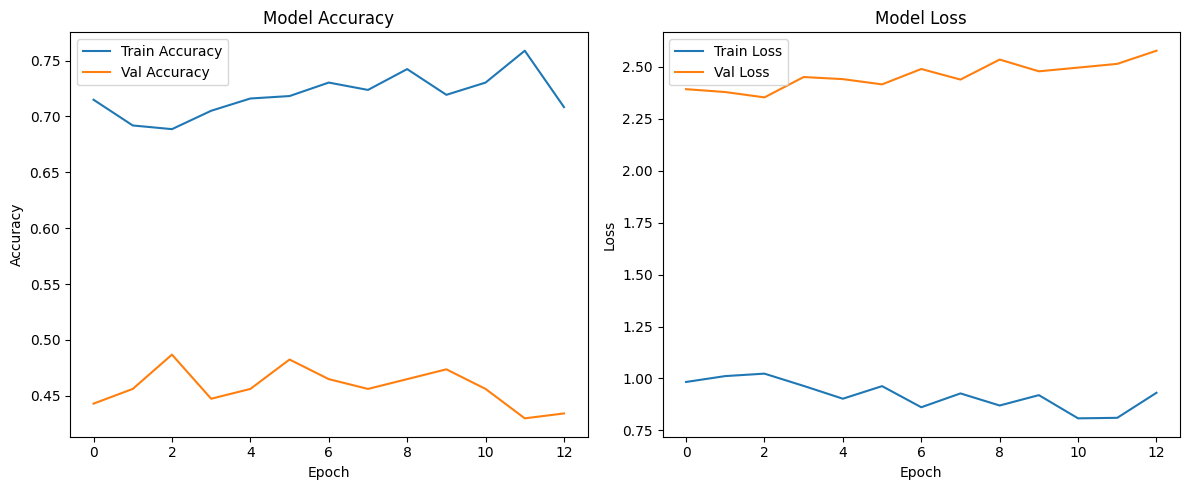

In [ ]:
import matplotlib.pyplot as plt

# Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


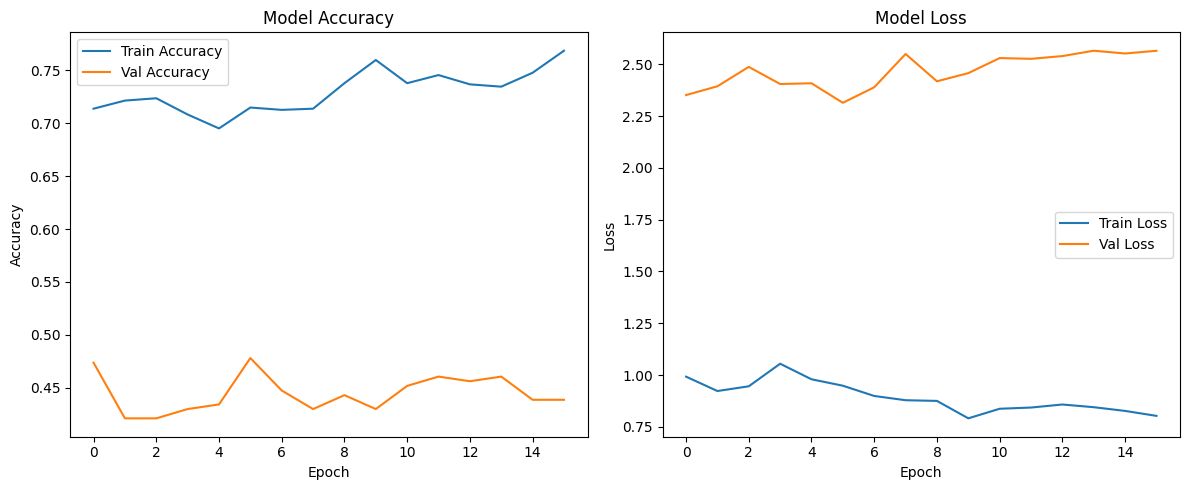

In [ ]:
import matplotlib.pyplot as plt

# Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


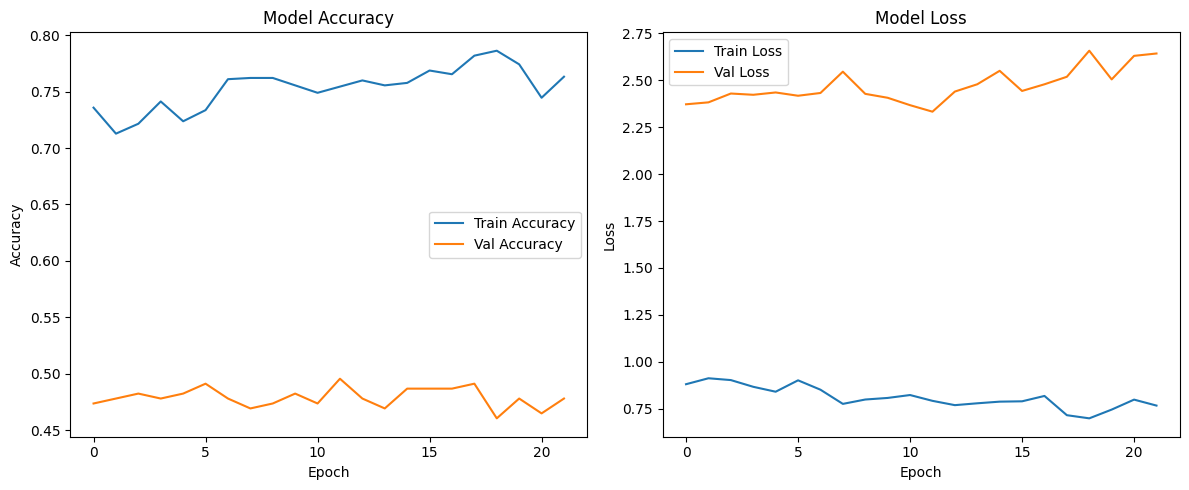

In [ ]:
import matplotlib.pyplot as plt

# Akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(model2.history['accuracy'], label='Train Accuracy')
plt.plot(model2.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss
plt.subplot(1, 2, 2)
plt.plot(model2.history['loss'], label='Train Loss')
plt.plot(model2.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [ ]:
def get_recipe_recommendations(bahan_input, model, label_lookup, df):
    input_tensor = tf.constant([bahan_input])

    preds = model.predict(input_tensor)
    top_indices = preds[0].argsort()[-5:][::-1]

    vocab = label_lookup.get_vocabulary()
    top_labels = [vocab[i] for i in top_indices]

    rekomendasi_df = df[df['nama_makanan'].isin(top_labels)].drop_duplicates('nama_makanan').head(5)

    return rekomendasi_df

In [ ]:
bahan_input = "tempe"

rekomendasi = get_recipe_recommendations(
    bahan_input,
    model=model,
    label_lookup=label_lookup,
    df=df_new
)

for i, row in rekomendasi.iterrows():
    print("=" * 40)
    print(f"[Predicted: {row['nama_makanan']}]")
    print(row['target_text'])
    print("=" * 40 + "\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
[Predicted: tempe penyet]
[TITLE] tempe penyet
[STEP]
 1. siapkan bahan.
 2. potong tempe sesuai selera dan rendam dalam air yang dicampur bawang putih garam dan penyedap.
 3. diamkan sambil menyiapkan sambal.
 4. siapkan bahan sambal.
 5. potong kecil kecil tomat bawang dan cabe agar mudah dihaluskan.
 6. panaskan minyak dan masukkan bahan yang telah dipotong kecil sampai layu.
 7. saat sudah layu masukkan tempe dan kacang tanah goreng hingga tempe setengah matang.
 8. angkat bahan sambel.
 9. tambahkan terasi matang dan haluskan.
 10. tumis kembali sambel yang sudah halus tambahkan garam penyedap dan gula jawa.
 11. koreksi rasa.
 12. jika terlalu kental bisa ditambahkan air.
 13. saya beri agak banyak air dan direbus hingga surut agar sambel lebih awet.
 14. setelah sambal matang beri perasan jeruk.
 15. sambil menunggu sambal matang.
 16. goreng tempe yang sudah direndam bumbu hingga matang.
 17. hidangkan tempe dengan sambel penyet.
 18. letak

In [ ]:
bahan_input = "ikan"

rekomendasi = get_recipe_recommendations(
    bahan_input,
    model=model,
    label_lookup=label_lookup,
    df=df_new
)

for i, row in rekomendasi.iterrows():
    print("=" * 40)
    print(f"[Predicted: {row['nama_makanan']}]")
    print(row['target_text'])
    print("=" * 40 + "\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 591ms/step
[Predicted: abon ikan]
[TITLE] abon ikan
[STEP]
 1. siapkan bahan.
 2. kukus ikan tuna angkat dinginkan dan suwir suwir.
 3. bumbu dihaluskan tumis dengan minyak goreng aduk sampai wangi dan tambahkan santan dan masak hingga tanak atau bau langu hilang.
 4. tambahkan gula garam dan aduk rata.
 5. masukkan ikan suwiir masak dengan api kecil dan aduk terus sampai kering.
 6. jika abonnya sudah dingin simpan dalam wadah tertutup.
 7. masyaallah ini enak banget.
 8. nambah nasi ya.
 9. ini abonnya di haluskan lagi dengan copper.

[Predicted: balado ikan tongkol]
[TITLE] balado ikan tongkol
[STEP]
 1. panaskan wajan beri minyak goreng setelah minyak panas masukkan ikan tongkol lalu tutup hati2 saat menggoreng karena akan meletup2 balik hanya.
 2. x ikan tongkolnya saya tidak kering.
 3. hanya sampai panas saja angkat lalu tiriskan.
 4. tumis bumbu halus dengan sedikit minyak goreng biarkan sampai harum.
 5. masukkan ikan tongkol goreng beri air garam g

In [ ]:
bahan_input = "tempe"

rekomendasi = get_recipe_recommendations(
    bahan_input,
    model=model,
    label_lookup=label_lookup,
    df=df_new
)

for i, row in rekomendasi.iterrows():
    print("=" * 40)
    print(f"[Predicted: {row['nama_makanan']}]")
    print(row['target_text'])
    print("=" * 40 + "\n")

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 688ms/step
[Predicted: tempe penyet]
[TITLE] tempe penyet
[STEP]
 1. siapkan bahan.
 2. potong tempe sesuai selera dan rendam dalam air yang dicampur bawang putih garam dan penyedap.
 3. diamkan sambil menyiapkan sambal.
 4. siapkan bahan sambal.
 5. potong kecil kecil tomat bawang dan cabe agar mudah dihaluskan.
 6. panaskan minyak dan masukkan bahan yang telah dipotong kecil sampai layu.
 7. saat sudah layu masukkan tempe dan kacang tanah goreng hingga tempe setengah matang.
 8. angkat bahan sambel.
 9. tambahkan terasi matang dan haluskan.
 10. tumis kembali sambel yang sudah halus tambahkan garam penyedap dan gula jawa.
 11. koreksi rasa.
 12. jika terlalu kental bisa ditambahkan air.
 13. saya beri agak banyak air dan direbus hingga surut agar sambel lebih awet.
 14. setelah sambal matang beri perasan jeruk.
 15. sambil menunggu sambal matang.
 16. goreng tempe yang sudah direndam bumbu hingga matang.
 17. hidangkan tempe dengan sambel penyet.
 18. leta

## SAVE MODEL

In [ ]:
from tensorflow import keras

model.save('my_model.keras')

model = keras.models.load_model('my_model.keras')
model.save('my_model.h5')